Libraries

In [24]:
%pip install tensorflow
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.spatial import distance
import os
import re
from obspy.signal.trigger import classic_sta_lta, trigger_onset

Note: you may need to restart the kernel to use updated packages.


Funciones

In [16]:
#Lectura de datos del archivo CSV y limpieza de outliers
def read_and_clean_data(cat, row_index):
    # Obtener los datos del archivo correspondiente
    row = cat.iloc[row_index]
    arrival_time_rel = row['time_rel(sec)']
    test_filename = row.filename

    # Leer el archivo CSV con los datos de velocidad
    data_directory = './data/lunar/training/data/S12_GradeA/'
    csv_file = f'{data_directory}{test_filename}.csv'
    data_cat = pd.read_csv(csv_file)

    # Filtrar outliers usando el IQR
    Q1 = data_cat['velocity(m/s)'].quantile(0.25)
    Q3 = data_cat['velocity(m/s)'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    clean_data_cat = data_cat[(data_cat['velocity(m/s)'] >= lower_bound) & (data_cat['velocity(m/s)'] <= upper_bound)]

    return clean_data_cat, data_cat, test_filename, arrival_time_rel



def extract_base_date(test_filename):
    """Extrae la fecha de un test_filename dado en el formato específico."""
    # Buscando el patrón de fecha en el nombre de archivo
    match = re.search(r'(\d{4}-\d{2}-\d{2})', test_filename)
    if match:
        return pd.Timestamp(match.group(0))
    else:
        raise ValueError("No se pudo encontrar la fecha en el test_filename.")

def relative_to_absolute(relative_time, test_filename):
    """Convierte el tiempo relativo en segundos a tiempo absoluto en formato datetime."""
    base_date = extract_base_date(test_filename)
    return base_date + pd.Timedelta(seconds=relative_time)

def absolute_to_relative(absolute_time, test_filename):
    """Convierte el tiempo absoluto en formato datetime a tiempo relativo en segundos."""
    base_date = extract_base_date(test_filename)
    return (absolute_time - base_date).total_seconds()

def plot_velocity_trace(csv_times, csv_data, arrival_time_rel, test_filename):
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(csv_times, csv_data)

    # Marcar la llegada
    arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
    ax.legend(handles=[arrival_line])

    # Hacer la gráfica bonita
    ax.set_xlim([min(csv_times), max(csv_times)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'{test_filename}', fontweight='bold')

def plot_velocity_trace_detection(csv_times, csv_data, arrival_time_rel, test_filename, detection_times):
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(csv_times, csv_data, label='Velocity')

    # Marcar la llegada
    arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
    ax.legend(handles=[arrival_line])

    # Marcar los tiempos de detección
    for detection_time in detection_times:
        # Convertir el tiempo de detección a segundos
        time_in_seconds = (detection_time - detection_times[0].replace(tzinfo=None)).total_seconds()
        ax.axvline(x=time_in_seconds, c='blue', linestyle='--', label='Detection Time')

    # Hacer la gráfica bonita
    ax.set_xlim([min(csv_times), max(csv_times)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'{test_filename}', fontweight='bold')

    # Evitar múltiples leyendas
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    plt.show()

def assign_scores(df_sorted_mean, df_sorted_power, clean_df_sorted_mean, clean_df_sorted_power):
    score_df = pd.DataFrame(columns=['id', 'time_abs', 'score'])
    
    def update_scores(df, score_df, column_name):
        for idx, row in df.iterrows():
            time_abs = row['time_abs']
            score = 0
            position = df.index.get_loc(idx)
            if position == 0 or position == len(df) - 1:
                score += 2
            elif position == 1 or position == len(df) - 2:
                score += 1
            
            if idx in score_df['id'].values:
                score_df.loc[score_df['id'] == idx, 'score'] += score
            else:
                score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)
        return score_df
    
    score_df = update_scores(df_sorted_mean, score_df, 'mean_variation')
    score_df = update_scores(df_sorted_power, score_df, 'power_variation')
    score_df = update_scores(clean_df_sorted_mean, score_df, 'mean_variation')
    score_df = update_scores(clean_df_sorted_power, score_df, 'power_variation')

    score_df = score_df.sort_values(by='score', ascending=False).reset_index(drop=True)
    return score_df

def trigger_detection(tr_data, tr_times, df, sta_len, lta_len, thr_on, thr_off):
    df = tr.stats.sampling_rate

    # Cálculo del STA/LTA
    cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

    # Almacenar los tiempos de detección
    starttime = tr.stats.starttime.datetime
    detection_times = []
    for i in np.arange(0, len(on_off)):
        triggers = on_off[i]
        on_time = starttime + timedelta(seconds=tr_times[triggers[0]])
        detection_times.append(on_time)

    return detection_times


def calculate_and_sort_variations(original_data_cat, clean_data_cat, detection_times):
    def get_time_column_name(df):
        possible_names = ['time_abs', 'time_abs(%Y-%m-%dT%H:%M:%S.%f)']
        for name in possible_names:
            if name in df.columns:
                return name
        raise KeyError("No se encontró la columna de tiempo en el DataFrame.")
    
    def calculate_variations(data_cat, detect_df, time_col_cat, time_col_detect):
        results = []
        for index, row in detect_df.iterrows():
            detection_time = row[time_col_detect]
            start_time_prev = detection_time - pd.Timedelta(minutes=5)
            end_time_prev = detection_time
            start_time_post = detection_time
            end_time_post = detection_time + pd.Timedelta(minutes=5)

            prev_data = data_cat[(data_cat[time_col_cat] >= start_time_prev) & 
                                 (data_cat[time_col_cat] <= end_time_prev)]
            if not prev_data.empty:
                prev_mean = prev_data['velocity(m/s)'].mean()
                prev_power = (prev_data['velocity(m/s)'] ** 2).mean()
            else:
                prev_mean = 0
                prev_power = 0

            post_data = data_cat[(data_cat[time_col_cat] >= start_time_post) & 
                                 (data_cat[time_col_cat] <= end_time_post)]
            if not post_data.empty:
                post_mean = post_data['velocity(m/s)'].mean()
                post_power = (post_data['velocity(m/s)'] ** 2).mean()
            else:
                post_mean = 0
                post_power = 0

            mean_variation = post_mean - prev_mean
            power_variation = post_power - prev_power

            results.append({
                'time_abs': detection_time,
                'mean_variation': mean_variation,
                'power_variation': power_variation
            })
        return pd.DataFrame(results)
    
    if isinstance(detection_times, list):
        detection_times = pd.DataFrame(detection_times, columns=['time_abs'])
    
    time_col_clean_cat = get_time_column_name(clean_data_cat)
    time_col_detect = get_time_column_name(detection_times)
    
    clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
    detection_times[time_col_detect] = pd.to_datetime(detection_times[time_col_detect])

    clean_variation_df = calculate_variations(clean_data_cat, detection_times, time_col_clean_cat, time_col_detect)
    clean_variation_df_sorted_mean = clean_variation_df.sort_values(by='mean_variation', ascending=False)
    clean_variation_df_sorted_power = clean_variation_df.sort_values(by='power_variation', ascending=False)
    
    time_col_cat = get_time_column_name(original_data_cat)
    original_data_cat[time_col_cat] = pd.to_datetime(original_data_cat[time_col_cat])

    variation_df = calculate_variations(original_data_cat, detection_times, time_col_cat, time_col_detect)
    variation_df_sorted_mean = variation_df.sort_values(by='mean_variation', ascending=False)
    variation_df_sorted_power = variation_df.sort_values(by='power_variation', ascending=False)

    return clean_variation_df_sorted_mean, clean_variation_df_sorted_power, variation_df_sorted_mean, variation_df_sorted_power


ejecución

In [ ]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
columna=1
# Llamar a la función y almacenar el resultado
clean_data_cat, original_data_cat, test_filename, arrival_time_rel = read_and_clean_data(cat, columna)

# Ahora puedes usar `original_data_cat` y `clean_data_cat`
print(f"Nombre del archivo: {test_filename}")
print(f"Tiempo de llegada relativo: {arrival_time_rel}")
print(f"Datos originales:\n{original_data_cat.head()}")
print(f"Datos limpios:\n{clean_data_cat.head()}")

In [ ]:
csv_times = np.array(original_data_cat['time_rel(sec)'].tolist())
csv_data = np.array(original_data_cat['velocity(m/s)'].tolist())


plot_velocity_trace(csv_data=csv_data, csv_times=csv_times, arrival_time_rel=arrival_time_rel, test_filename=test_filename)

In [ ]:
data_directory = './data/lunar/training/data/S12_GradeA/'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
st

# (tr_data, tr_times, df, sta_len, lta_len, thr_on, thr_off)
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data
df = tr.stats.sampling_rate
# How long should the short-term and long-term window be, in seconds
sta_len = 120
lta_len = 600
thr_on = 3
thr_off = 1
detection_times = trigger_detection(tr_data=tr_data, tr_times=tr_times, df=df, sta_len=sta_len, lta_len=lta_len, thr_off=thr_off, thr_on=thr_on)

In [ ]:
csv_times = np.array(original_data_cat['time_rel(sec)'].tolist())
csv_data = np.array(original_data_cat['velocity(m/s)'].tolist())


plot_velocity_trace_detection(csv_data=csv_data, csv_times=csv_times, detection_times=detection_times, arrival_time_rel=arrival_time_rel, test_filename=test_filename)

In [ ]:
clean_variation_df_sorted_mean, clean_variation_df_sorted_power, variation_df_sorted_mean, variation_df_sorted_power = calculate_and_sort_variations(original_data_cat, clean_data_cat, detection_times)


In [ ]:

scores_df = assign_scores(
    variation_df_sorted_mean,
    variation_df_sorted_power,
    clean_variation_df_sorted_mean,
    clean_variation_df_sorted_power
)
absolute_arrival= relative_to_absolute(relative_time=arrival_time_rel, test_filename=test_filename)
# Mostrar los resultados
print(f"Inicio de sismo desde catálogo: {absolute_arrival}")
print("DataFrame de Scores:")
print(scores_df)


Nombre del archivo: xa.s12.00.mhz.1970-03-25HR00_evid00003
Tiempo de llegada relativo: 12720.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-03-25T00:00:00.440000       0.000000  -5.481780e-15
1     1970-03-25T00:00:00.590943       0.150943  -6.878653e-15
2     1970-03-25T00:00:00.741887       0.301887  -7.486137e-15
3     1970-03-25T00:00:00.892830       0.452830  -7.191481e-15
4     1970-03-25T00:00:01.043774       0.603774  -6.287278e-15
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-03-25T00:00:00.440000       0.000000  -5.481780e-15
1     1970-03-25T00:00:00.590943       0.150943  -6.878653e-15
2     1970-03-25T00:00:00.741887       0.301887  -7.486137e-15
3     1970-03-25T00:00:00.892830       0.452830  -7.191481e-15
4     1970-03-25T00:00:01.043774       0.603774  -6.287278e-15


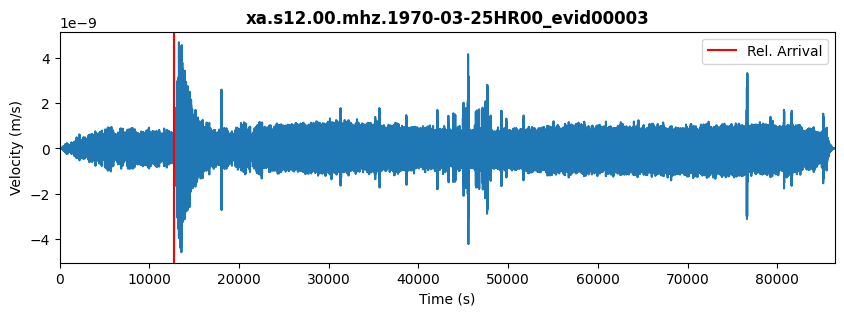

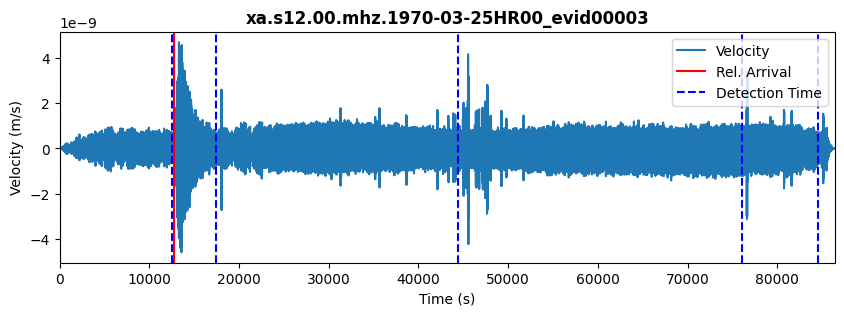

Inicio de sismo desde catálogo: 1970-03-25 03:32:00
DataFrame de Scores:
  id                   time_abs score
0  1 1970-03-25 03:39:00.666415     6
1  5 1970-03-25 23:38:51.006038     5
2  4 1970-03-25 21:16:59.458868     5
3  2 1970-03-25 05:00:18.553208     4
4  3 1970-03-25 12:30:54.628679     2
5  0 1970-03-25 00:10:00.289057     2


/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


In [21]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
columna=1
# Llamar a la función y almacenar el resultado
clean_data_cat, original_data_cat, test_filename, arrival_time_rel = read_and_clean_data(cat, columna)
print(f"Nombre del archivo: {test_filename}")
print(f"Tiempo de llegada relativo: {arrival_time_rel}")
print(f"Datos originales:\n{original_data_cat.head()}")
print(f"Datos limpios:\n{clean_data_cat.head()}")
csv_times = np.array(original_data_cat['time_rel(sec)'].tolist())
csv_data = np.array(original_data_cat['velocity(m/s)'].tolist())
plot_velocity_trace(csv_data=csv_data, csv_times=csv_times, arrival_time_rel=arrival_time_rel, test_filename=test_filename)

data_directory = './data/lunar/training/data/S12_GradeA/'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
st
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data
df = tr.stats.sampling_rate
# How long should the short-term and long-term window be, in seconds
sta_len = 120
lta_len = 600
thr_on = 3
thr_off = 1
detection_times = trigger_detection(tr_data=tr_data, tr_times=tr_times, df=df, sta_len=sta_len, lta_len=lta_len, thr_off=thr_off, thr_on=thr_on)
csv_times = np.array(original_data_cat['time_rel(sec)'].tolist())
csv_data = np.array(original_data_cat['velocity(m/s)'].tolist())
plot_velocity_trace_detection(csv_data=csv_data, csv_times=csv_times, detection_times=detection_times, arrival_time_rel=arrival_time_rel, test_filename=test_filename)
clean_variation_df_sorted_mean, clean_variation_df_sorted_power, variation_df_sorted_mean, variation_df_sorted_power = calculate_and_sort_variations(original_data_cat, clean_data_cat, detection_times)
scores_df = assign_scores(
    variation_df_sorted_mean,
    variation_df_sorted_power,
    clean_variation_df_sorted_mean,
    clean_variation_df_sorted_power
)
absolute_arrival= relative_to_absolute(relative_time=arrival_time_rel, test_filename=test_filename)
# Mostrar los resultados
print(f"Inicio de sismo desde catálogo: {absolute_arrival}")
print("DataFrame de Scores:")
print(scores_df)


Nombre del archivo: xa.s12.00.mhz.1970-01-19HR00_evid00002
Tiempo de llegada relativo: 73500.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-01-19T00:00:00.665000       0.000000  -6.153279e-14
1     1970-01-19T00:00:00.815943       0.150943  -7.701288e-14
2     1970-01-19T00:00:00.966887       0.301887  -8.396187e-14
3     1970-01-19T00:00:01.117830       0.452830  -8.096155e-14
4     1970-01-19T00:00:01.268774       0.603774  -7.097599e-14
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-01-19T00:00:00.665000       0.000000  -6.153279e-14
1     1970-01-19T00:00:00.815943       0.150943  -7.701288e-14
2     1970-01-19T00:00:00.966887       0.301887  -8.396187e-14
3     1970-01-19T00:00:01.117830       0.452830  -8.096155e-14
4     1970-01-19T00:00:01.268774       0.603774  -7.097599e-14


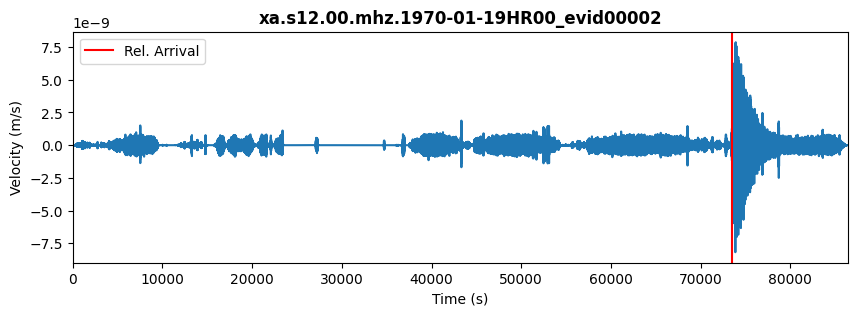

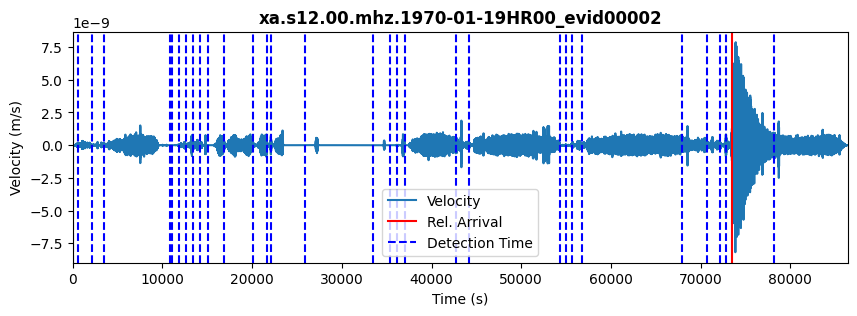

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1970-01-19 20:25:00
DataFrame de Scores:
    id                   time_abs score
0   29 1970-01-19 20:24:29.042358     6
1   26 1970-01-19 19:02:07.608396     4
2   30 1970-01-19 21:52:08.363113     3
3   13 1970-01-19 06:10:00.212170     3
4   20 1970-01-19 12:02:03.231038     3
5    8 1970-01-19 03:52:30.400849     2
6   21 1970-01-19 12:26:11.532925     1
7   18 1970-01-19 10:12:31.608396     1
8    2 1970-01-19 00:46:00.514057     1
9   14 1970-01-19 06:18:22.551792     0
10  23 1970-01-19 15:26:26.174434     0
11  28 1970-01-19 20:13:22.325377     0
12   7 1970-01-19 03:40:47.306509     0
13   9 1970-01-19 04:06:07.004623     0
14   1 1970-01-19 00:18:52.740472     0
15  17 1970-01-19 09:59:42.249906     0
16   5 1970-01-19 03:14:39.759340     0
17  27 1970-01-19 19:48:33.268774     0
18   0 1970-01-19 00:10:00.514057     0
19  11 1970-01-19 04:51:00.740472     0
20  10 1970-01-19 04:20:54.249906     0
21  15 1970-01-19 07:22:01.419717     0
22  24 

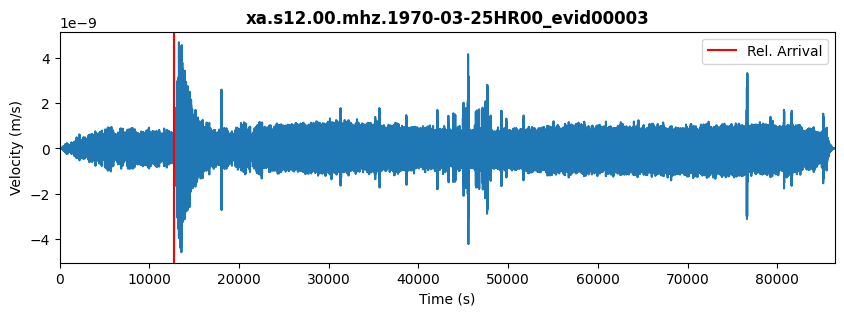

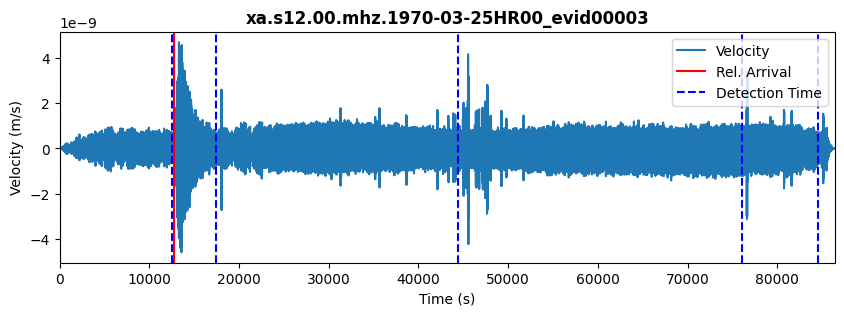

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1970-03-25 03:32:00
DataFrame de Scores:
  id                   time_abs score
0  1 1970-03-25 03:39:00.666415     6
1  5 1970-03-25 23:38:51.006038     5
2  4 1970-03-25 21:16:59.458868     5
3  2 1970-03-25 05:00:18.553208     4
4  3 1970-03-25 12:30:54.628679     2
5  0 1970-03-25 00:10:00.289057     2
Nombre del archivo: xa.s12.00.mhz.1970-03-26HR00_evid00004
Tiempo de llegada relativo: 73020.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-03-26T00:00:00.565000       0.000000  -2.821246e-14
1     1970-03-26T00:00:00.715943       0.150943  -3.523317e-14
2     1970-03-26T00:00:00.866887       0.301887  -3.859334e-14
3     1970-03-26T00:00:01.017830       0.452830  -3.760071e-14
4     1970-03-26T00:00:01.168774       0.603774  -3.343556e-14
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-03-26T00:00:00.565000       0.000000  -2.821246e-14
1     1970-03-26T00:00:00.715

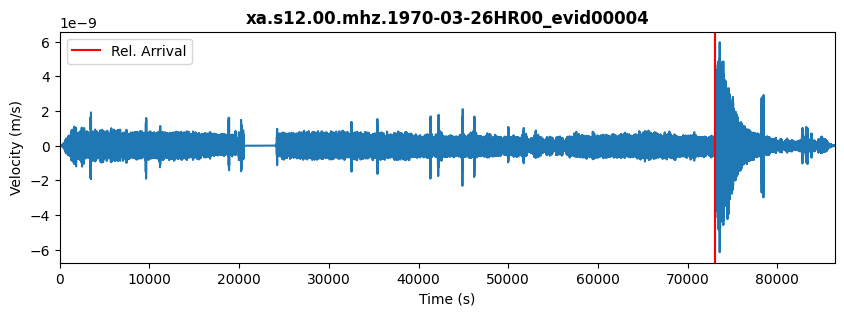

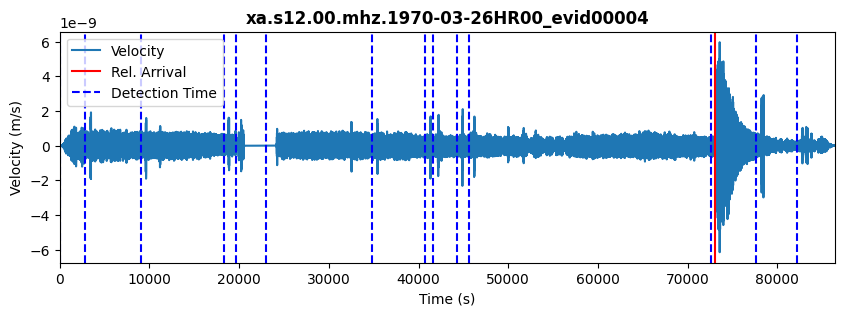

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1970-03-26 20:17:00
DataFrame de Scores:
    id                   time_abs score
0    4 1970-03-26 05:37:13.470660     4
1   11 1970-03-26 20:19:51.659340     4
2    6 1970-03-26 09:50:37.848019     3
3   13 1970-03-26 22:59:56.942358     2
4   12 1970-03-26 21:44:06.602736     2
5    8 1970-03-26 11:43:04.715943     2
6    9 1970-03-26 12:28:01.923491     2
7    2 1970-03-26 02:40:19.432925     2
8    0 1970-03-26 00:10:00.414057     1
9   10 1970-03-26 12:50:10.678208     1
10   7 1970-03-26 11:28:43.432925     1
11   5 1970-03-26 06:33:10.300849     0
12   3 1970-03-26 05:14:20.942358     0
13   1 1970-03-26 00:57:43.659340     0
Nombre del archivo: xa.s12.00.mhz.1970-04-25HR00_evid00006
Tiempo de llegada relativo: 4440.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-04-25T00:00:00.196000       0.000000   9.016423e-15
1     1970-04-25T00:00:00.346943       0.150943   1.130571e-14
2     1970-04-25T00:00:00.

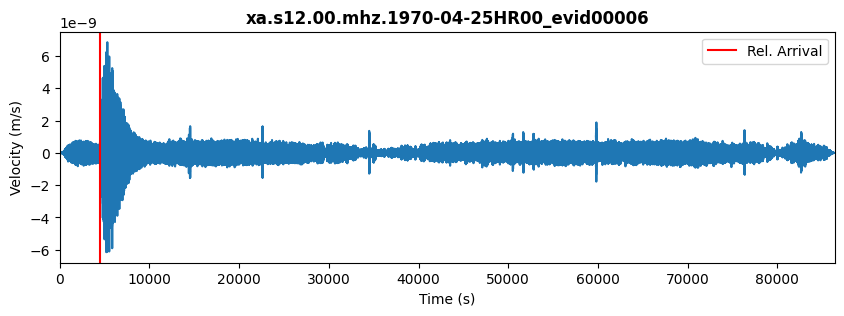

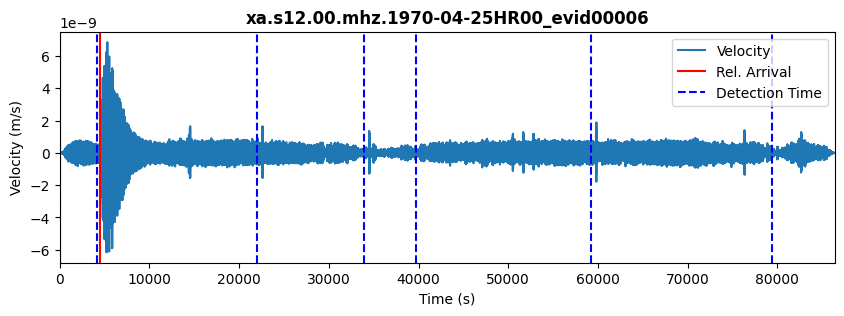

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1970-04-25 01:14:00
DataFrame de Scores:
  id                   time_abs score
0  2 1970-04-25 06:17:11.441283     6
1  1 1970-04-25 01:18:43.969585     6
2  5 1970-04-25 16:36:50.460151     5
3  3 1970-04-25 09:34:56.497887     3
4  6 1970-04-25 22:13:51.743170     2
5  4 1970-04-25 11:12:03.214868     1
6  0 1970-04-25 00:10:00.045057     1
Nombre del archivo: xa.s12.00.mhz.1970-04-26HR00_evid00007
Tiempo de llegada relativo: 52140.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-04-26T00:00:00.660000       0.000000  -1.583565e-16
1     1970-04-26T00:00:00.810943       0.150943  -1.872995e-16
2     1970-04-26T00:00:00.961887       0.301887  -2.007235e-16
3     1970-04-26T00:00:01.112830       0.452830  -1.989497e-16
4     1970-04-26T00:00:01.263774       0.603774  -1.857298e-16
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-04-26T00:00:00.660000       0.000000  -1.58

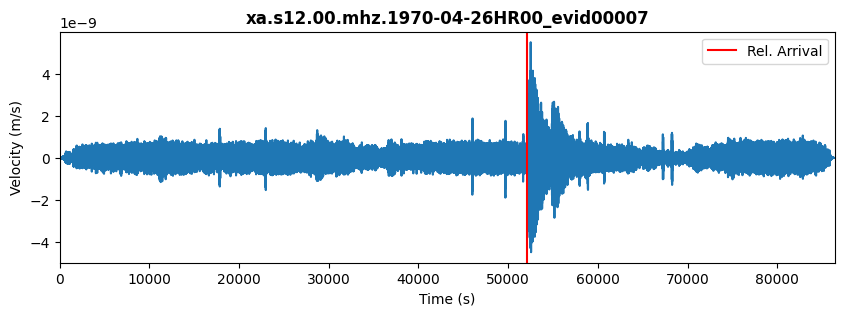

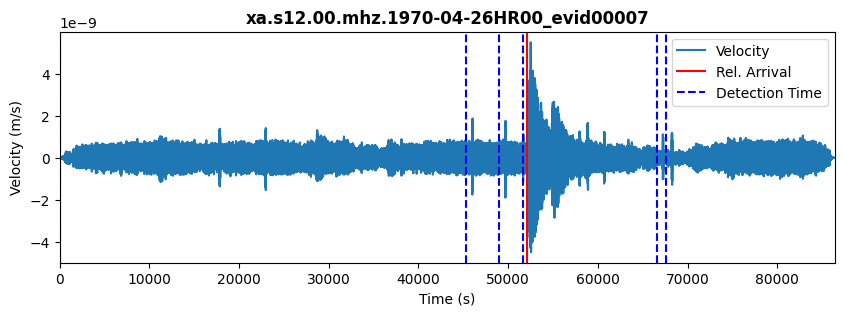

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1970-04-26 14:29:00
DataFrame de Scores:
  id                   time_abs score
0  3 1970-04-26 14:32:14.697736     6
1  1 1970-04-26 12:46:56.810943     6
2  5 1970-04-26 18:57:32.131698     4
3  2 1970-04-26 13:48:14.093962     4
4  4 1970-04-26 18:40:52.886415     3
5  0 1970-04-26 00:11:01.339245     1
Nombre del archivo: xa.s12.00.mhz.1970-06-15HR00_evid00008
Tiempo de llegada relativo: 68400.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-06-15T00:00:00.510000       0.000000  -8.042576e-16
1     1970-06-15T00:00:00.660943       0.150943  -9.666565e-16
2     1970-06-15T00:00:00.811887       0.301887  -1.046656e-15
3     1970-06-15T00:00:00.962830       0.452830  -9.966189e-16
4     1970-06-15T00:00:01.113774       0.603774  -8.303573e-16
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-06-15T00:00:00.510000       0.000000  -8.042576e-16
1     1970-06-15T00:00:00.660

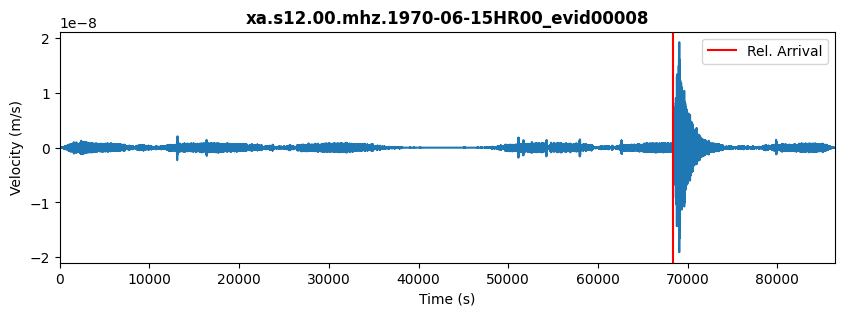

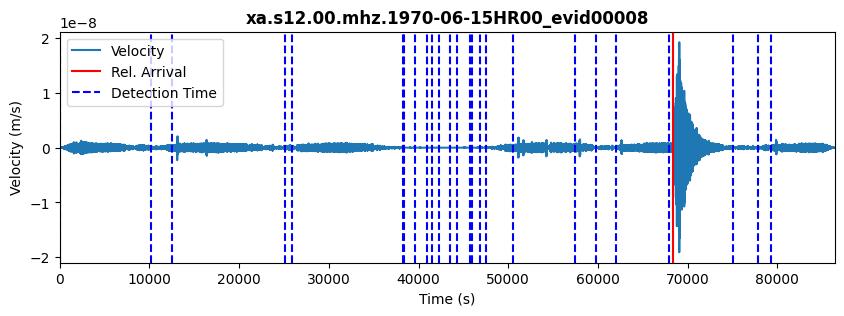

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1970-06-15 19:00:00
DataFrame de Scores:
    id                   time_abs score
0   18 1970-06-15 16:06:26.019434     6
1   21 1970-06-15 19:01:25.189245     4
2    4 1970-06-15 07:22:01.717547     2
3    2 1970-06-15 03:38:02.321321     2
4   17 1970-06-15 14:12:08.359057     2
5   19 1970-06-15 16:45:42.396792     2
6   23 1970-06-15 21:46:40.057170     2
7    0 1970-06-15 00:10:00.359057     1
8    3 1970-06-15 07:07:48.887358     1
9    1 1970-06-15 03:00:02.170377     1
10  24 1970-06-15 22:11:15.830755     1
11  22 1970-06-15 21:01:23.377925     0
12  13 1970-06-15 12:51:24.736415     0
13  20 1970-06-15 17:23:41.793019     0
14  12 1970-06-15 12:28:25.566604     0
15   7 1970-06-15 11:09:29.415660     0
16   9 1970-06-15 11:41:46.623208     0
17  14 1970-06-15 12:56:20.283585     0
18  11 1970-06-15 12:14:10.623208     0
19  16 1970-06-15 13:22:47.755283     0
20   8 1970-06-15 11:32:17.717547     0
21  15 1970-06-15 13:11:03.000566     0
22   6 

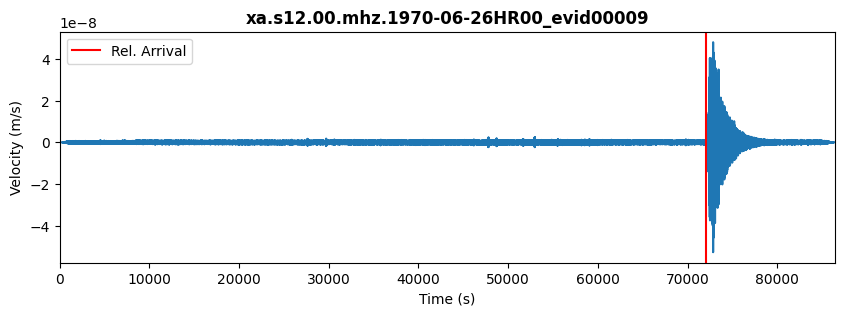

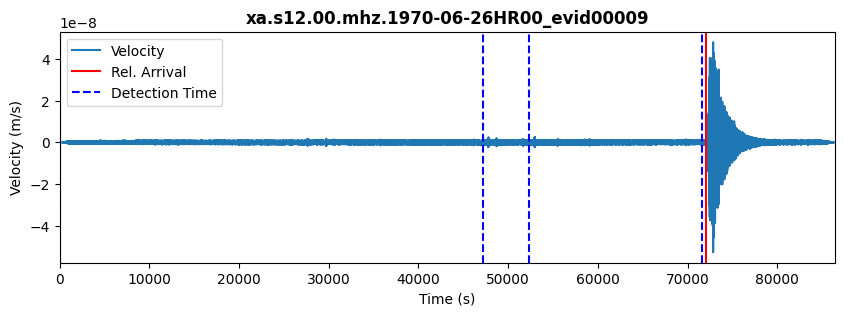

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1970-06-26 20:01:00
DataFrame de Scores:
  id                   time_abs score
0  3 1970-06-26 20:02:54.304679     7
1  1 1970-06-26 13:16:45.700906     6
2  2 1970-06-26 14:42:55.210340     6
3  0 1970-06-26 00:09:59.965057     5
Nombre del archivo: xa.s12.00.mhz.1970-07-20HR00_evid00010
Tiempo de llegada relativo: 18360.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-07-20T00:00:00.487000       0.000000  -1.462155e-15
1     1970-07-20T00:00:00.637943       0.150943  -1.824771e-15
2     1970-07-20T00:00:00.788887       0.301887  -1.974266e-15
3     1970-07-20T00:00:00.939830       0.452830  -1.886487e-15
4     1970-07-20T00:00:01.090774       0.603774  -1.646714e-15
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-07-20T00:00:00.487000       0.000000  -1.462155e-15
1     1970-07-20T00:00:00.637943       0.150943  -1.824771e-15
2     1970-07-20T00:00:00.788887       0.3

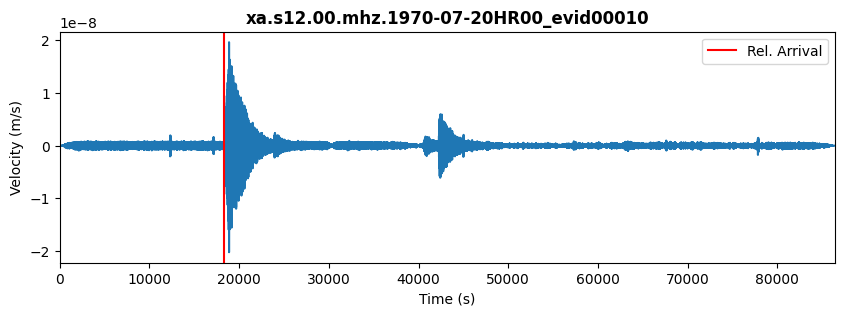

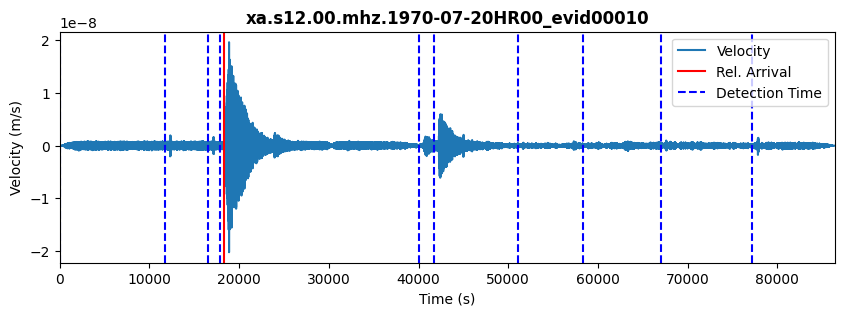

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1970-07-20 05:06:00
DataFrame de Scores:
  id                   time_abs score
0  2 1970-07-20 04:46:00.788887     4
1  3 1970-07-20 05:07:28.939830     4
2  5 1970-07-20 11:45:14.751151     4
3  8 1970-07-20 18:47:03.883226     3
4  4 1970-07-20 11:17:49.015302     3
5  1 1970-07-20 03:25:17.770019     3
6  6 1970-07-20 14:21:42.524736     2
7  9 1970-07-20 21:37:07.505868     1
8  0 1970-07-20 00:10:00.336057     0
9  7 1970-07-20 16:23:02.826623     0
Nombre del archivo: xa.s12.00.mhz.1970-07-20HR00_evid00011
Tiempo de llegada relativo: 42240.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-07-20T00:00:00.487000       0.000000  -1.462155e-15
1     1970-07-20T00:00:00.637943       0.150943  -1.824771e-15
2     1970-07-20T00:00:00.788887       0.301887  -1.974266e-15
3     1970-07-20T00:00:00.939830       0.452830  -1.886487e-15
4     1970-07-20T00:00:01.090774       0.603774  -1.646714e-15
Datos limpios:
  t

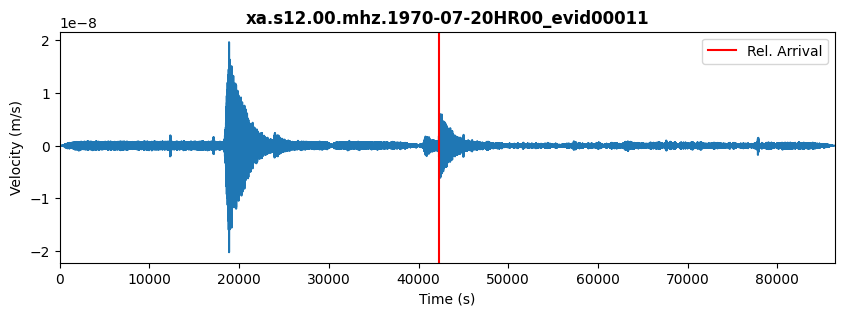

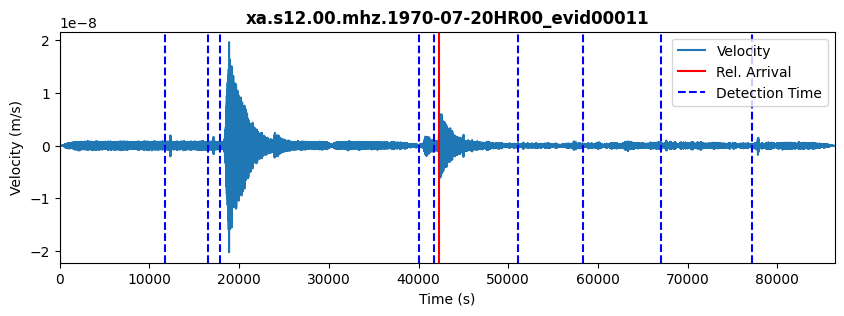

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1970-07-20 11:44:00
DataFrame de Scores:
  id                   time_abs score
0  2 1970-07-20 04:46:00.788887     4
1  3 1970-07-20 05:07:28.939830     4
2  5 1970-07-20 11:45:14.751151     4
3  8 1970-07-20 18:47:03.883226     3
4  4 1970-07-20 11:17:49.015302     3
5  1 1970-07-20 03:25:17.770019     3
6  6 1970-07-20 14:21:42.524736     2
7  9 1970-07-20 21:37:07.505868     1
8  0 1970-07-20 00:10:00.336057     0
9  7 1970-07-20 16:23:02.826623     0
Nombre del archivo: xa.s12.00.mhz.1970-09-26HR00_evid00013
Tiempo de llegada relativo: 71820.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-09-26T00:00:00.149000       0.000000  -1.743354e-16
1     1970-09-26T00:00:00.299943       0.150943  -1.810003e-16
2     1970-09-26T00:00:00.450887       0.301887  -1.614842e-16
3     1970-09-26T00:00:00.601830       0.452830  -1.344812e-16
4     1970-09-26T00:00:00.752774       0.603774  -1.187775e-16
Datos limpios:
  t

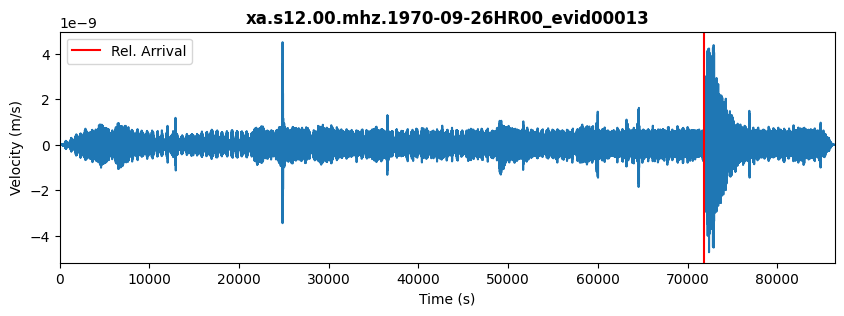

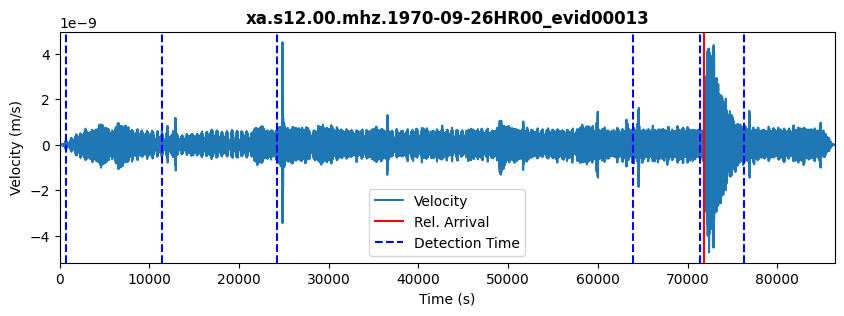

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1970-09-26 19:57:00
DataFrame de Scores:
  id                   time_abs score
0  3 1970-09-26 06:54:04.375415     6
1  5 1970-09-26 20:00:07.847113     6
2  4 1970-09-26 17:56:37.582962     4
3  6 1970-09-26 21:22:01.658434     3
4  1 1970-09-26 00:21:38.564094     3
5  0 1970-09-26 00:10:42.715038     1
6  2 1970-09-26 03:20:23.998057     1
Nombre del archivo: xa.s12.00.mhz.1970-10-24HR00_evid00014
Tiempo de llegada relativo: 41460.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-10-24T00:00:00.504000       0.000000  -2.236897e-15
1     1970-10-24T00:00:00.654943       0.150943  -2.841643e-15
2     1970-10-24T00:00:00.805887       0.301887  -3.104538e-15
3     1970-10-24T00:00:00.956830       0.452830  -2.970101e-15
4     1970-10-24T00:00:01.107774       0.603774  -2.565092e-15
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-10-24T00:00:00.504000       0.000000  -2.23

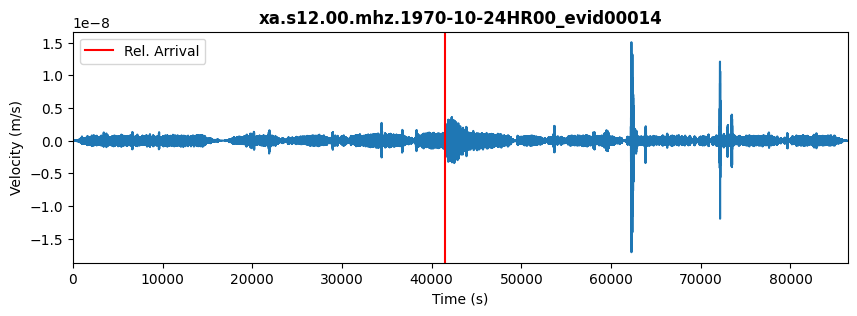

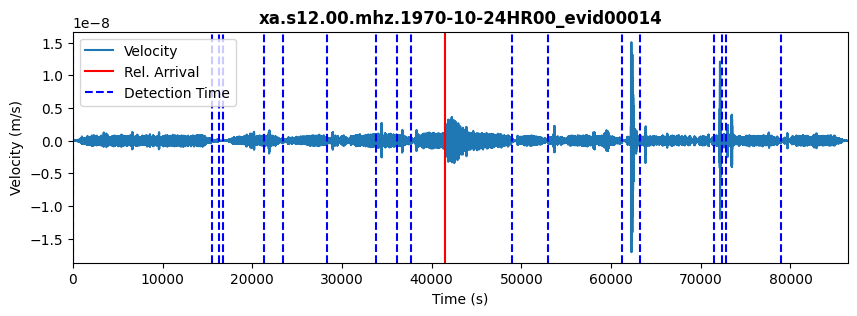

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1970-10-24 11:31:00
DataFrame de Scores:
    id                   time_abs score
0   14 1970-10-24 20:01:47.522868     4
1    9 1970-10-24 10:38:06.843623     4
2    8 1970-10-24 10:12:20.428528     3
3   11 1970-10-24 14:54:15.447396     3
4    7 1970-10-24 09:33:22.013434     3
5   12 1970-10-24 17:10:00.051170     2
6    6 1970-10-24 08:02:44.881358     2
7   15 1970-10-24 20:16:54.994566     1
8   17 1970-10-24 22:07:10.239849     1
9    4 1970-10-24 06:04:50.315321     1
10  16 1970-10-24 20:24:36.579472     0
11  10 1970-10-24 13:46:25.107774     0
12   1 1970-10-24 04:29:22.617208     0
13   0 1970-10-24 00:10:32.654943     0
14   3 1970-10-24 04:49:58.994566     0
15   5 1970-10-24 06:40:07.447396     0
16  13 1970-10-24 17:43:56.730415     0
17   2 1970-10-24 04:42:38.994566     0
Nombre del archivo: xa.s12.00.mhz.1970-11-12HR00_evid00015
Tiempo de llegada relativo: 46200.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  veloc

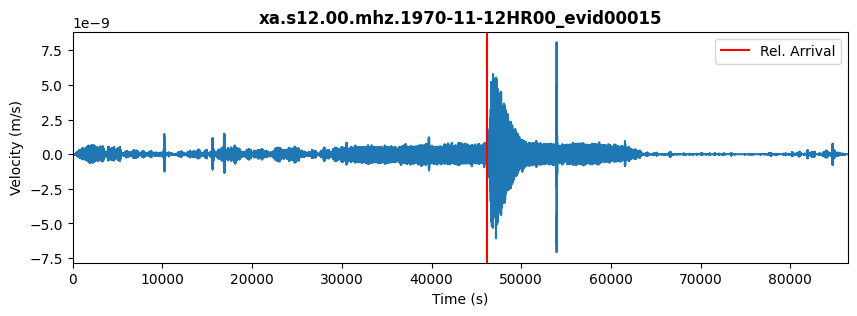

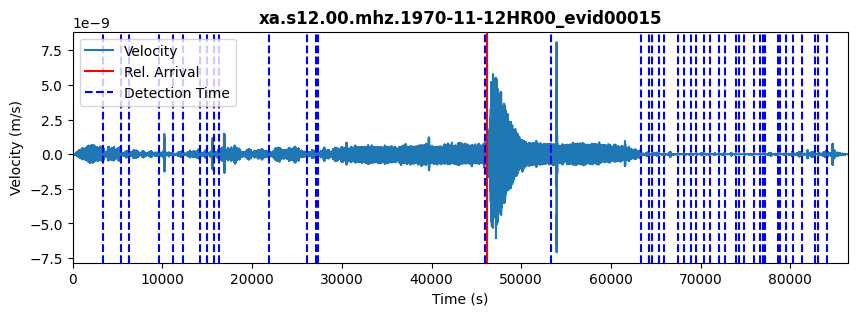

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1970-11-12 12:50:00
DataFrame de Scores:
    id                   time_abs score
0   16 1970-11-12 14:58:28.775472     6
1   10 1970-11-12 04:41:09.530189     5
2   15 1970-11-12 12:55:48.775472     4
3   11 1970-11-12 06:13:45.303774     3
4    1 1970-11-12 01:06:37.681132     2
5   44 1970-11-12 23:31:40.473585     1
6   43 1970-11-12 23:13:47.718868     1
7    4 1970-11-12 02:49:27.643396     1
8   19 1970-11-12 18:05:53.605660     1
9    8 1970-11-12 04:19:03.492453     0
10  22 1970-11-12 18:54:48.247170     0
11  26 1970-11-12 19:43:05.152830     0
12  25 1970-11-12 19:27:53.001887     0
13  36 1970-11-12 21:37:03.945283     0
14  38 1970-11-12 22:04:28.020755     0
15  32 1970-11-12 20:57:15.567925     0
16   7 1970-11-12 04:06:21.681132     0
17  17 1970-11-12 17:45:45.756604     0
18  21 1970-11-12 18:28:34.360377     0
19  23 1970-11-12 19:06:15.190566     0
20  29 1970-11-12 20:22:25.907547     0
21  35 1970-11-12 21:32:24.398113     0
22   0 

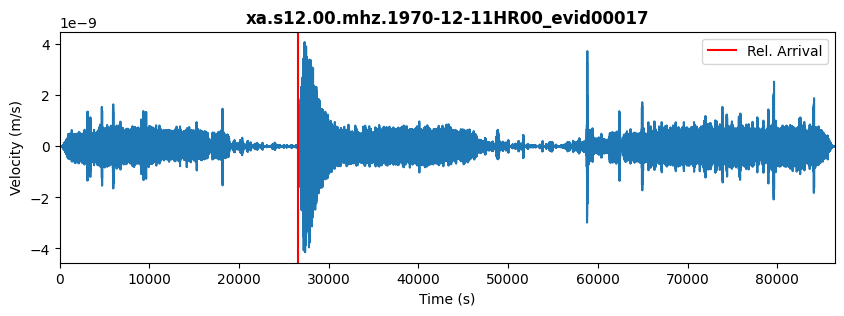

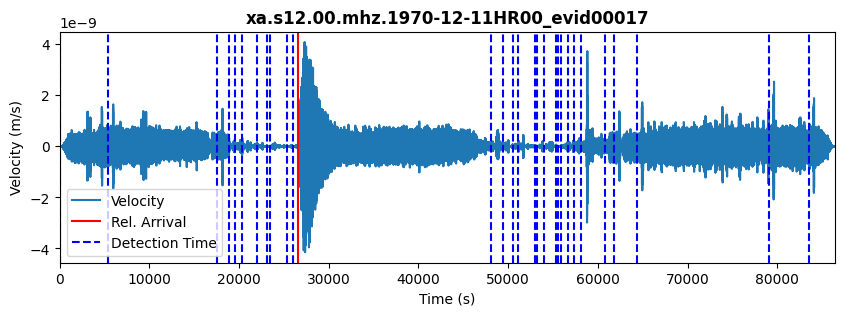

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1970-12-11 07:22:00
DataFrame de Scores:
    id                   time_abs score
0   23 1970-12-11 16:19:36.175057     5
1   25 1970-12-11 17:20:20.703358     5
2    2 1970-12-11 05:02:25.231660     3
3   10 1970-12-11 07:23:59.269396     3
4   24 1970-12-11 17:02:40.175057     2
5   28 1970-12-11 23:21:42.816566     2
6    1 1970-12-11 01:39:35.722226     2
7   27 1970-12-11 22:07:17.156189     2
8   17 1970-12-11 15:10:42.892038     0
9    5 1970-12-11 05:49:25.759962     0
10  26 1970-12-11 18:02:09.533547     0
11  22 1970-12-11 16:05:29.382604     0
12  14 1970-12-11 14:21:10.514679     0
13   4 1970-12-11 05:35:40.703358     0
14  11 1970-12-11 13:32:13.156189     0
15   7 1970-12-11 06:35:02.212792     0
16   9 1970-12-11 07:12:08.778830     0
17  16 1970-12-11 14:56:29.609019     0
18   0 1970-12-11 00:10:00.175057     0
19  13 1970-12-11 14:12:34.741094     0
20  20 1970-12-11 15:40:57.080717     0
21  12 1970-12-11 13:54:23.420340     0
22   3 

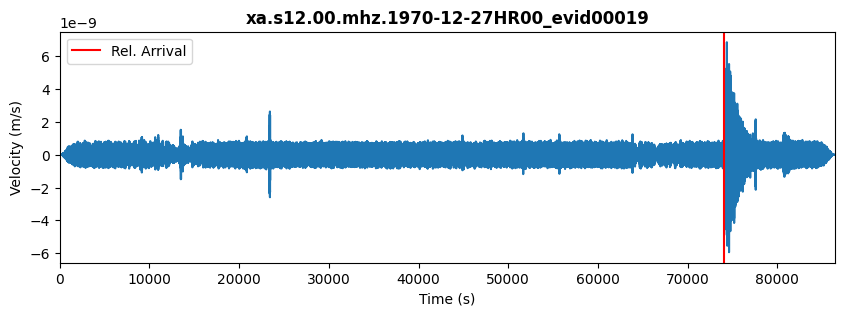

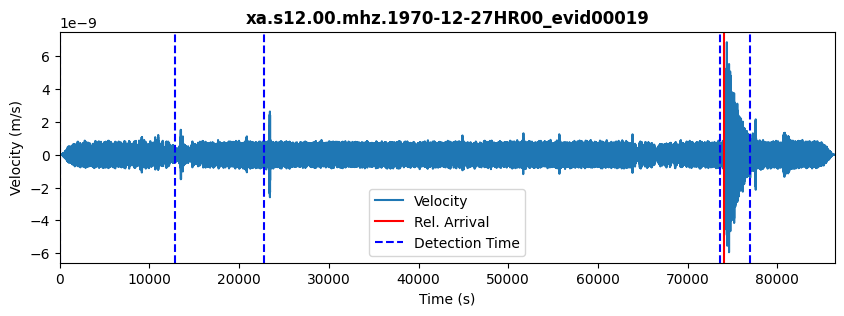

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1970-12-27 20:34:00
DataFrame de Scores:
  id                   time_abs score
0  3 1970-12-27 20:36:13.045302     8
1  4 1970-12-27 21:33:19.007566     6
2  2 1970-12-27 06:30:02.177377     6
3  0 1970-12-27 00:10:00.366057     3
4  1 1970-12-27 03:44:54.554736     1
Nombre del archivo: xa.s12.00.mhz.1970-12-31HR00_evid00021
Tiempo de llegada relativo: 56460.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-12-31T00:00:00.339000       0.000000   3.502083e-15
1     1970-12-31T00:00:00.489943       0.150943   4.419662e-15
2     1970-12-31T00:00:00.640887       0.301887   4.752110e-15
3     1970-12-31T00:00:00.791830       0.452830   4.116356e-15
4     1970-12-31T00:00:00.942774       0.603774   2.517291e-15
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-12-31T00:00:00.339000       0.000000   3.502083e-15
1     1970-12-31T00:00:00.489943       0.150943   4.419662e-15
2   

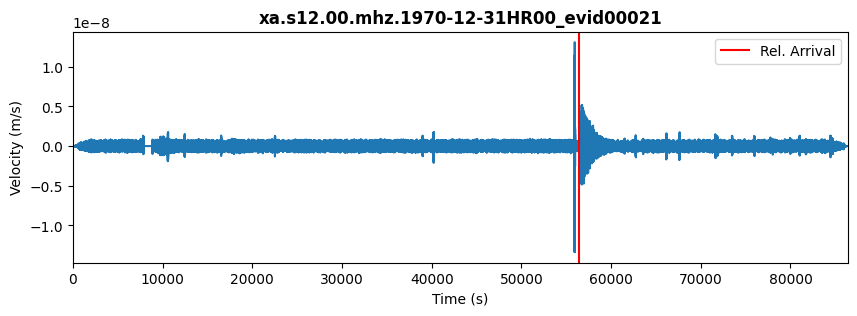

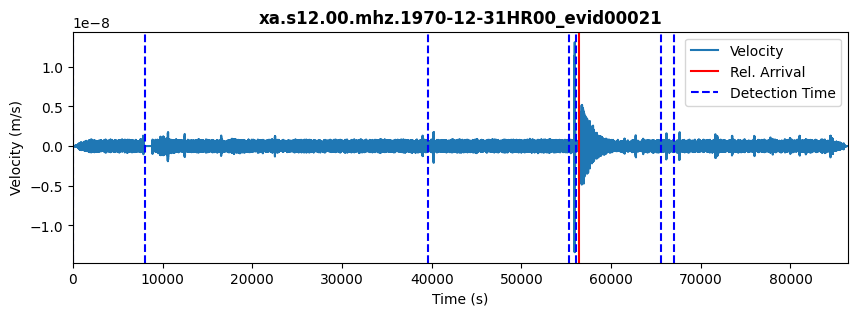

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1970-12-31 15:41:00
DataFrame de Scores:
  id                   time_abs score
0  3 1970-12-31 15:31:36.942774     7
1  4 1970-12-31 15:44:03.810698     6
2  5 1970-12-31 18:22:41.848434     4
3  1 1970-12-31 02:24:41.697491     3
4  6 1970-12-31 18:47:04.339000     2
5  2 1970-12-31 11:10:14.678623     2
6  0 1970-12-31 00:10:00.188057     0
Nombre del archivo: xa.s12.00.mhz.1971-01-15HR00_evid00022
Tiempo de llegada relativo: 45600.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-01-15T00:00:00.258000       0.000000  -1.813238e-15
1     1971-01-15T00:00:00.408943       0.150943  -6.975340e-16
2     1971-01-15T00:00:00.559887       0.301887   2.335177e-16
3     1971-01-15T00:00:00.710830       0.452830   1.821918e-16
4     1971-01-15T00:00:00.861774       0.603774  -6.603485e-16
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-01-15T00:00:00.258000       0.000000  -1.81

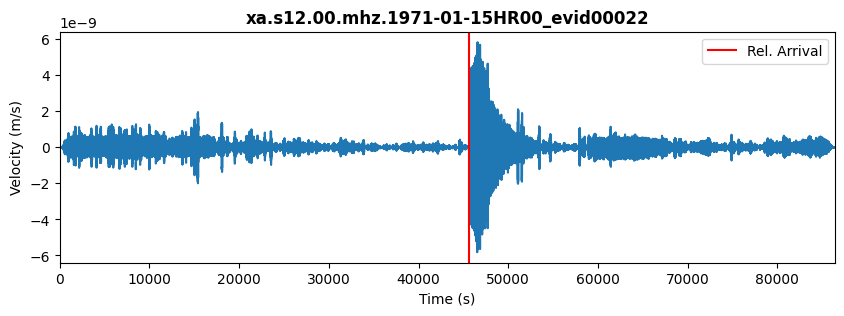

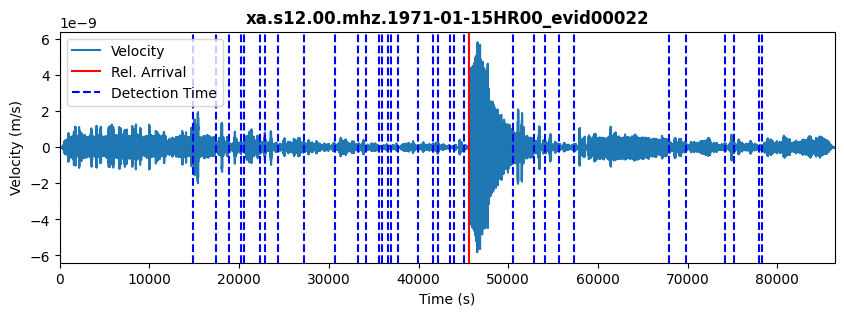

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1971-01-15 12:40:00
DataFrame de Scores:
    id                   time_abs score
0    1 1971-01-15 04:17:08.786302     6
1   23 1971-01-15 12:40:35.125925     4
2   28 1971-01-15 16:05:46.522151     4
3   24 1971-01-15 14:11:29.314604     4
4   26 1971-01-15 15:11:32.484415     2
5    4 1971-01-15 05:47:17.088189     1
6    6 1971-01-15 06:21:14.974981     1
7   25 1971-01-15 14:50:42.371208     1
8    5 1971-01-15 05:52:45.691962     1
9    3 1971-01-15 05:24:47.352340     0
10  13 1971-01-15 10:02:21.993849     0
11   7 1971-01-15 06:32:00.258000     0
12   2 1971-01-15 05:01:06.673094     0
13  22 1971-01-15 12:22:38.144792     0
14  19 1971-01-15 11:43:21.465547     0
15  17 1971-01-15 10:38:51.427811     0
16  34 1971-01-15 21:55:30.824038     0
17  12 1971-01-15 09:39:48.031585     0
18  29 1971-01-15 19:02:40.559887     0
19  15 1971-01-15 10:19:55.427811     0
20  20 1971-01-15 11:53:33.541019     0
21  30 1971-01-15 19:33:47.125925     0
22   0 

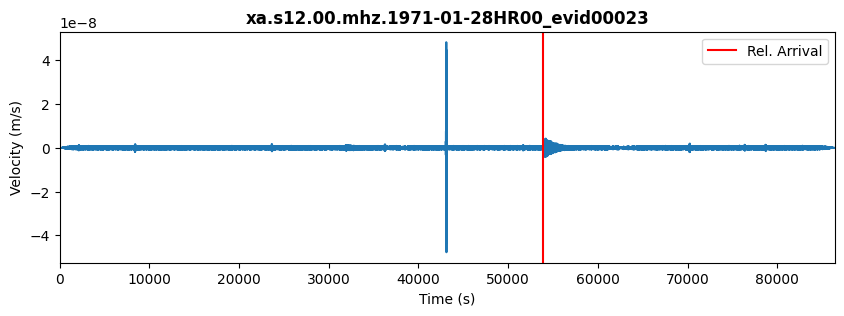

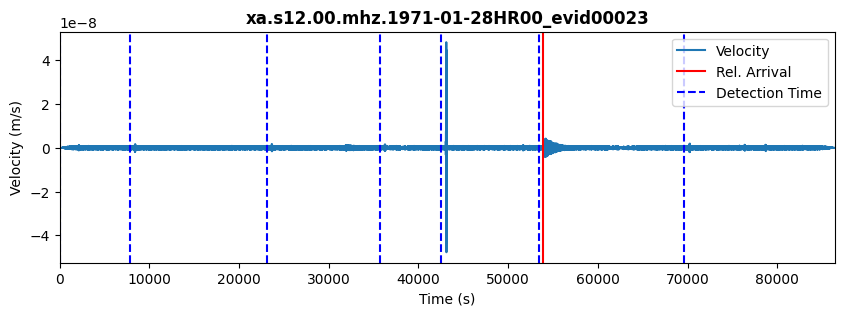

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1971-01-28 14:59:00
DataFrame de Scores:
  id                   time_abs score
0  4 1971-01-28 11:57:41.818906     6
1  2 1971-01-28 06:34:52.762302     5
2  3 1971-01-28 10:05:19.328340     5
3  5 1971-01-28 15:01:06.649094     5
4  1 1971-01-28 02:20:14.120792     2
5  6 1971-01-28 19:30:44.007585     1
6  0 1971-01-28 00:10:00.083057     0
Nombre del archivo: xa.s12.00.mhz.1971-01-29HR00_evid00024
Tiempo de llegada relativo: 66060.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-01-29T00:00:00.194000       0.000000  -1.157857e-15
1     1971-01-29T00:00:00.344943       0.150943  -1.449560e-15
2     1971-01-29T00:00:00.495887       0.301887  -1.574129e-15
3     1971-01-29T00:00:00.646830       0.452830  -1.516456e-15
4     1971-01-29T00:00:00.797774       0.603774  -1.335914e-15
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-01-29T00:00:00.194000       0.000000  -1.15

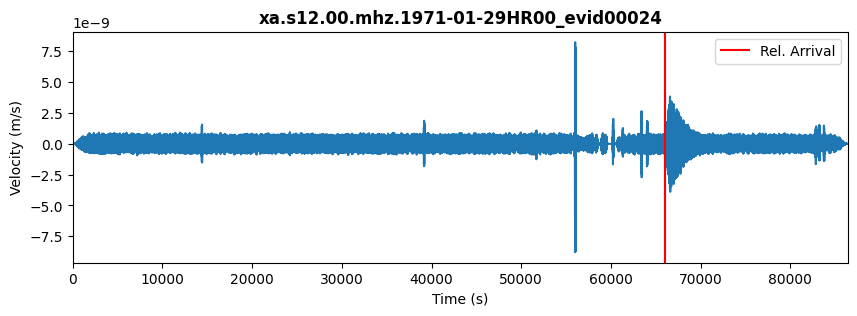

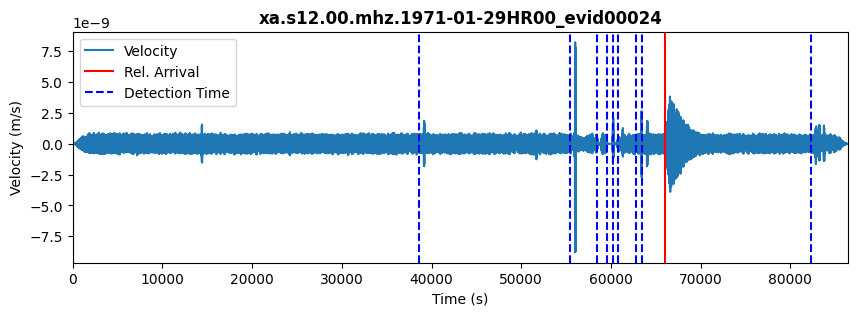

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1971-01-29 18:21:00
DataFrame de Scores:
  id                   time_abs score
0  6 1971-01-29 17:02:13.627962     4
1  9 1971-01-29 23:01:31.967585     4
2  2 1971-01-29 15:33:12.948717     4
3  4 1971-01-29 16:42:54.835509     3
4  8 1971-01-29 17:47:15.212868     3
5  1 1971-01-29 10:52:50.307208     3
6  3 1971-01-29 16:23:37.703434     2
7  7 1971-01-29 17:36:29.024189     1
8  5 1971-01-29 16:54:42.609094     0
9  0 1971-01-29 00:10:00.043057     0
Nombre del archivo: xa.s12.00.mhz.1971-02-09HR00_evid00026
Tiempo de llegada relativo: 13320.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-02-09T00:00:00.179000       0.000000   1.408148e-14
1     1971-02-09T00:00:00.329943       0.150943   1.751177e-14
2     1971-02-09T00:00:00.480887       0.301887   1.889360e-14
3     1971-02-09T00:00:00.631830       0.452830   1.802825e-14
4     1971-02-09T00:00:00.782774       0.603774   1.568145e-14
Datos limpios:
  t

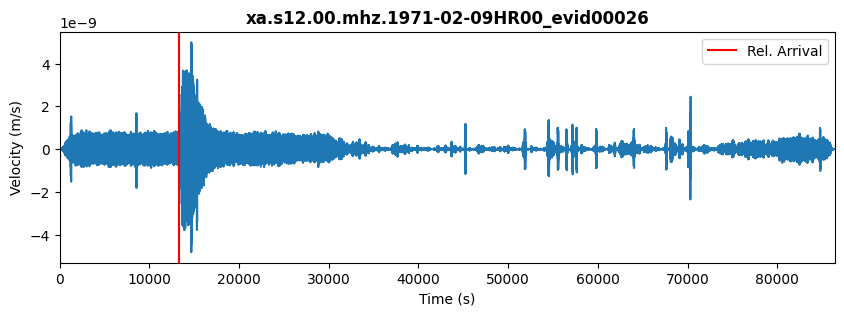

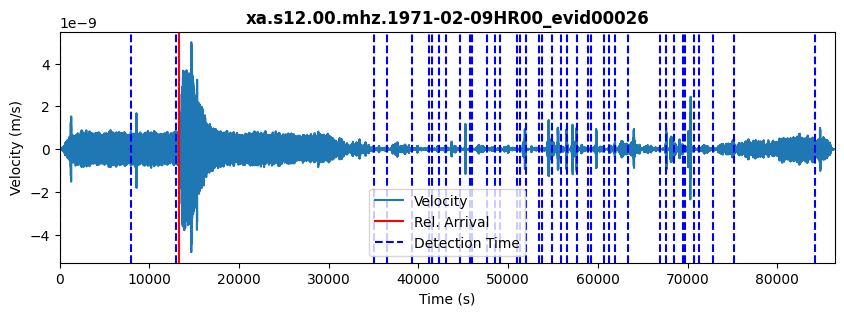

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1971-02-09 03:42:00
DataFrame de Scores:
    id                   time_abs score
0    0 1971-02-09 00:10:00.028057     4
1    2 1971-02-09 03:46:56.028057     4
2   17 1971-02-09 14:24:30.216736     3
3    1 1971-02-09 02:23:00.707302     3
4   40 1971-02-09 23:33:13.386547     2
5   30 1971-02-09 17:46:46.216736     2
6   31 1971-02-09 18:45:59.273340     2
7   20 1971-02-09 15:05:32.405415     2
8   34 1971-02-09 19:27:37.084660     1
9   25 1971-02-09 16:32:13.462019     1
10  15 1971-02-09 13:47:17.763906     0
11  29 1971-02-09 17:21:45.839377     0
12  39 1971-02-09 21:02:55.575226     0
13  23 1971-02-09 15:52:33.386547     0
14   6 1971-02-09 11:37:11.575226     0
15   5 1971-02-09 11:04:34.594094     0
16   9 1971-02-09 12:07:41.462019     0
17   8 1971-02-09 11:55:35.424283     0
18  24 1971-02-09 16:11:13.084660     0
19  10 1971-02-09 12:33:08.254472     0
20  33 1971-02-09 19:12:06.518623     0
21  22 1971-02-09 15:41:37.990321     0
22  35 

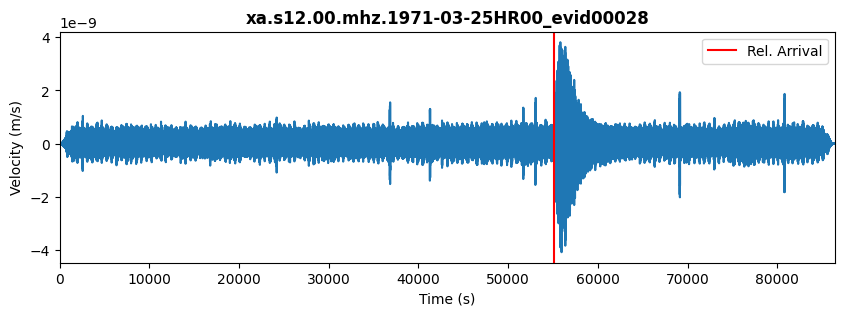

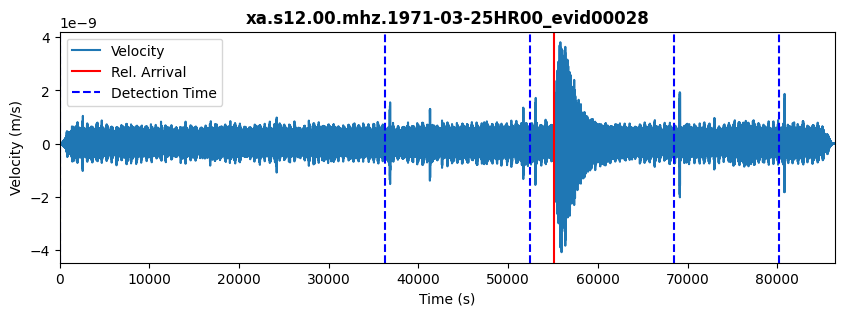

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1971-03-25 15:18:00
DataFrame de Scores:
  id                   time_abs score
0  3 1971-03-25 19:12:19.018925     5
1  1 1971-03-25 10:13:44.000057     5
2  2 1971-03-25 14:44:25.358547     5
3  4 1971-03-25 22:27:00.226472     5
4  0 1971-03-25 00:10:00.000057     4
Nombre del archivo: xa.s12.00.mhz.1971-04-13HR00_evid00029
Tiempo de llegada relativo: 46500.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-04-13T02:42:48.990062       0.000000  -5.252123e-16
1     1971-04-13T02:42:49.141005       0.150943  -6.721612e-16
2     1971-04-13T02:42:49.291949       0.301887  -7.467835e-16
3     1971-04-13T02:42:49.442892       0.452830  -7.225521e-16
4     1971-04-13T02:42:49.593836       0.603774  -6.229195e-16
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-04-13T02:42:48.990062       0.000000  -5.252123e-16
1     1971-04-13T02:42:49.141005       0.150943  -6.721612e-16
2   

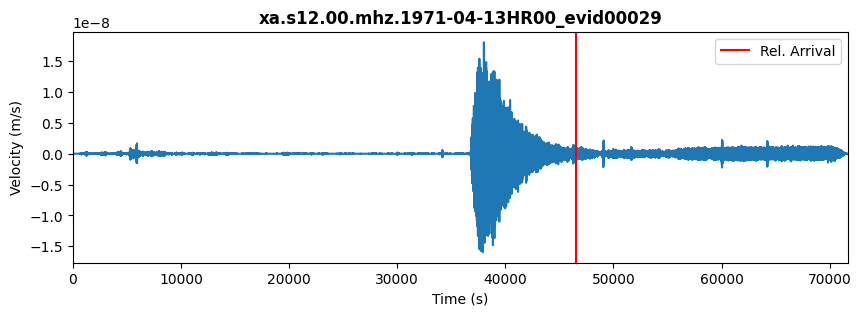

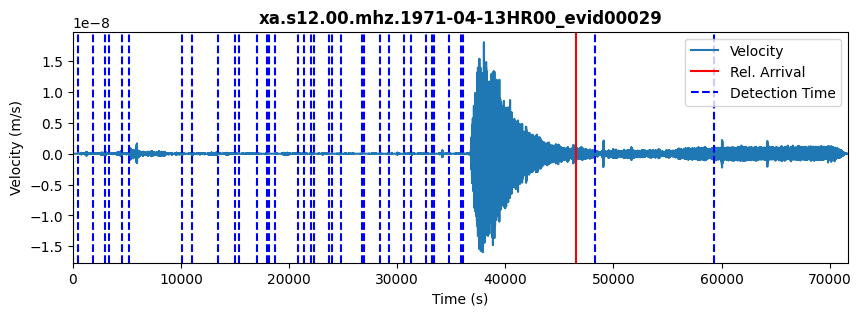

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1971-04-13 12:55:00
DataFrame de Scores:
    id                   time_abs score
0    6 1971-04-13 04:21:28.537232     5
1   36 1971-04-13 19:23:42.424024     5
2   34 1971-04-13 12:56:17.895722     4
3    5 1971-04-13 04:09:52.386288     4
4   35 1971-04-13 16:20:10.197609     3
5    9 1971-04-13 06:39:06.348553     1
6   30 1971-04-13 12:08:03.254213     1
7   16 1971-04-13 08:42:03.707043     1
8   18 1971-04-13 09:01:51.782515     0
9   21 1971-04-13 09:33:38.952326     0
10  14 1971-04-13 07:56:41.593836     0
11  11 1971-04-13 07:10:43.857987     0
12  23 1971-04-13 10:20:49.593836     0
13  20 1971-04-13 09:29:51.329685     0
14   3 1971-04-13 03:43:57.820251     0
15  13 1971-04-13 07:53:35.933458     0
16  24 1971-04-13 10:23:39.103270     0
17  26 1971-04-13 11:02:24.084402     0
18  33 1971-04-13 12:52:46.725911     0
19  31 1971-04-13 12:11:43.480628     0
20  22 1971-04-13 09:48:32.688175     0
21   8 1971-04-13 05:58:53.669307     0
22  17 

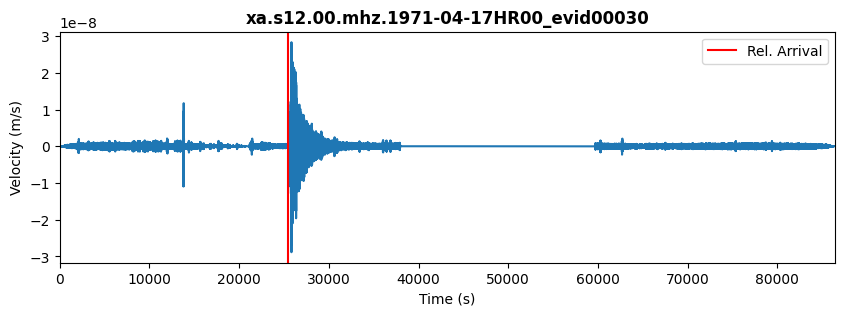

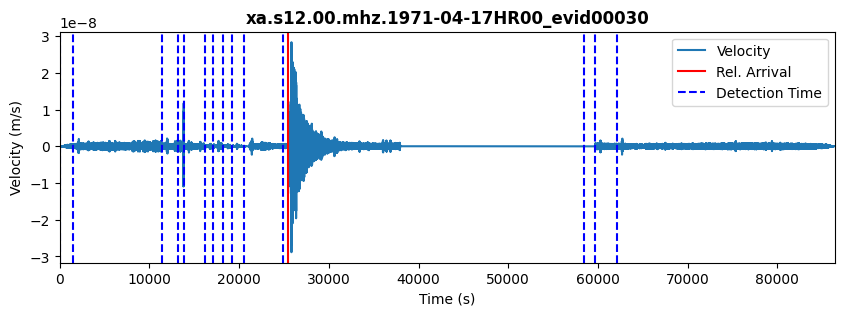

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1971-04-17 07:04:00
DataFrame de Scores:
    id                   time_abs score
0    3 1971-04-17 03:49:34.575679     5
1    1 1971-04-17 00:35:19.934170     3
2    9 1971-04-17 05:52:51.405868     3
3   10 1971-04-17 07:05:37.443604     3
4    4 1971-04-17 04:00:41.745491     2
5    5 1971-04-17 04:38:58.651151     2
6    7 1971-04-17 05:12:34.349264     2
7   12 1971-04-17 16:44:44.160585     2
8    6 1971-04-17 04:54:53.820962     1
9   13 1971-04-17 17:24:45.066245     1
10  11 1971-04-17 16:24:00.839830     0
11   0 1971-04-17 00:10:00.236057     0
12   8 1971-04-17 05:29:06.651151     0
13   2 1971-04-17 03:20:05.519075     0
Nombre del archivo: xa.s12.00.mhz.1971-05-12HR00_evid00031
Tiempo de llegada relativo: 29100.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-05-12T00:00:00.712000       0.000000  -6.579815e-16
1     1971-05-12T00:00:00.862943       0.150943  -8.333763e-16
2     1971-05-12T00:00:01

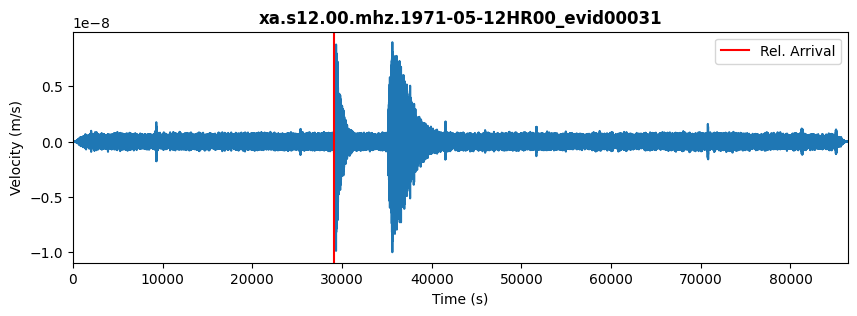

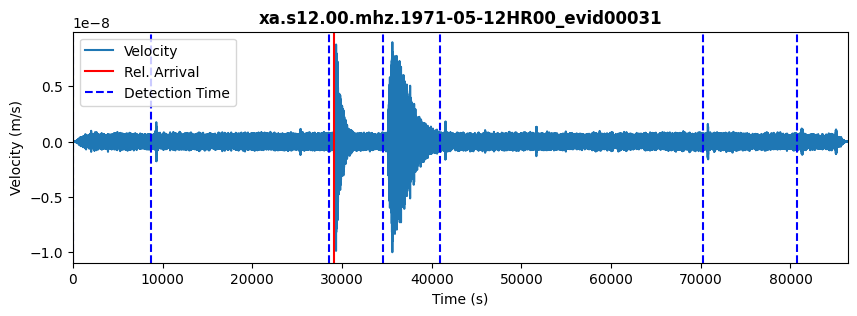

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1971-05-12 08:05:00
DataFrame de Scores:
  id                   time_abs score
0  2 1971-05-12 08:06:10.976151     6
1  3 1971-05-12 09:46:48.561057     5
2  4 1971-05-12 11:32:20.636528     4
3  6 1971-05-12 22:35:24.787472     4
4  1 1971-05-12 02:35:10.900679     3
5  5 1971-05-12 19:40:14.447849     2
6  0 1971-05-12 00:10:00.561057     0
Nombre del archivo: xa.s12.00.mhz.1971-05-12HR00_evid00032
Tiempo de llegada relativo: 35100.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-05-12T00:00:00.712000       0.000000  -6.579815e-16
1     1971-05-12T00:00:00.862943       0.150943  -8.333763e-16
2     1971-05-12T00:00:01.013887       0.301887  -9.389561e-16
3     1971-05-12T00:00:01.164830       0.452830  -9.307208e-16
4     1971-05-12T00:00:01.315774       0.603774  -8.207080e-16
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-05-12T00:00:00.712000       0.000000  -6.57

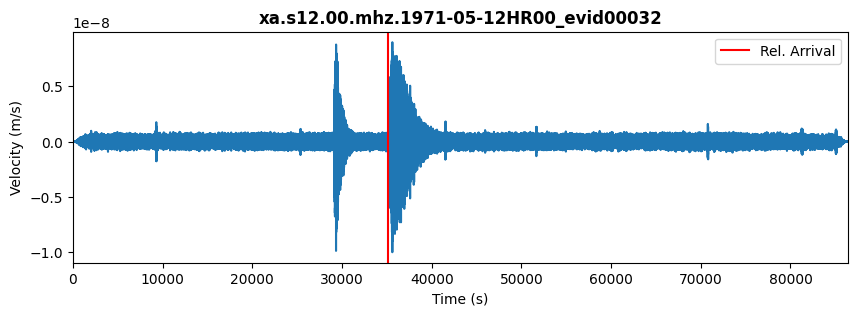

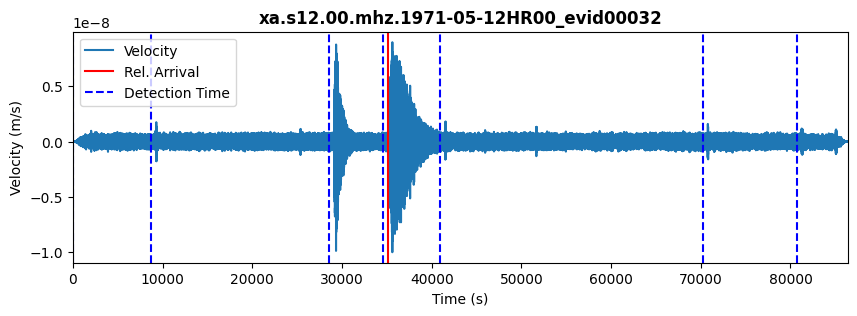

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1971-05-12 09:45:00
DataFrame de Scores:
  id                   time_abs score
0  2 1971-05-12 08:06:10.976151     6
1  3 1971-05-12 09:46:48.561057     5
2  4 1971-05-12 11:32:20.636528     4
3  6 1971-05-12 22:35:24.787472     4
4  1 1971-05-12 02:35:10.900679     3
5  5 1971-05-12 19:40:14.447849     2
6  0 1971-05-12 00:10:00.561057     0
Nombre del archivo: xa.s12.00.mhz.1971-05-13HR00_evid00033
Tiempo de llegada relativo: 10800.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-05-13T00:00:00.183000       0.000000  -7.861305e-16
1     1971-05-13T00:00:00.333943       0.150943  -1.002457e-15
2     1971-05-13T00:00:00.484887       0.301887  -1.090702e-15
3     1971-05-13T00:00:00.635830       0.452830  -1.030561e-15
4     1971-05-13T00:00:00.786774       0.603774  -8.714837e-16
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-05-13T00:00:00.183000       0.000000  -7.86

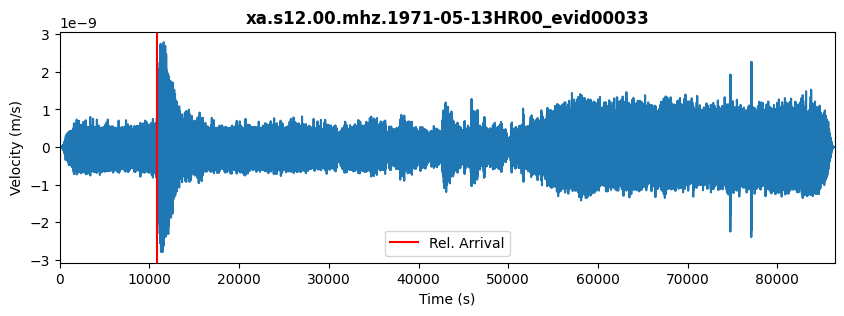

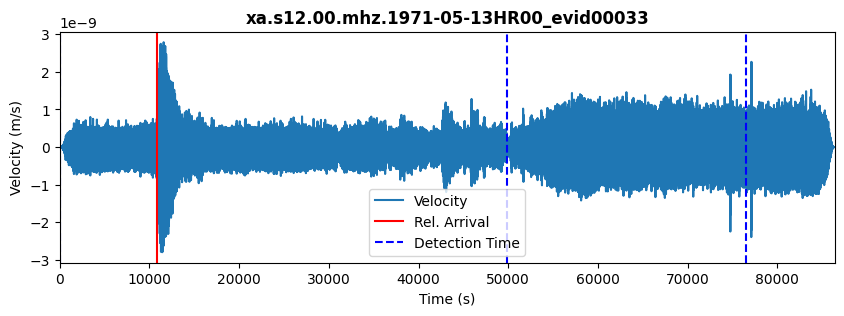

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1971-05-13 03:00:00
DataFrame de Scores:
  id                   time_abs score
0  2 1971-05-13 21:25:10.220736     7
1  0 1971-05-13 00:10:00.032057     7
2  1 1971-05-13 14:00:24.786774     6
Nombre del archivo: xa.s12.00.mhz.1971-05-23HR00_evid00034
Tiempo de llegada relativo: 80400.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-05-23T00:00:00.502000       0.000000  -5.969867e-16
1     1971-05-23T00:00:00.652943       0.150943  -7.427009e-16
2     1971-05-23T00:00:00.803887       0.301887  -8.060615e-16
3     1971-05-23T00:00:00.954830       0.452830  -7.803532e-16
4     1971-05-23T00:00:01.105774       0.603774  -6.963062e-16
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-05-23T00:00:00.502000       0.000000  -5.969867e-16
1     1971-05-23T00:00:00.652943       0.150943  -7.427009e-16
2     1971-05-23T00:00:00.803887       0.301887  -8.060615e-16
3     1971-05-23T

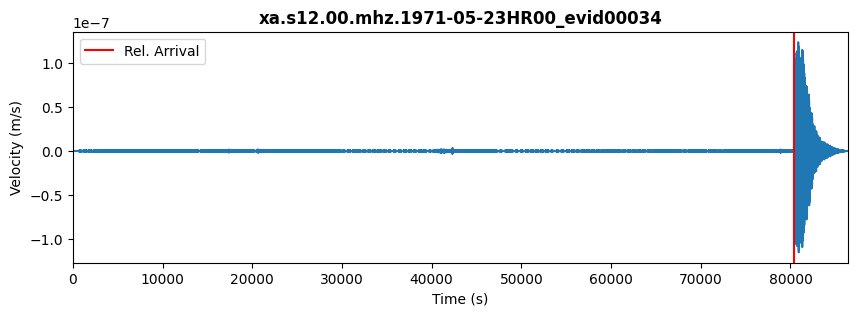

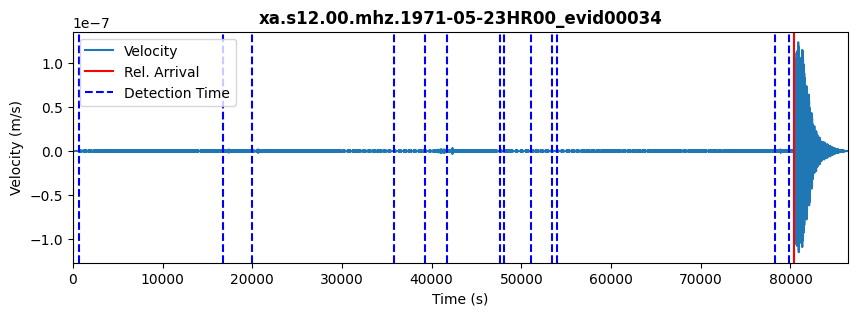

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1971-05-23 22:20:00
DataFrame de Scores:
    id                   time_abs score
0   13 1971-05-23 22:20:47.747283     8
1    5 1971-05-23 11:04:41.860491     4
2   12 1971-05-23 21:55:14.162377     3
3    6 1971-05-23 11:44:57.407660     3
4   10 1971-05-23 15:00:30.690679     2
5    2 1971-05-23 04:49:45.860491     2
6    9 1971-05-23 14:21:29.860491     1
7    8 1971-05-23 13:31:16.426528     1
8    3 1971-05-23 05:43:53.558604     0
9   11 1971-05-23 15:09:40.426528     0
10   7 1971-05-23 13:25:02.086906     0
11   1 1971-05-23 00:22:13.332189     0
12   0 1971-05-23 00:10:40.954830     0
13   4 1971-05-23 10:07:06.766151     0
Nombre del archivo: xa.s12.00.mhz.1971-06-12HR00_evid00035
Tiempo de llegada relativo: 39060.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-06-12T00:00:00.529000       0.000000  -1.886839e-15
1     1971-06-12T00:00:00.679943       0.150943  -2.585821e-15
2     1971-06-12T00:00:00

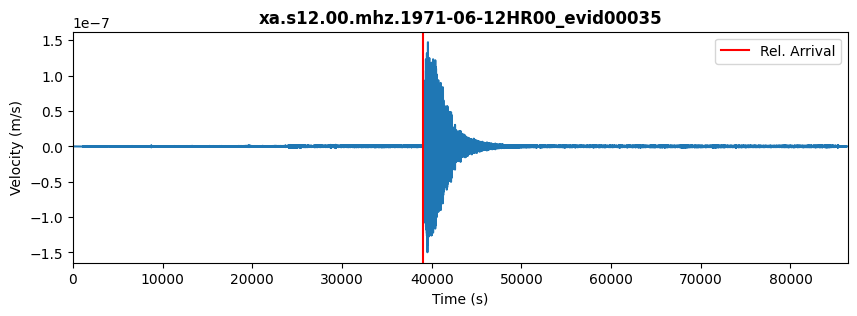

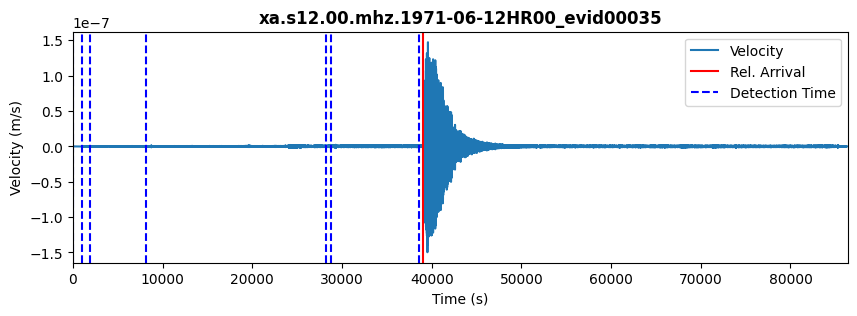

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1971-06-12 10:51:00
DataFrame de Scores:
  id                   time_abs score
0  6 1971-06-12 10:52:16.529000     7
1  5 1971-06-12 08:09:24.151642     6
2  4 1971-06-12 07:59:27.321453     4
3  1 1971-06-12 00:26:26.038434     3
4  2 1971-06-12 00:41:56.151642     2
5  3 1971-06-12 02:25:30.491264     2
6  0 1971-06-12 00:10:00.378057     0
Nombre del archivo: xa.s12.00.mhz.1971-09-25HR00_evid00042
Tiempo de llegada relativo: 32220.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-09-25T00:00:00.576000       0.000000  -2.511228e-16
1     1971-09-25T00:00:00.726943       0.150943  -2.756798e-16
2     1971-09-25T00:00:00.877887       0.301887  -2.653056e-16
3     1971-09-25T00:00:01.028830       0.452830  -2.387355e-16
4     1971-09-25T00:00:01.179774       0.603774  -2.168125e-16
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-09-25T00:00:00.576000       0.000000  -2.51

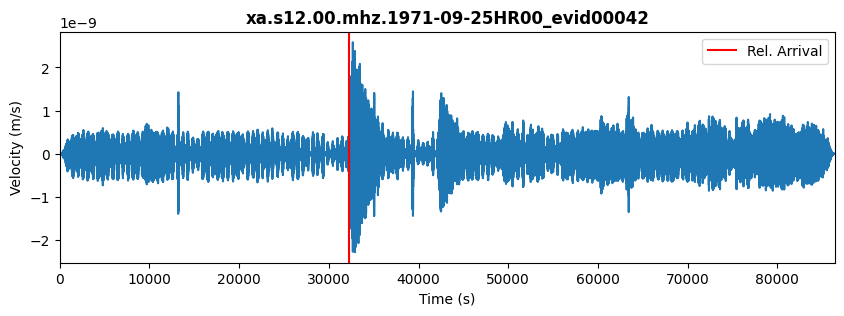

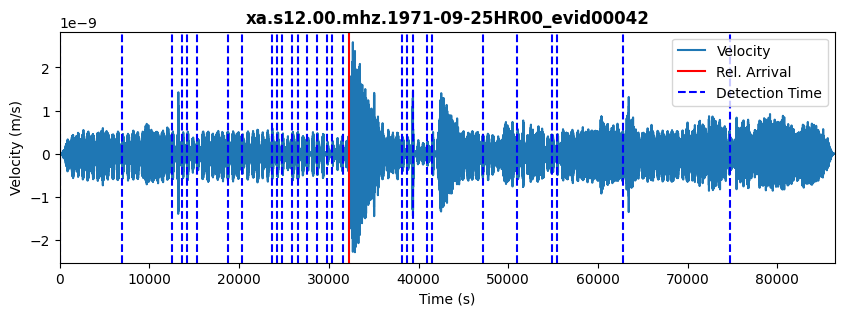

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1971-09-25 08:57:00
DataFrame de Scores:
    id                   time_abs score
0   27 1971-09-25 17:37:34.009962     4
1    0 1971-09-25 00:11:23.443925     3
2    2 1971-09-25 03:40:00.576000     3
3   17 1971-09-25 08:57:28.576000     3
4   22 1971-09-25 11:43:06.085434     2
5   24 1971-09-25 14:21:39.142038     2
6   23 1971-09-25 13:17:03.066566     2
7   11 1971-09-25 07:23:31.896755     2
8   19 1971-09-25 10:55:40.198642     2
9   28 1971-09-25 20:57:31.443925     1
10  25 1971-09-25 15:26:26.689208     0
11   1 1971-09-25 02:07:34.311849     0
12  18 1971-09-25 10:47:45.330717     0
13  20 1971-09-25 11:07:03.670340     0
14  21 1971-09-25 11:33:17.557132     0
15  14 1971-09-25 08:09:18.311849     0
16   8 1971-09-25 06:45:46.085434     0
17   5 1971-09-25 04:25:56.349585     0
18   9 1971-09-25 06:55:29.783547     0
19  10 1971-09-25 07:04:56.726943     0
20  15 1971-09-25 08:28:05.255245     0
21   4 1971-09-25 04:08:36.802415     0
22  16 

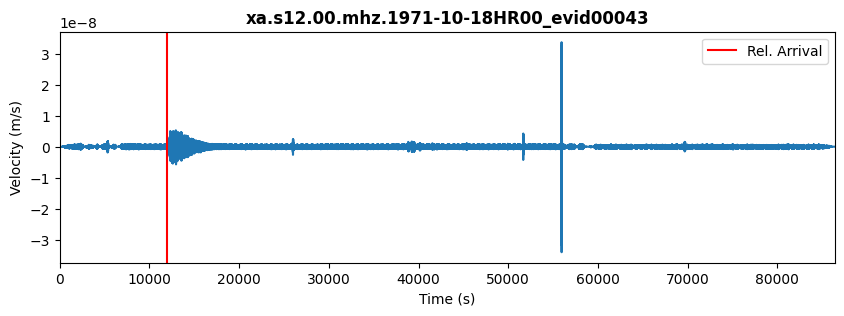

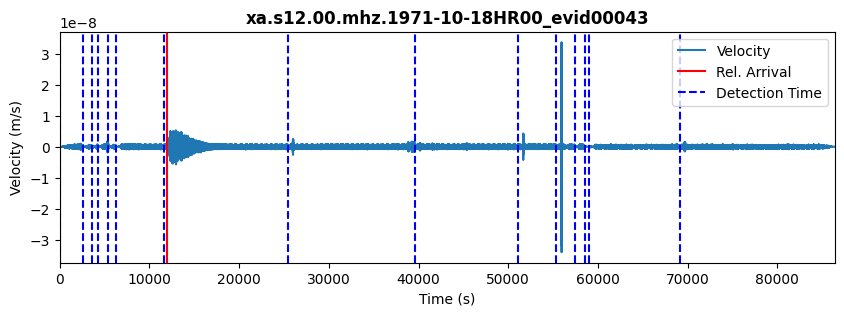

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1971-10-18 03:19:00
DataFrame de Scores:
    id                   time_abs score
0    6 1971-10-18 03:23:00.945302     5
1   10 1971-10-18 15:31:35.662283     5
2    8 1971-10-18 11:10:19.284925     4
3    5 1971-10-18 01:53:33.850962     2
4    1 1971-10-18 00:53:38.681151     2
5    7 1971-10-18 07:13:11.813226     2
6   14 1971-10-18 19:21:55.888698     2
7   12 1971-10-18 16:25:01.398132     1
8    4 1971-10-18 01:40:11.133981     1
9    0 1971-10-18 00:10:00.266057     0
10  13 1971-10-18 16:33:46.379264     0
11   3 1971-10-18 01:20:09.171717     0
12  11 1971-10-18 16:06:45.247189     0
13   2 1971-10-18 01:09:14.681151     0
14   9 1971-10-18 14:21:02.001906     0
Nombre del archivo: xa.s12.00.mhz.1971-10-20HR00_evid00044
Tiempo de llegada relativo: 65280.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-10-20T00:00:00.425000       0.000000  -3.337540e-15
1     1971-10-20T00:00:00.575943       0.150943 

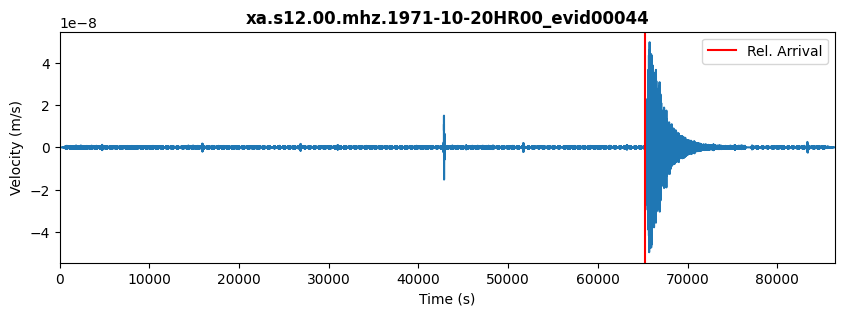

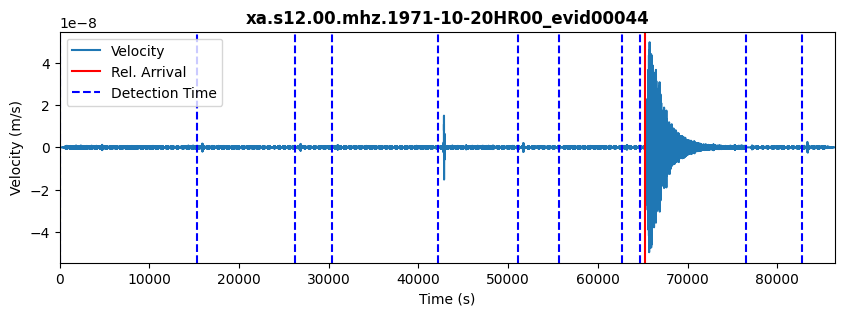

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1971-10-20 18:08:00
DataFrame de Scores:
    id                   time_abs score
0    8 1971-10-20 18:08:40.877830     5
1    7 1971-10-20 17:34:30.160849     5
2    9 1971-10-20 21:24:59.594811     4
3    4 1971-10-20 11:53:26.009906     3
4    1 1971-10-20 04:24:56.575943     2
5    3 1971-10-20 08:36:43.896698     2
6    2 1971-10-20 07:27:24.198585     1
7   10 1971-10-20 23:09:12.726887     1
8    0 1971-10-20 00:10:00.274057     1
9    5 1971-10-20 14:21:10.009906     0
10   6 1971-10-20 15:38:36.500472     0
Nombre del archivo: xa.s12.00.mhz.1971-10-31HR00_evid00045
Tiempo de llegada relativo: 19800.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1971-10-31T00:00:00.420000       0.000000  -3.274307e-16
1     1971-10-31T00:00:00.570943       0.150943  -3.921284e-16
2     1971-10-31T00:00:00.721887       0.301887  -4.042489e-16
3     1971-10-31T00:00:00.872830       0.452830  -3.730939e-16
4     1971-10-31T00

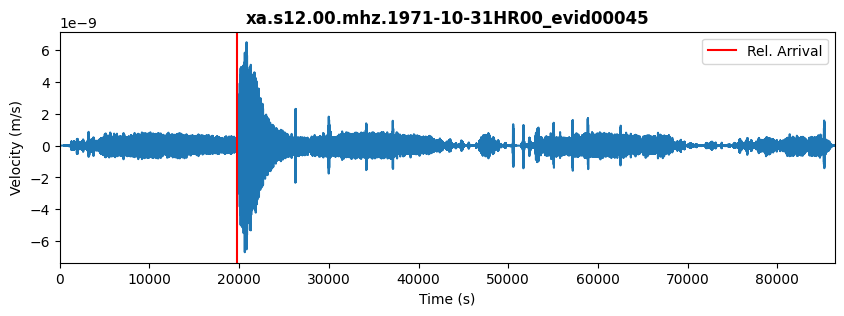

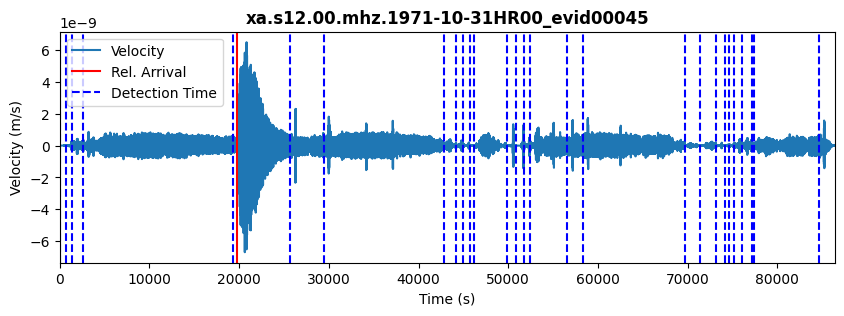

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1971-10-31 05:30:00
DataFrame de Scores:
    id                   time_abs score
0   17 1971-10-31 16:21:53.174717     6
1    4 1971-10-31 05:31:48.495472     4
2   27 1971-10-31 23:40:48.269057     4
3    5 1971-10-31 07:17:51.061509     3
4    2 1971-10-31 00:33:27.363396     2
5   13 1971-10-31 14:17:33.853962     2
6   12 1971-10-31 14:01:50.457736     1
7   15 1971-10-31 14:44:28.193585     1
8    3 1971-10-31 00:53:32.193585     1
9   25 1971-10-31 21:35:47.136981     0
10  19 1971-10-31 20:00:05.099245     0
11  14 1971-10-31 14:32:16.721887     0
12   6 1971-10-31 08:20:23.816226     0
13  11 1971-10-31 12:59:51.967170     0
14  21 1971-10-31 20:45:19.816226     0
15  16 1971-10-31 15:53:13.174717     0
16  20 1971-10-31 20:29:13.778491     0
17   9 1971-10-31 12:39:49.552075     0
18   0 1971-10-31 00:10:00.269057     0
19  23 1971-10-31 21:03:00.495472     0
20  18 1971-10-31 19:31:44.118113     0
21   8 1971-10-31 12:25:54.835094     0
22  22 

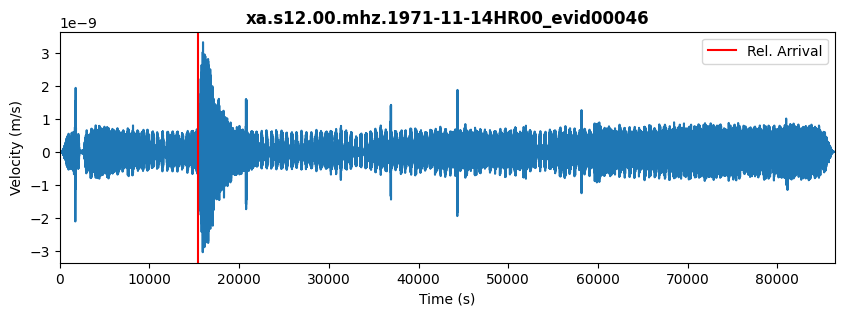

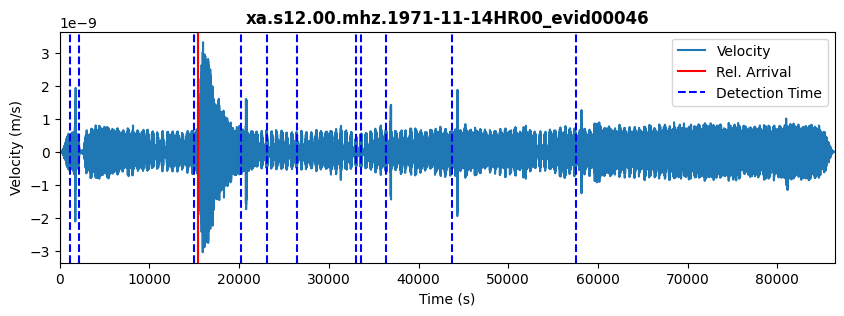

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1971-11-14 04:17:00
DataFrame de Scores:
    id                   time_abs score
0    4 1971-11-14 05:46:20.979358     4
1   10 1971-11-14 12:18:53.734075     4
2    1 1971-11-14 00:28:47.847283     4
3   11 1971-11-14 16:09:15.620868     3
4    2 1971-11-14 00:45:58.488792     3
5    9 1971-11-14 10:15:27.847283     3
6    3 1971-11-14 04:19:52.752943     2
7    0 1971-11-14 00:10:00.451057     1
8    6 1971-11-14 07:30:02.413321     0
9    7 1971-11-14 09:20:11.469925     0
10   5 1971-11-14 06:34:17.507660     0
11   8 1971-11-14 09:29:36.602000     0
Nombre del archivo: xa.s12.00.mhz.1972-01-04HR00_evid00049
Tiempo de llegada relativo: 23700.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1972-01-04T00:00:00.117000       0.000000  -7.561720e-16
1     1972-01-04T00:00:00.267943       0.150943  -9.283696e-16
2     1972-01-04T00:00:00.418887       0.301887  -1.011575e-15
3     1972-01-04T00:00:00.569830       0.4

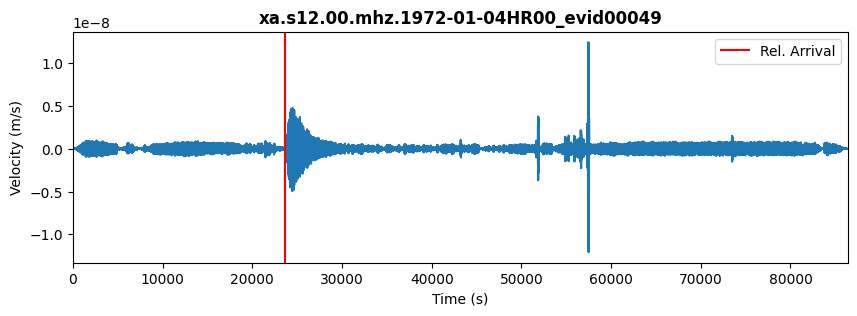

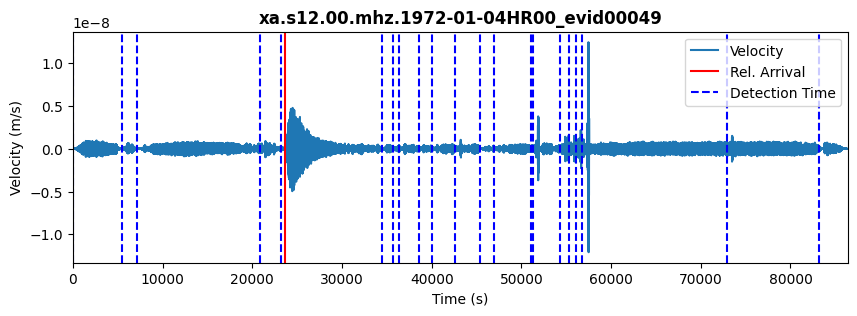

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1972-01-04 06:35:00
DataFrame de Scores:
    id                   time_abs score
0   17 1972-01-04 15:44:22.758509     4
1    4 1972-01-04 06:36:19.588698     4
2   18 1972-01-04 15:56:16.871717     4
3   14 1972-01-04 14:24:20.192472     3
4    1 1972-01-04 01:40:26.079264     2
5   19 1972-01-04 20:25:14.683038     2
6   13 1972-01-04 14:21:14.079264     2
7   20 1972-01-04 23:17:01.400019     1
8    7 1972-01-04 10:16:13.852849     1
9    3 1972-01-04 05:57:51.362283     1
10  10 1972-01-04 12:00:35.286811     0
11   2 1972-01-04 02:09:21.173604     0
12   9 1972-01-04 11:16:44.494358     0
13  16 1972-01-04 15:31:55.437755     0
14  15 1972-01-04 15:15:04.871717     0
15  11 1972-01-04 12:46:47.060396     0
16   6 1972-01-04 10:04:47.060396     0
17   8 1972-01-04 10:52:37.701906     0
18  12 1972-01-04 13:12:49.928321     0
19   5 1972-01-04 09:43:34.909453     0
20   0 1972-01-04 00:09:59.966057     0
Nombre del archivo: xa.s12.00.mhz.1972-03-12HR0

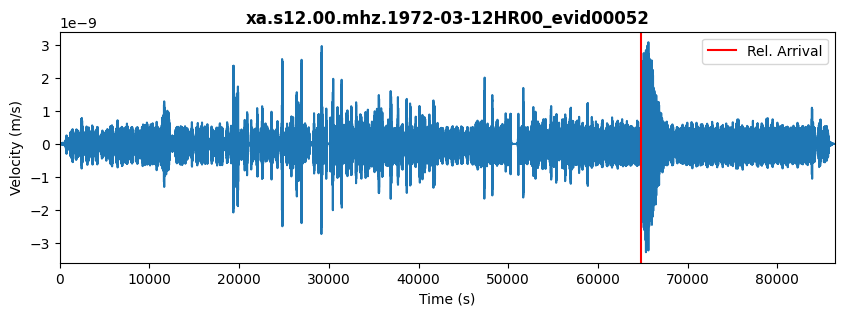

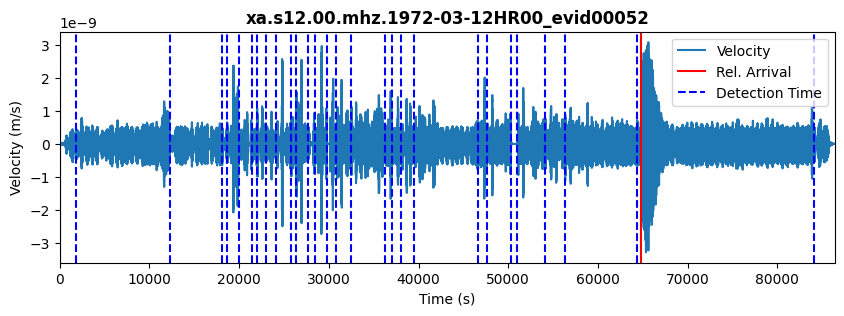

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1972-03-12 18:00:00
DataFrame de Scores:
    id                   time_abs score
0    5 1972-03-12 05:43:35.058509     4
1   11 1972-03-12 07:29:17.247189     3
2   18 1972-03-12 10:28:47.662283     2
3   14 1972-03-12 08:27:18.605679     2
4   27 1972-03-12 18:03:43.511340     2
5    7 1972-03-12 06:17:21.775491     2
6   17 1972-03-12 10:14:51.586811     2
7   10 1972-03-12 07:20:27.435868     2
8    2 1972-03-12 03:35:46.983038     1
9   24 1972-03-12 14:21:13.322660     1
10  15 1972-03-12 08:43:44.115113     1
11  25 1972-03-12 15:12:53.700019     1
12   9 1972-03-12 06:52:51.435868     1
13  19 1972-03-12 10:44:42.983038     0
14  21 1972-03-12 13:08:51.586811     0
15  13 1972-03-12 08:05:54.983038     0
16  23 1972-03-12 14:09:57.247189     0
17  26 1972-03-12 15:49:43.209453     0
18   6 1972-03-12 06:07:43.511340     0
19   4 1972-03-12 05:22:12.492472     0
20   3 1972-03-12 05:11:40.039642     0
21   8 1972-03-12 06:33:15.586811     0
22   1 

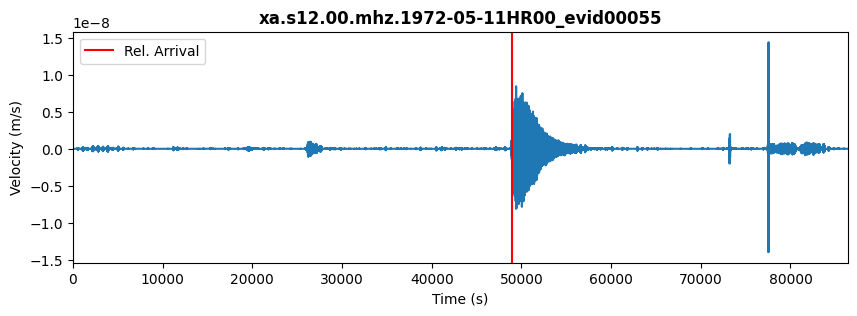

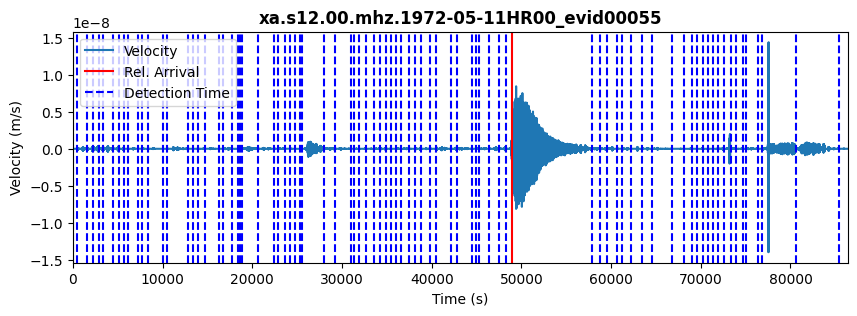

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1972-05-11 13:35:00
DataFrame de Scores:
    id                   time_abs score
0   80 1972-05-11 21:31:08.349585     6
1    4 1972-05-11 00:57:39.142038     5
2   57 1972-05-11 13:34:21.708075     3
3    3 1972-05-11 00:47:36.123170     3
4   81 1972-05-11 22:32:52.953358     2
..  ..                        ...   ...
78  28 1972-05-11 06:43:13.783547     0
79   6 1972-05-11 01:24:02.236377     0
80  79 1972-05-11 21:22:15.670340     0
81  59 1972-05-11 16:30:00.274113     0
82  15 1972-05-11 03:43:38.085434     0

[83 rows x 3 columns]
Nombre del archivo: xa.s12.00.mhz.1972-06-16HR00_evid00060
Tiempo de llegada relativo: 58260.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1972-06-16T00:00:00.116000       0.000000  -1.624317e-14
1     1972-06-16T00:00:00.266943       0.150943  -2.035202e-14
2     1972-06-16T00:00:00.417887       0.301887  -2.220952e-14
3     1972-06-16T00:00:00.568830       0.452830  -2.142301e

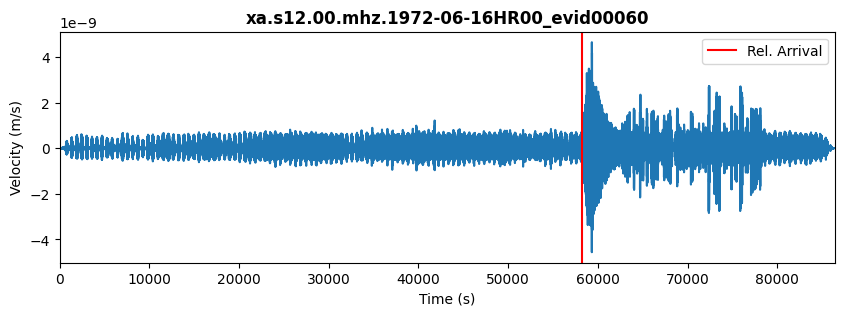

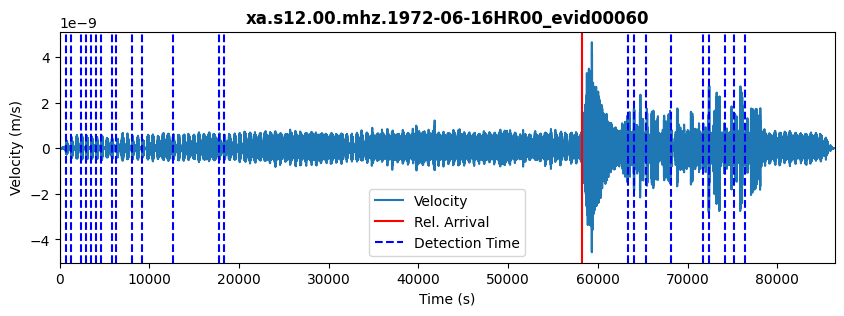

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1972-06-16 16:11:00
DataFrame de Scores:
    id                   time_abs score
0   19 1972-06-16 20:06:07.965057     4
1   21 1972-06-16 20:48:20.795245     3
2   16 1972-06-16 17:59:09.399019     3
3   20 1972-06-16 20:17:02.153736     3
4   17 1972-06-16 18:21:40.795245     2
5   18 1972-06-16 19:07:20.870717     2
6   22 1972-06-16 21:04:58.832981     2
7    3 1972-06-16 00:51:36.719774     2
8    0 1972-06-16 00:11:21.021660     1
9    4 1972-06-16 01:01:08.795245     1
10  15 1972-06-16 17:47:29.172604     1
11  14 1972-06-16 05:16:11.134868     0
12   8 1972-06-16 01:48:12.342415     0
13  13 1972-06-16 05:07:22.682038     0
14  23 1972-06-16 21:25:03.512226     0
15  11 1972-06-16 02:44:18.078264     0
16   5 1972-06-16 01:10:10.380151     0
17   1 1972-06-16 00:22:33.625434     0
18   9 1972-06-16 01:56:43.436755     0
19   6 1972-06-16 01:19:29.172604     0
20   7 1972-06-16 01:28:50.380151     0
21  10 1972-06-16 02:25:49.700906     0
22   2 

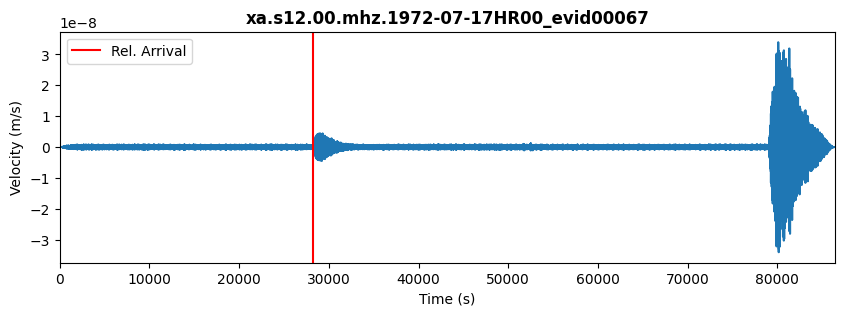

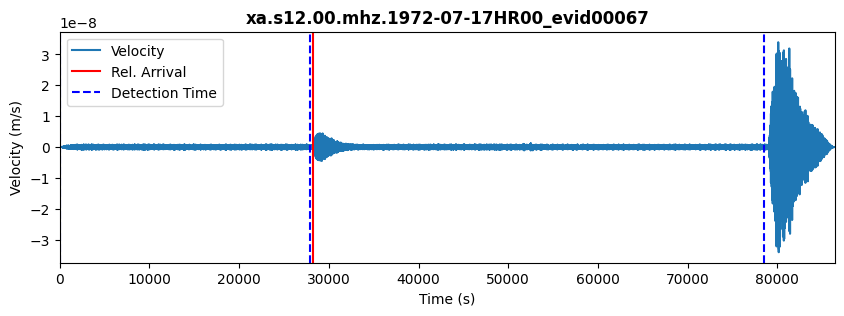

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1972-07-17 07:50:00
DataFrame de Scores:
  id                   time_abs score
0  2 1972-07-17 21:58:49.089660     8
1  0 1972-07-17 00:10:00.033057     7
2  1 1972-07-17 07:54:22.523623     5
Nombre del archivo: xa.s12.00.mhz.1972-07-17HR00_evid00068
Tiempo de llegada relativo: 78960.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1972-07-17T00:00:00.184000       0.000000  -1.589807e-15
1     1972-07-17T00:00:00.334943       0.150943  -1.979819e-15
2     1972-07-17T00:00:00.485887       0.301887  -2.136091e-15
3     1972-07-17T00:00:00.636830       0.452830  -2.039691e-15
4     1972-07-17T00:00:00.787774       0.603774  -1.780725e-15
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1972-07-17T00:00:00.184000       0.000000  -1.589807e-15
1     1972-07-17T00:00:00.334943       0.150943  -1.979819e-15
2     1972-07-17T00:00:00.485887       0.301887  -2.136091e-15
3     1972-07-17T

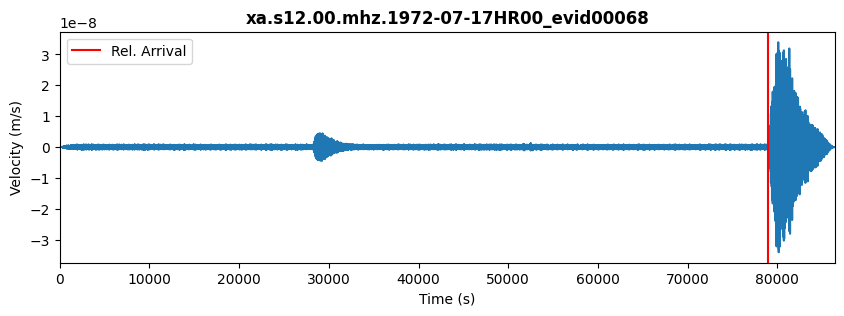

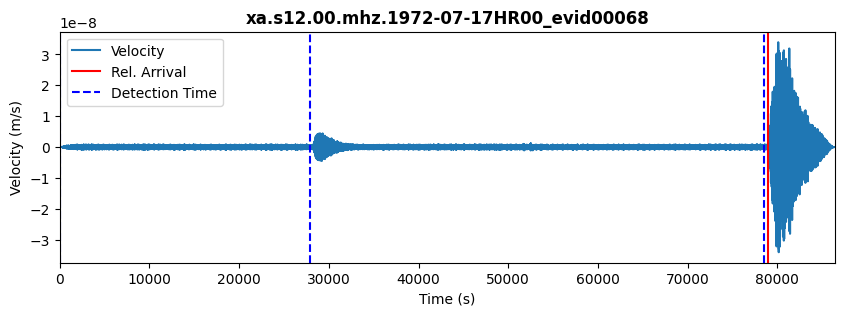

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1972-07-17 21:56:00
DataFrame de Scores:
  id                   time_abs score
0  2 1972-07-17 21:58:49.089660     8
1  0 1972-07-17 00:10:00.033057     7
2  1 1972-07-17 07:54:22.523623     5
Nombre del archivo: xa.s12.00.mhz.1972-07-28HR00_evid00070
Tiempo de llegada relativo: 8580.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1972-07-28T00:00:00.136000       0.000000  -8.299010e-17
1     1972-07-28T00:00:00.286943       0.150943  -1.080796e-16
2     1972-07-28T00:00:00.437887       0.301887  -1.221759e-16
3     1972-07-28T00:00:00.588830       0.452830  -1.141018e-16
4     1972-07-28T00:00:00.739774       0.603774  -9.012551e-17
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1972-07-28T00:00:00.136000       0.000000  -8.299010e-17
1     1972-07-28T00:00:00.286943       0.150943  -1.080796e-16
2     1972-07-28T00:00:00.437887       0.301887  -1.221759e-16
3     1972-07-28T0

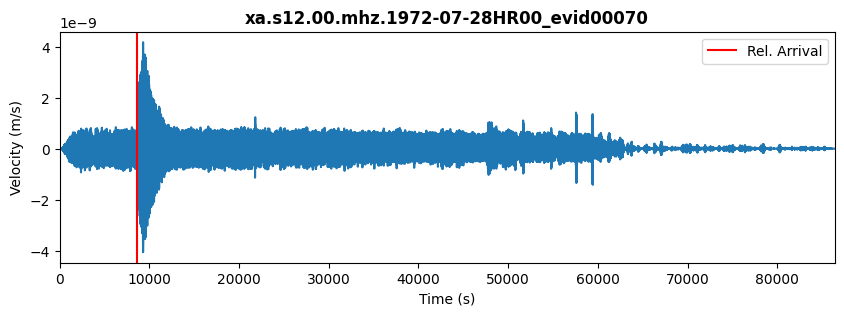

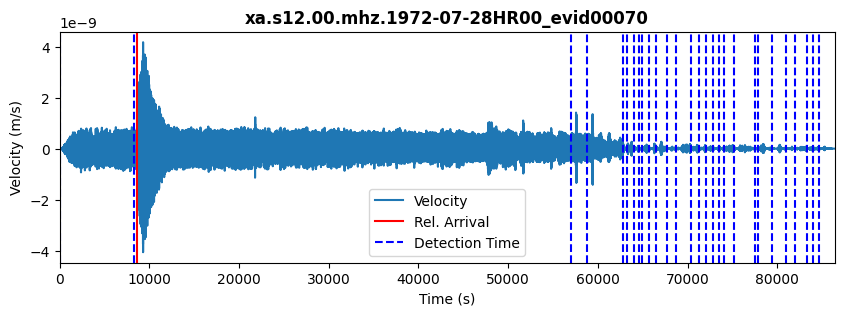

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1972-07-28 02:23:00
DataFrame de Scores:
    id                   time_abs score
0    3 1972-07-28 16:30:15.230340     6
1    1 1972-07-28 02:27:15.909585     5
2   18 1972-07-28 20:45:10.022792     4
3    2 1972-07-28 15:59:46.551094     3
4    0 1972-07-28 00:09:59.985057     2
5    5 1972-07-28 17:43:45.947321     2
6   11 1972-07-28 18:58:14.626566     2
7    6 1972-07-28 17:56:31.985057     0
8   22 1972-07-28 22:14:25.645434     0
9   10 1972-07-28 18:37:13.343547     0
10  15 1972-07-28 20:10:06.626566     0
11   9 1972-07-28 18:24:46.324679     0
12  20 1972-07-28 21:42:36.211472     0
13  24 1972-07-28 22:56:29.871849     0
14  14 1972-07-28 19:58:46.324679     0
15  27 1972-07-28 23:40:57.796377     0
16  16 1972-07-28 20:24:39.079396     0
17   7 1972-07-28 18:07:08.815245     0
18  19 1972-07-28 21:03:38.400151     0
19  26 1972-07-28 23:29:23.305811     0
20  23 1972-07-28 22:40:16.890717     0
21  25 1972-07-28 23:18:54.022792     0
22  17 

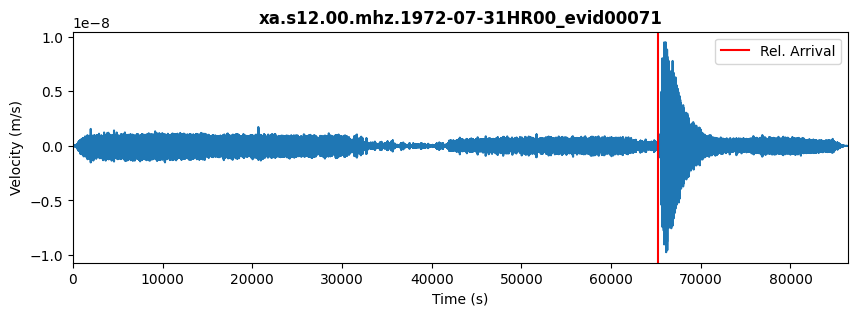

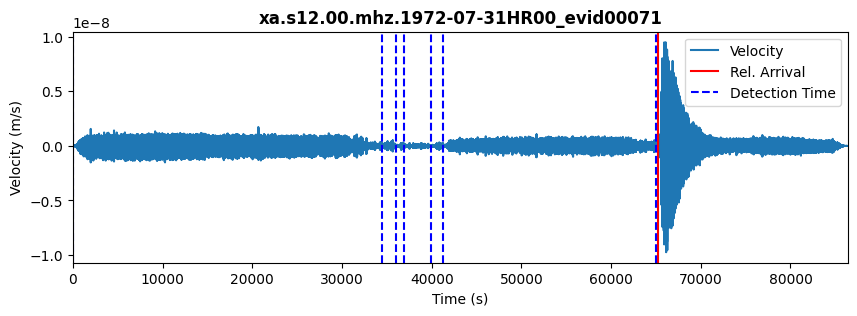

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1972-07-31 18:08:00
DataFrame de Scores:
  id                   time_abs score
0  0 1972-07-31 00:10:00.471057     6
1  6 1972-07-31 18:12:36.244642     6
2  3 1972-07-31 10:25:41.301245     4
3  1 1972-07-31 09:45:05.829547     4
4  2 1972-07-31 10:10:15.112566     3
5  5 1972-07-31 11:38:36.546528     1
6  4 1972-07-31 11:15:57.301245     0
Nombre del archivo: xa.s12.00.mhz.1972-12-02HR00_evid00083
Tiempo de llegada relativo: 28680.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1972-12-02T00:00:00.439000       0.000000  -1.484792e-16
1     1972-12-02T00:00:00.589943       0.150943  -2.193241e-16
2     1972-12-02T00:00:00.740887       0.301887  -2.549415e-16
3     1972-12-02T00:00:00.891830       0.452830  -2.347106e-16
4     1972-12-02T00:00:01.042774       0.603774  -1.778523e-16
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1972-12-02T00:00:00.439000       0.000000  -1.48

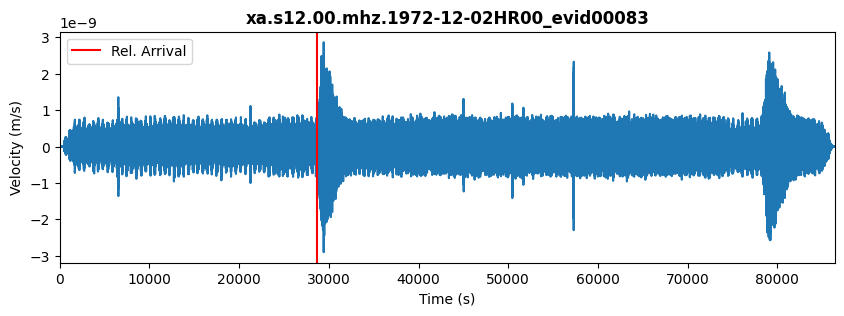

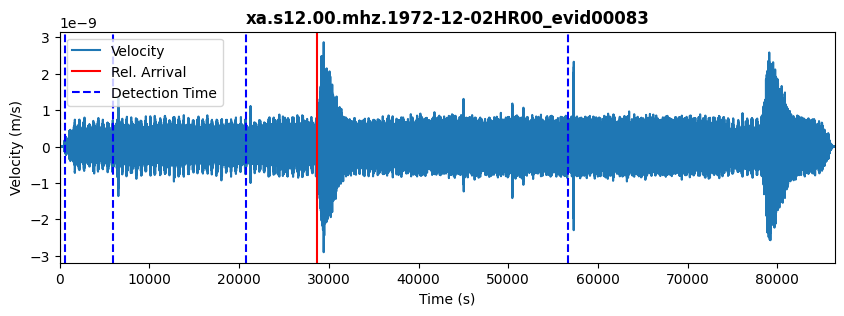

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1972-12-02 07:58:00
DataFrame de Scores:
  id                   time_abs score
0  3 1972-12-02 05:55:23.608811     7
1  4 1972-12-02 15:54:51.759755     6
2  2 1972-12-02 01:48:51.759755     5
3  0 1972-12-02 00:10:00.288057     4
4  1 1972-12-02 00:18:54.325792     2
Nombre del archivo: xa.s12.00.mhz.1972-12-03HR00_evid00084
Tiempo de llegada relativo: 9480.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1972-12-03T00:00:00.552000       0.000000  -3.763009e-14
1     1972-12-03T00:00:00.702943       0.150943  -4.707269e-14
2     1972-12-03T00:00:00.853887       0.301887  -5.131388e-14
3     1972-12-03T00:00:01.004830       0.452830  -4.948213e-14
4     1972-12-03T00:00:01.155774       0.603774  -4.337948e-14
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1972-12-03T00:00:00.552000       0.000000  -3.763009e-14
1     1972-12-03T00:00:00.702943       0.150943  -4.707269e-14
2    

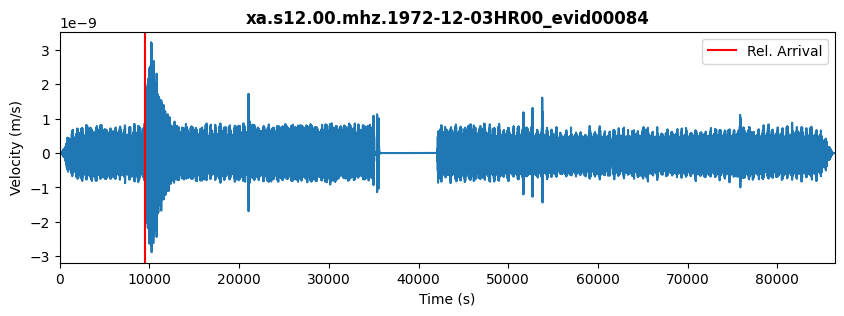

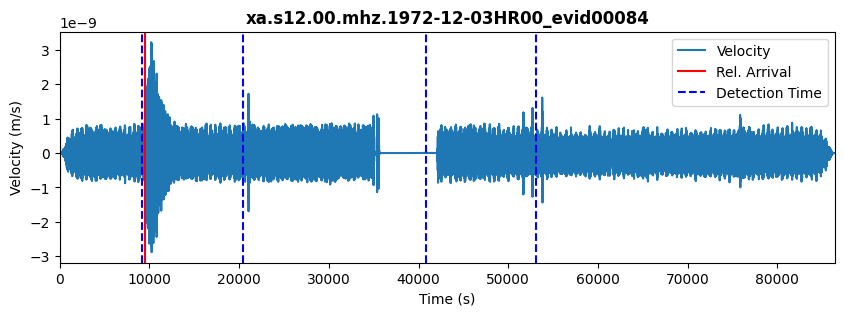

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1972-12-03 02:38:00
DataFrame de Scores:
  id                   time_abs score
0  4 1972-12-03 14:56:44.174642     7
1  1 1972-12-03 02:44:37.231245     6
2  2 1972-12-03 05:50:34.967094     5
3  0 1972-12-03 00:11:00.778415     4
4  3 1972-12-03 11:32:01.910491     2
Nombre del archivo: xa.s12.00.mhz.1973-01-18HR00_evid00088
Tiempo de llegada relativo: 82860.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1973-01-18T00:00:00.662000       0.000000   7.681935e-16
1     1973-01-18T00:00:00.812943       0.150943   9.605600e-16
2     1973-01-18T00:00:00.963887       0.301887   1.040080e-15
3     1973-01-18T00:00:01.114830       0.452830   9.882331e-16
4     1973-01-18T00:00:01.265774       0.603774   8.492824e-16
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1973-01-18T00:00:00.662000       0.000000   7.681935e-16
1     1973-01-18T00:00:00.812943       0.150943   9.605600e-16
2   

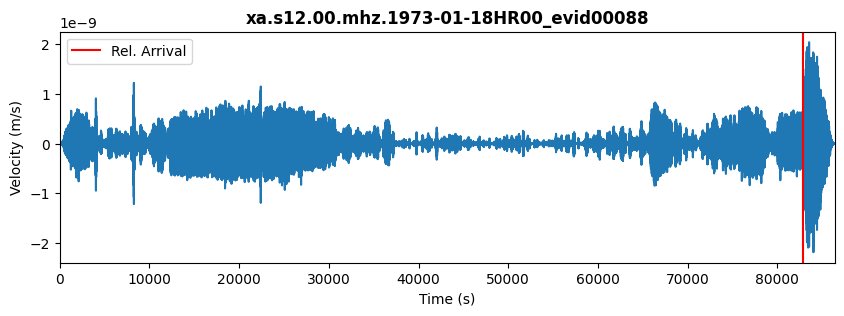

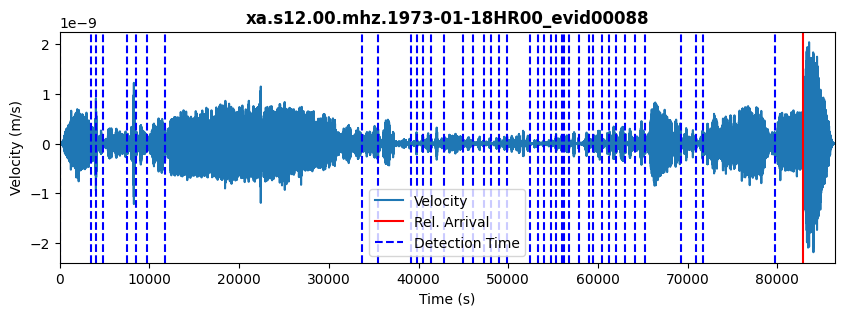

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1973-01-18 23:01:00
DataFrame de Scores:
    id                   time_abs score
0    4 1973-01-18 02:14:03.680868     4
1    1 1973-01-18 01:07:11.907283     3
2    3 1973-01-18 01:29:46.171434     2
3    9 1973-01-18 10:01:48.737472     2
4    5 1973-01-18 02:31:28.209170     2
5   13 1973-01-18 11:39:05.114830     2
6   20 1973-01-18 14:01:10.246906     2
7    2 1973-01-18 01:17:55.831811     1
8   40 1973-01-18 20:04:40.058226     1
9    7 1973-01-18 03:26:12.737472     1
10  37 1973-01-18 18:17:42.850679     1
11   0 1973-01-18 00:10:00.511057     1
12   8 1973-01-18 09:31:15.831811     1
13  26 1973-01-18 15:42:34.926151     1
14  14 1973-01-18 12:04:31.454453     0
15  12 1973-01-18 11:24:58.926151     0
16  30 1973-01-18 16:32:44.284642     0
17  41 1973-01-18 22:18:34.624264     0
18  36 1973-01-18 17:59:15.378981     0
19  10 1973-01-18 11:02:15.454453     0
20  34 1973-01-18 17:23:15.982755     0
21  31 1973-01-18 16:41:05.265774     0
22  35 

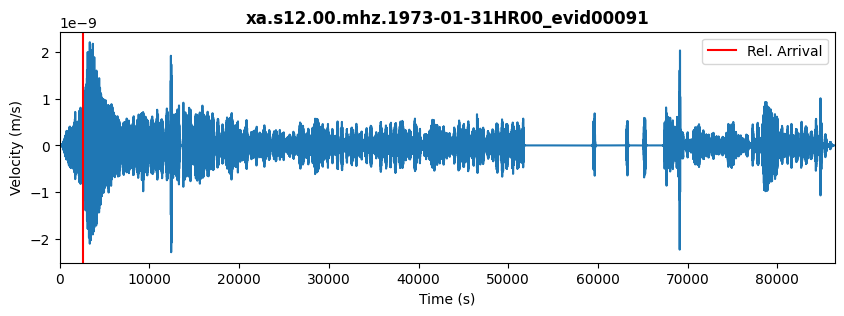

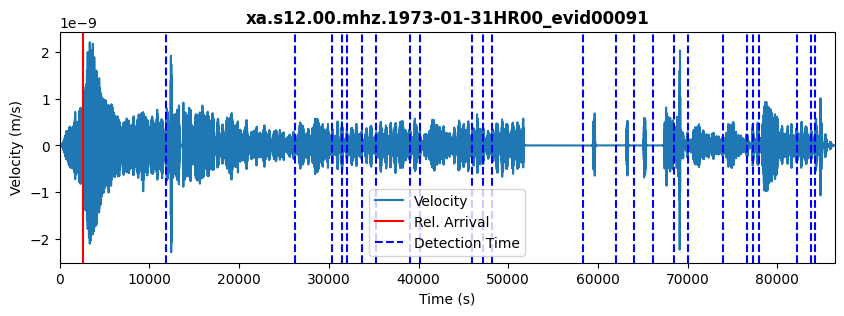

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1973-01-31 00:44:00
DataFrame de Scores:
    id                   time_abs score
0    1 1973-01-31 03:26:55.689340     4
1   22 1973-01-31 21:48:32.142170     4
2   10 1973-01-31 12:56:10.859151     4
3   19 1973-01-31 20:42:14.934623     3
4   25 1973-01-31 23:33:19.085566     2
5    9 1973-01-31 11:19:28.896887     2
6   17 1973-01-31 19:11:45.953491     2
7    3 1973-01-31 08:36:32.745943     1
8   12 1973-01-31 13:33:21.953491     1
9    6 1973-01-31 09:30:59.915755     1
10   2 1973-01-31 07:26:36.368585     0
11  24 1973-01-31 23:25:29.953491     0
12  23 1973-01-31 22:58:56.444057     0
13  18 1973-01-31 19:37:29.198774     0
14   8 1973-01-31 11:00:19.764811     0
15  11 1973-01-31 13:17:18.028962     0
16  20 1973-01-31 21:27:26.934623     0
17   7 1973-01-31 09:56:45.576132     0
18  21 1973-01-31 21:37:34.481792     0
19   0 1973-01-31 00:10:00.444057     0
20   4 1973-01-31 08:54:37.123302     0
21  15 1973-01-31 17:57:02.028962     0
22  16 

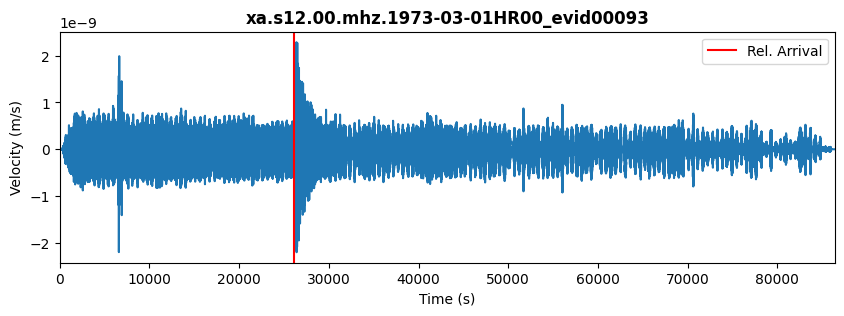

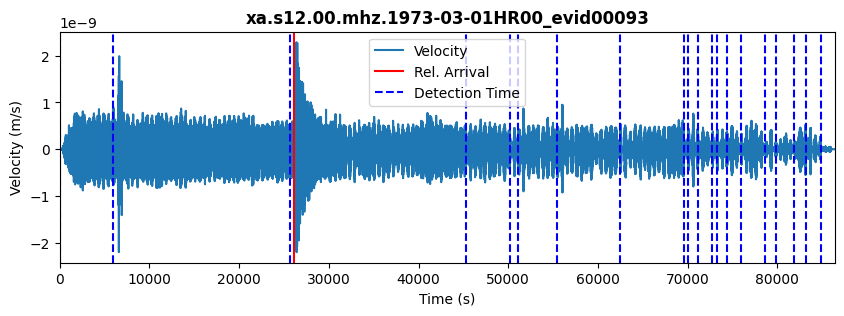

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1973-03-01 07:15:00
DataFrame de Scores:
    id                   time_abs score
0    3 1973-03-01 12:44:23.590283     4
1    2 1973-03-01 07:18:37.477075     4
2    1 1973-03-01 01:49:44.797830     3
3    6 1973-03-01 15:33:54.911038     3
4    0 1973-03-01 00:10:00.194057     3
5    9 1973-03-01 19:37:05.703491     2
6   17 1973-03-01 22:53:58.382736     2
7    5 1973-03-01 14:21:31.514811     1
8   13 1973-03-01 20:49:23.212925     1
9   18 1973-03-01 23:15:47.967642     1
10  19 1973-03-01 23:44:17.250660     0
11  15 1973-03-01 22:01:04.948774     0
12  11 1973-03-01 20:22:25.854434     0
13  10 1973-03-01 19:55:33.477075     0
14  14 1973-03-01 21:16:35.816698     0
15   8 1973-03-01 19:29:13.099717     0
16  16 1973-03-01 22:19:59.741226     0
17  12 1973-03-01 20:32:01.552547     0
18   4 1973-03-01 14:05:50.835566     0
19   7 1973-03-01 17:31:39.665755     0
Nombre del archivo: xa.s12.00.mhz.1973-03-13HR00_evid00094
Tiempo de llegada relativo: 

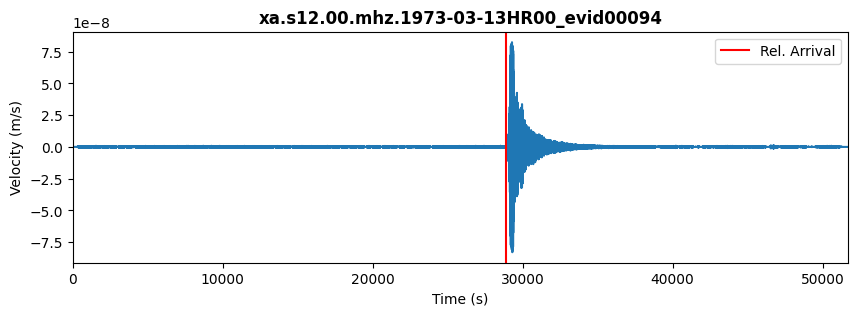

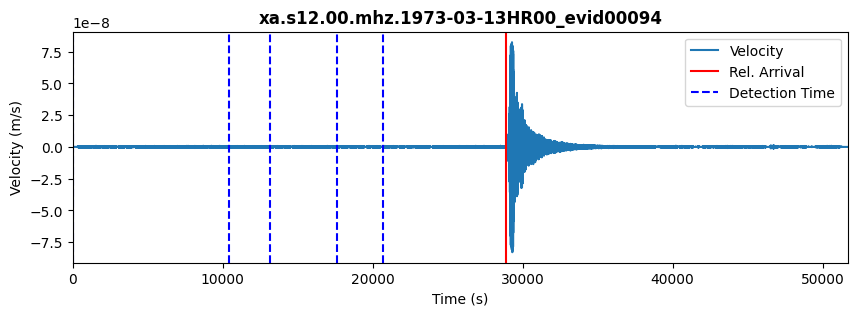

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1973-03-13 08:01:00
DataFrame de Scores:
  id                   time_abs score
0  0 1973-03-13 08:01:50.962566     7
1  3 1973-03-13 12:55:51.868226     6
2  1 1973-03-13 10:55:17.755019     6
3  2 1973-03-13 11:41:16.547472     3
4  4 1973-03-13 13:46:17.830491     2
Nombre del archivo: xa.s12.00.mhz.1973-03-24HR00_evid00097
Tiempo de llegada relativo: 69780.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1973-03-24T00:00:00.606000       0.000000   2.654473e-15
1     1973-03-24T00:00:00.756943       0.150943   1.496578e-15
2     1973-03-24T00:00:00.907887       0.301887   4.665899e-16
3     1973-03-24T00:00:01.058830       0.452830   2.721695e-16
4     1973-03-24T00:00:01.209774       0.603774   9.075782e-16
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1973-03-24T00:00:00.606000       0.000000   2.654473e-15
1     1973-03-24T00:00:00.756943       0.150943   1.496578e-15
2   

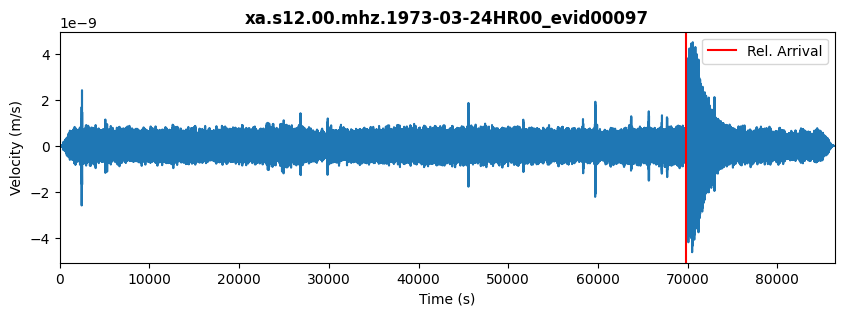

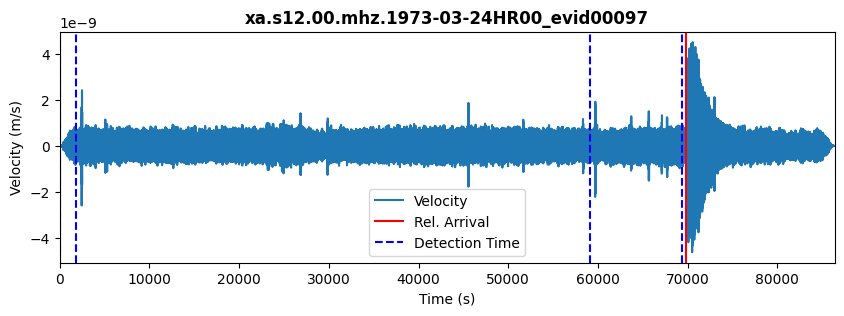

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1973-03-24 19:23:00
DataFrame de Scores:
  id                   time_abs score
0  0 1973-03-24 00:10:12.681472     7
1  3 1973-03-24 19:25:49.889019     7
2  2 1973-03-24 16:34:54.341849     5
3  1 1973-03-24 00:40:51.322981     5
Nombre del archivo: xa.s12.00.mhz.1973-05-14HR00_evid00104
Tiempo de llegada relativo: 2640.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1973-05-14T00:00:00.397000       0.000000  -2.596898e-16
1     1973-05-14T00:00:00.547943       0.150943  -3.141804e-16
2     1973-05-14T00:00:00.698887       0.301887  -3.419432e-16
3     1973-05-14T00:00:00.849830       0.452830  -3.307310e-16
4     1973-05-14T00:00:01.000774       0.603774  -2.894811e-16
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1973-05-14T00:00:00.397000       0.000000  -2.596898e-16
1     1973-05-14T00:00:00.547943       0.150943  -3.141804e-16
2     1973-05-14T00:00:00.698887       0.30

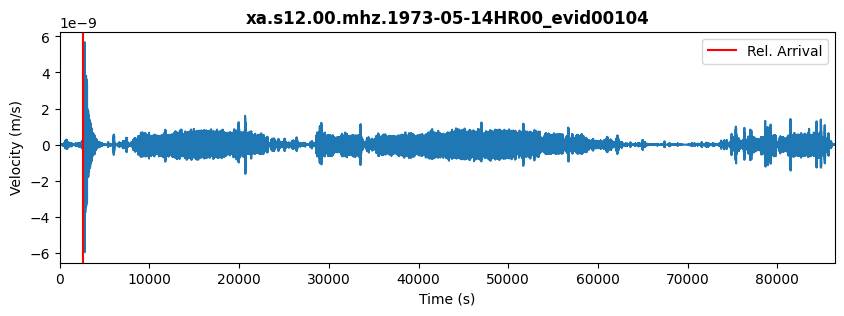

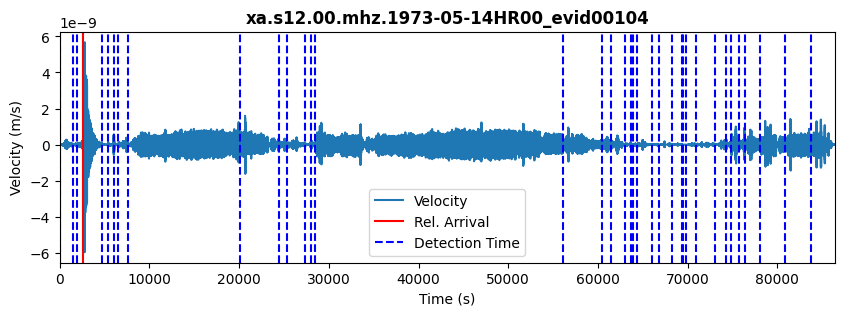

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1973-05-14 00:44:00
DataFrame de Scores:
    id                   time_abs score
0    8 1973-05-14 05:44:40.246057     4
1   12 1973-05-14 07:57:12.095113     3
2    2 1973-05-14 00:42:42.963038     2
3   35 1973-05-14 23:26:47.038509     2
4   32 1973-05-14 21:23:01.529075     2
5    7 1973-05-14 02:16:33.302660     2
6   34 1973-05-14 22:37:34.887566     2
7   14 1973-05-14 15:45:06.963038     2
8   29 1973-05-14 20:48:08.849830     1
9   16 1973-05-14 17:14:45.227189     1
10  33 1973-05-14 21:51:12.849830     1
11  15 1973-05-14 16:57:51.793226     1
12  13 1973-05-14 08:03:34.283792     1
13   5 1973-05-14 01:51:12.849830     0
14  31 1973-05-14 21:11:58.434736     0
15  11 1973-05-14 07:45:56.170585     0
16  21 1973-05-14 18:30:04.925302     0
17  18 1973-05-14 17:50:32.246057     0
18  26 1973-05-14 19:33:53.151717     0
19   3 1973-05-14 01:29:03.642283     0
20   0 1973-05-14 00:10:00.246057     0
21  20 1973-05-14 18:02:45.680019     0
22  27 

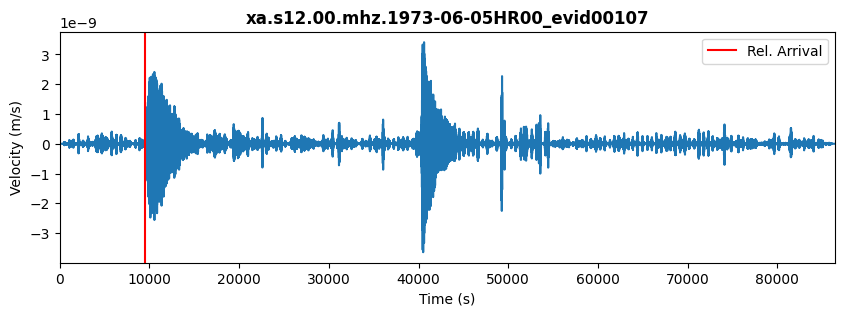

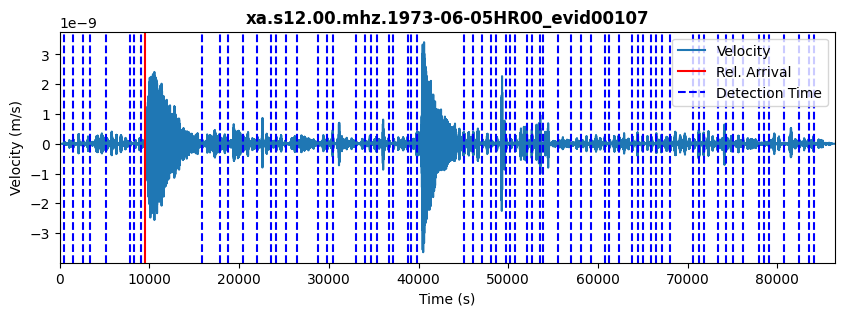

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1973-06-05 02:38:00
DataFrame de Scores:
    id                   time_abs score
0   29 1973-06-05 11:12:56.903774     4
1   38 1973-06-05 14:37:30.413208     3
2    4 1973-06-05 01:06:48.903774     2
3   31 1973-06-05 12:57:53.809434     2
4   68 1973-06-05 23:21:26.941509     2
..  ..                        ...   ...
65  41 1973-06-05 15:07:29.658491     0
66  51 1973-06-05 18:12:44.828302     0
67  37 1973-06-05 14:16:37.884906     0
68  35 1973-06-05 13:59:39.922642     0
69  48 1973-06-05 17:29:00.828302     0

[70 rows x 3 columns]
Nombre del archivo: xa.s12.00.mhz.1973-06-05HR00_evid00108
Tiempo de llegada relativo: 40200.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1973-06-05T00:00:00.300000       0.000000  -3.824537e-16
1     1973-06-05T00:00:00.450943       0.150943  -4.935500e-16
2     1973-06-05T00:00:00.601887       0.301887  -5.418143e-16
3     1973-06-05T00:00:00.752830       0.452830  -5.193435e

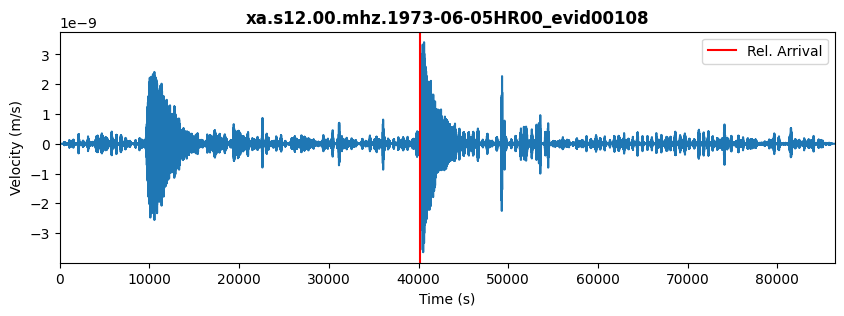

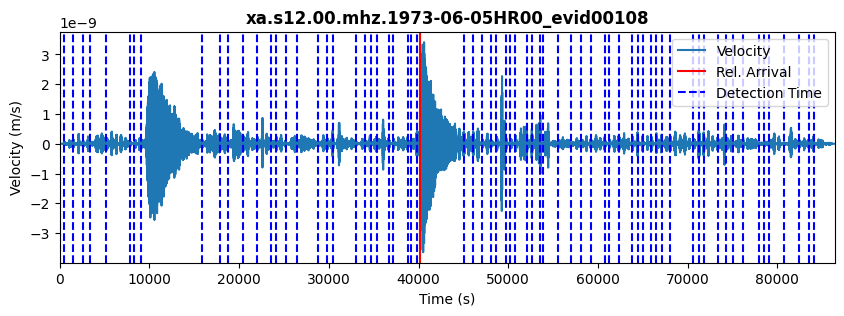

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1973-06-05 11:10:00
DataFrame de Scores:
    id                   time_abs score
0   29 1973-06-05 11:12:56.903774     4
1   38 1973-06-05 14:37:30.413208     3
2    4 1973-06-05 01:06:48.903774     2
3   31 1973-06-05 12:57:53.809434     2
4   68 1973-06-05 23:21:26.941509     2
..  ..                        ...   ...
65  41 1973-06-05 15:07:29.658491     0
66  51 1973-06-05 18:12:44.828302     0
67  37 1973-06-05 14:16:37.884906     0
68  35 1973-06-05 13:59:39.922642     0
69  48 1973-06-05 17:29:00.828302     0

[70 rows x 3 columns]
Nombre del archivo: xa.s12.00.mhz.1973-06-18HR00_evid00109
Tiempo de llegada relativo: 6120.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1973-06-18T00:00:00.132000       0.000000  -3.227422e-15
1     1973-06-18T00:00:00.282943       0.150943  -4.002473e-15
2     1973-06-18T00:00:00.433887       0.301887  -4.342126e-15
3     1973-06-18T00:00:00.584830       0.452830  -4.188061e-

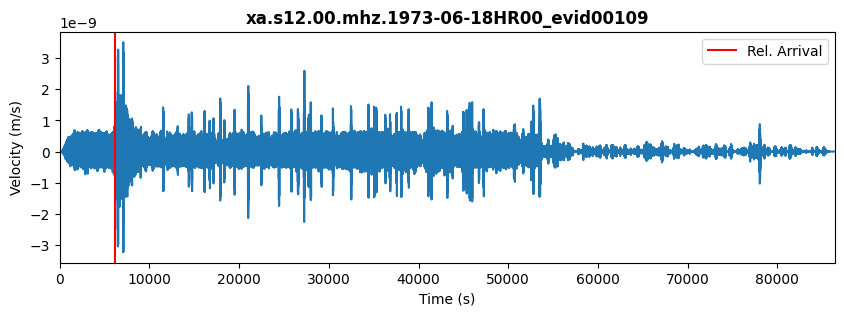

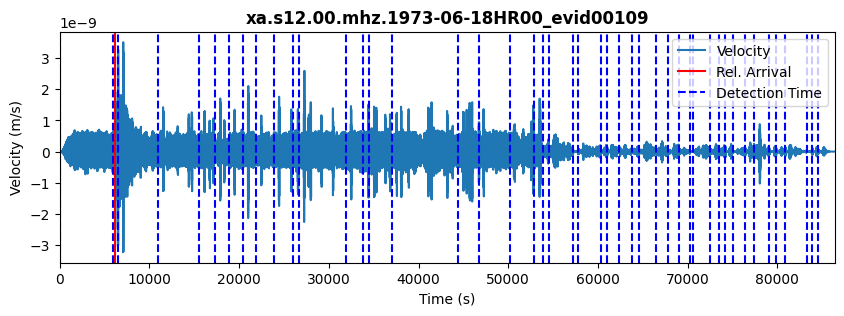

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1973-06-18 01:42:00
DataFrame de Scores:
    id                   time_abs score
0    0 1973-06-18 00:09:59.981057     4
1   10 1973-06-18 07:23:05.339547     3
2    1 1973-06-18 01:48:02.094264     3
3    3 1973-06-18 03:12:15.377283     2
4    2 1973-06-18 01:58:25.792377     2
5    6 1973-06-18 05:24:47.528226     2
6    9 1973-06-18 06:47:23.905585     2
7   16 1973-06-18 12:29:49.565962     1
8   13 1973-06-18 09:34:09.037660     1
9   19 1973-06-18 14:51:38.245208     1
10   7 1973-06-18 05:49:57.565962     1
11  17 1973-06-18 13:08:48.282943     1
12  28 1973-06-18 18:06:05.716906     1
13  15 1973-06-18 10:26:27.301811     0
14  14 1973-06-18 09:44:49.037660     0
15  36 1973-06-18 20:46:57.037660     0
16  27 1973-06-18 17:53:57.415019     0
17  25 1973-06-18 17:06:23.981057     0
18  24 1973-06-18 16:55:35.981057     0
19  35 1973-06-18 20:34:27.754642     0
20  40 1973-06-18 22:08:01.943321     0
21  37 1973-06-18 21:00:13.716906     0
22  39 

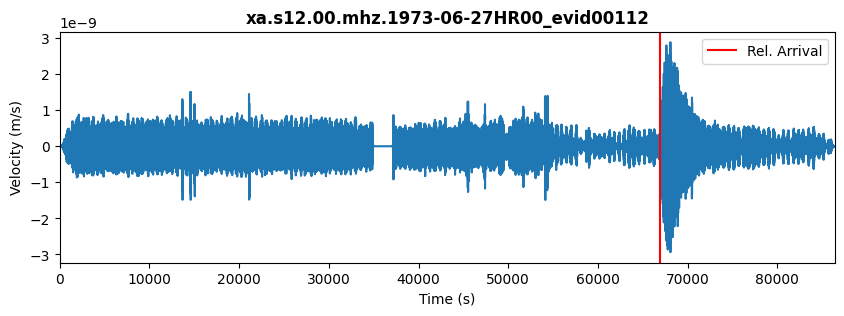

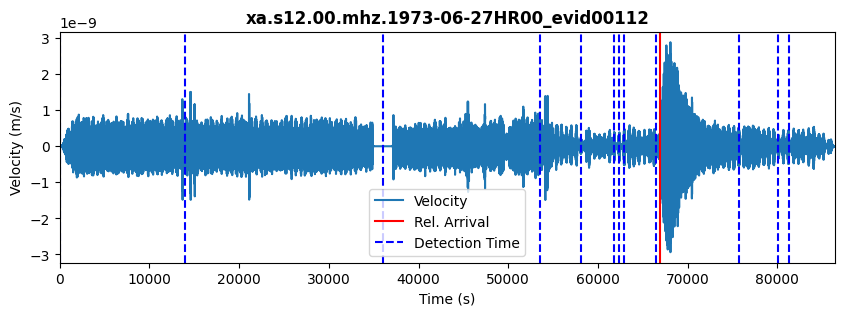

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1973-06-27 18:36:00
DataFrame de Scores:
    id                   time_abs score
0    1 1973-06-27 04:03:12.833774     6
1    3 1973-06-27 15:02:07.928113     6
2    8 1973-06-27 18:38:27.097925     5
3    7 1973-06-27 17:38:48.984717     3
4    5 1973-06-27 17:20:20.154528     2
5    2 1973-06-27 10:10:43.852642     1
6    9 1973-06-27 21:12:18.343208     1
7    0 1973-06-27 00:10:00.079057     0
8    6 1973-06-27 17:29:10.871509     0
9   11 1973-06-27 22:44:23.324340     0
10  10 1973-06-27 22:25:14.192264     0
11   4 1973-06-27 16:18:16.984717     0
Nombre del archivo: xa.s12.00.mhz.1973-07-03HR00_evid00113
Tiempo de llegada relativo: 65700.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1973-07-03T00:00:00.532000       0.000000  -4.079284e-15
1     1973-07-03T00:00:00.682943       0.150943  -5.391369e-15
2     1973-07-03T00:00:00.833887       0.301887  -6.014967e-15
3     1973-07-03T00:00:00.984830       0.4

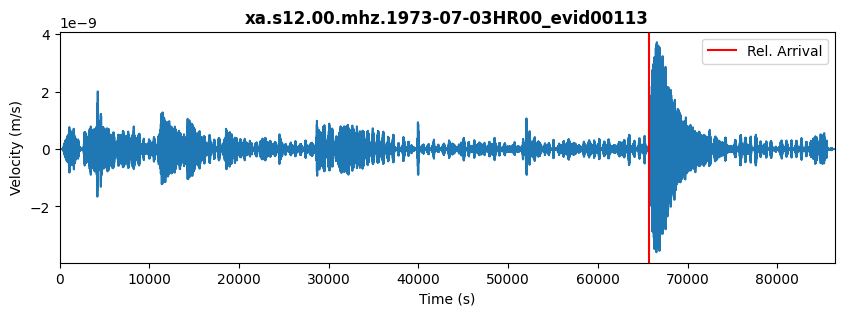

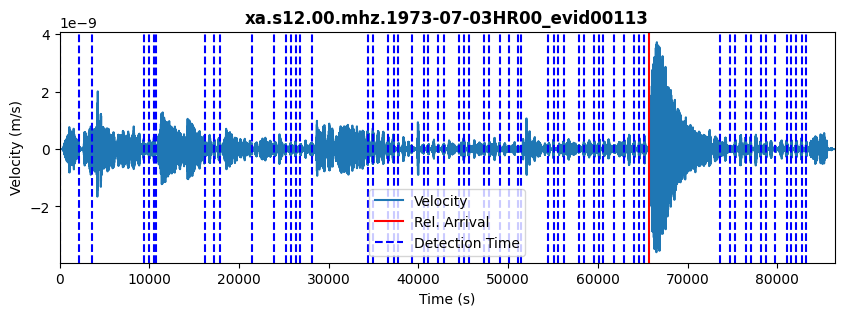

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1973-07-03 18:15:00
DataFrame de Scores:
    id                   time_abs score
0    2 1973-07-03 01:10:51.701811     6
1   49 1973-07-03 18:16:39.475396     6
2   53 1973-07-03 21:24:40.079170     2
3   28 1973-07-03 12:41:38.796151     2
4   16 1973-07-03 07:57:57.815019     2
..  ..                        ...   ...
58  34 1973-07-03 14:20:54.871623     0
59  18 1973-07-03 09:52:33.588604     0
60  32 1973-07-03 13:47:43.928226     0
61  52 1973-07-03 21:05:09.211245     0
62  15 1973-07-03 07:37:17.664075     0

[63 rows x 3 columns]
Nombre del archivo: xa.s12.00.mhz.1973-07-04HR00_evid00114
Tiempo de llegada relativo: 9960.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1973-07-04T00:00:00.544000       0.000000  -5.115098e-15
1     1973-07-04T00:00:00.694943       0.150943  -6.403259e-15
2     1973-07-04T00:00:00.845887       0.301887  -6.974695e-15
3     1973-07-04T00:00:00.996830       0.452830  -6.713945e-

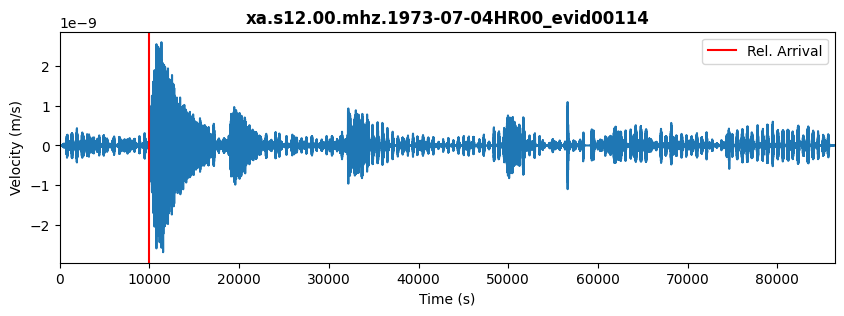

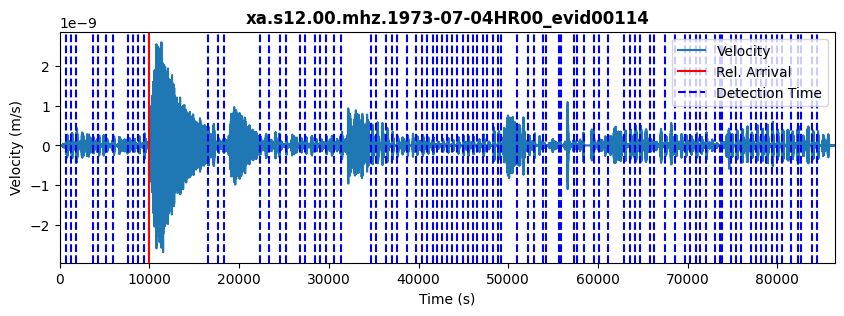

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1973-07-04 02:46:00
DataFrame de Scores:
    id                   time_abs score
0   11 1973-07-04 02:48:03.411925     6
1   55 1973-07-04 15:39:25.374189     2
2    8 1973-07-04 02:19:49.072302     2
3   50 1973-07-04 14:21:46.355321     2
4   42 1973-07-04 12:49:59.034566     2
..  ..                        ...   ...
89  48 1973-07-04 13:45:58.279849     0
90  79 1973-07-04 20:58:46.732679     0
91  32 1973-07-04 11:15:01.977962     0
92  83 1973-07-04 21:46:31.185509     0
93  43 1973-07-04 12:59:32.166642     0

[94 rows x 3 columns]
Nombre del archivo: xa.s12.00.mhz.1973-07-20HR00_evid00117
Tiempo de llegada relativo: 68520.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1973-07-20T00:00:00.308000       0.000000  -1.692033e-15
1     1973-07-20T00:00:00.458943       0.150943  -2.127763e-15
2     1973-07-20T00:00:00.609887       0.301887  -2.329233e-15
3     1973-07-20T00:00:00.760830       0.452830  -2.247465e

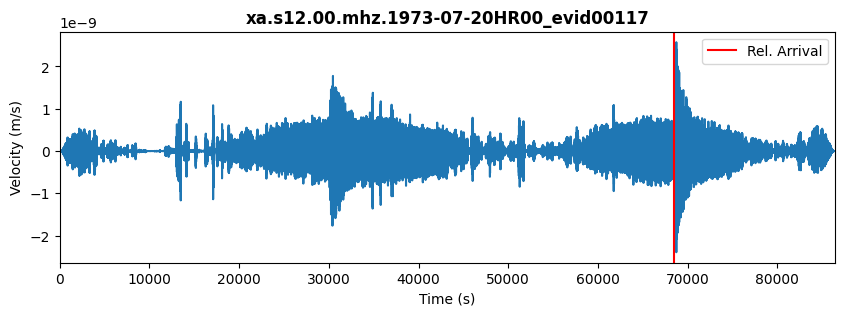

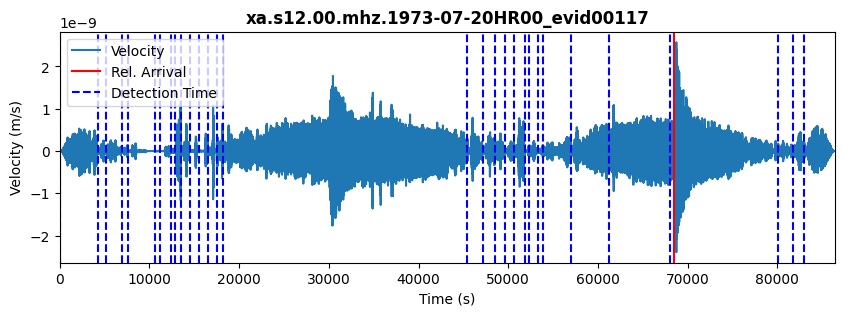

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1973-07-20 19:02:00
DataFrame de Scores:
    id                   time_abs score
0    8 1973-07-20 03:44:43.779698     6
1    7 1973-07-20 03:36:53.591019     5
2    9 1973-07-20 03:54:58.421208     3
3   25 1973-07-20 17:10:01.213660     2
4   26 1973-07-20 19:04:44.685358     2
5   11 1973-07-20 04:29:28.760830     1
6   12 1973-07-20 04:44:38.949509     1
7   13 1973-07-20 05:02:11.930642     1
8    1 1973-07-20 01:21:53.817434     1
9   23 1973-07-20 15:07:00.534415     1
10  16 1973-07-20 13:16:56.006113     1
11  24 1973-07-20 16:00:19.477811     0
12  29 1973-07-20 23:13:02.043849     0
13  14 1973-07-20 05:13:42.194792     0
14  28 1973-07-20 22:53:14.270264     0
15  27 1973-07-20 22:24:45.138189     0
16   6 1973-07-20 03:15:22.572151     0
17  19 1973-07-20 14:13:10.496679     0
18   3 1973-07-20 02:06:13.289132     0
19   4 1973-07-20 02:16:14.345736     0
20   5 1973-07-20 03:06:13.289132     0
21  17 1973-07-20 13:39:31.175925     0
22  18 

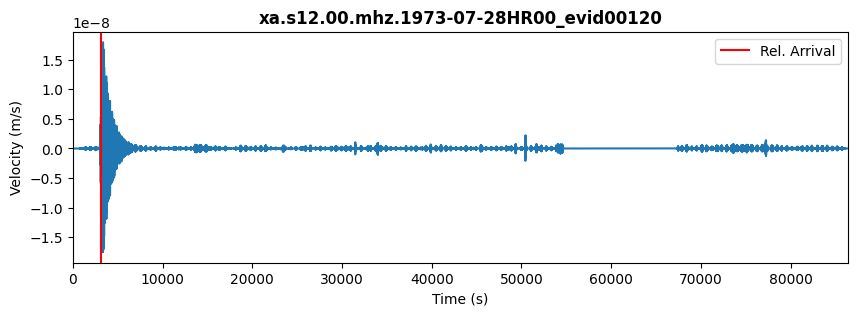

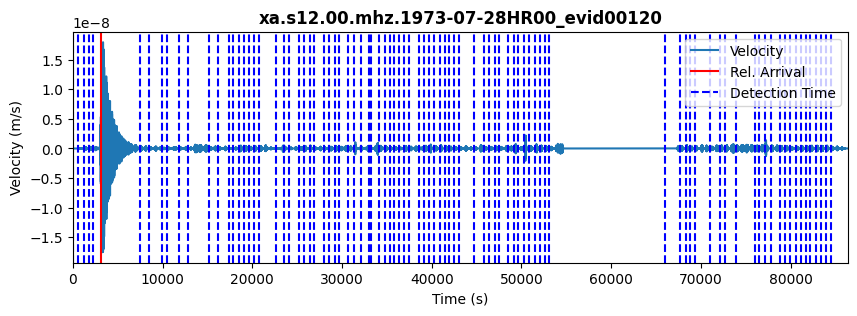

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1973-07-28 00:52:00
DataFrame de Scores:
    id                   time_abs score
0    4 1973-07-28 00:50:57.633491     4
1   10 1973-07-28 03:46:03.293868     4
2   78 1973-07-28 21:49:28.727830     2
3   31 1973-07-28 08:44:34.841038     2
4   62 1973-07-28 14:31:37.482547     2
..  ..                        ...   ...
85  28 1973-07-28 08:09:09.859906     0
86  42 1973-07-28 10:37:52.727830     0
87   9 1973-07-28 03:30:02.388208     0
88  63 1973-07-28 14:41:09.859906     0
89  46 1973-07-28 11:24:17.633491     0

[90 rows x 3 columns]
Nombre del archivo: xa.s12.00.mhz.1973-07-29HR00_evid00121
Tiempo de llegada relativo: 84660.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1973-07-29T00:00:00.262000       0.000000  -1.145921e-15
1     1973-07-29T00:00:00.412943       0.150943  -1.418709e-15
2     1973-07-29T00:00:00.563887       0.301887  -1.535860e-15
3     1973-07-29T00:00:00.714830       0.452830  -1.477905e

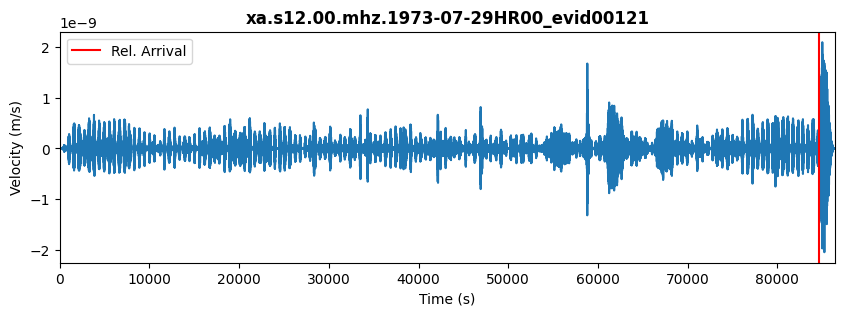

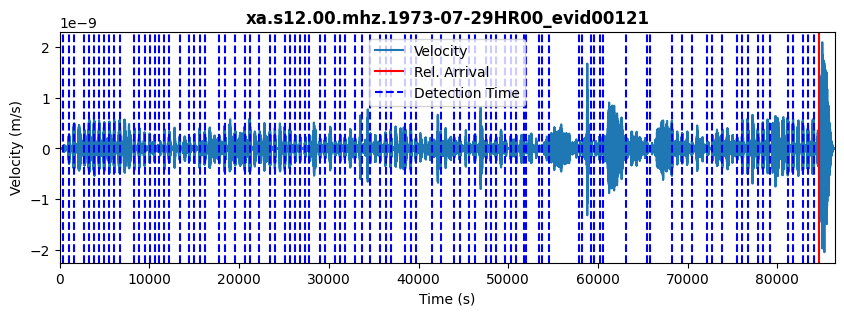

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1973-07-29 23:31:00
DataFrame de Scores:
    id                   time_abs score
0   95 1973-07-29 23:32:13.243132     5
1   15 1973-07-29 02:57:14.978981     5
2   75 1973-07-29 16:58:41.469547     2
3   27 1973-07-29 05:36:07.507283     2
4    5 1973-07-29 01:04:56.865774     2
..  ..                        ...   ...
91  82 1973-07-29 20:13:07.431811     0
92  46 1973-07-29 09:46:54.601623     0
93  32 1973-07-29 06:49:28.714830     0
94  14 1973-07-29 02:47:31.280868     0
95   0 1973-07-29 00:10:00.111057     0

[96 rows x 3 columns]
Nombre del archivo: xa.s12.00.mhz.1973-08-21HR00_evid00127
Tiempo de llegada relativo: 44220.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1973-08-21T00:00:00.652000       0.000000  -4.589350e-16
1     1973-08-21T00:00:00.802943       0.150943  -5.149594e-16
2     1973-08-21T00:00:00.953887       0.301887  -5.274259e-16
3     1973-08-21T00:00:01.104830       0.452830  -4.689516e

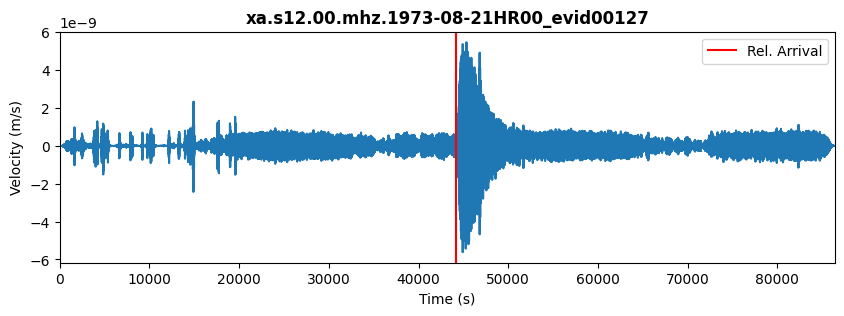

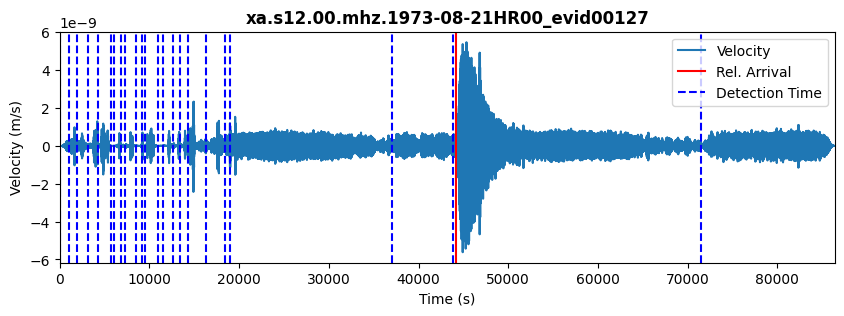

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1973-08-21 12:17:00
DataFrame de Scores:
    id                   time_abs score
0   10 1973-08-21 02:43:23.972755     6
1   16 1973-08-21 04:08:24.048226     4
2   19 1973-08-21 05:26:33.708604     4
3   21 1973-08-21 12:21:30.010491     3
4    3 1973-08-21 01:03:07.670868     2
5   15 1973-08-21 03:52:31.595396     2
6   20 1973-08-21 10:26:59.821811     1
7    4 1973-08-21 01:20:16.953887     1
8    8 1973-08-21 02:11:08.727472     1
9   14 1973-08-21 03:40:49.708604     0
10   2 1973-08-21 00:41:23.368981     0
11   9 1973-08-21 02:31:04.953887     0
12   6 1973-08-21 01:49:51.142566     0
13  13 1973-08-21 03:21:57.935019     0
14  11 1973-08-21 02:49:06.161434     0
15   0 1973-08-21 00:10:00.501057     0
16   7 1973-08-21 02:04:11.519925     0
17  18 1973-08-21 05:16:39.444453     0
18  12 1973-08-21 03:12:13.633132     0
19  22 1973-08-21 20:01:05.859547     0
20   5 1973-08-21 01:45:21.406717     0
21   1 1973-08-21 00:27:00.878415     0
22  17 

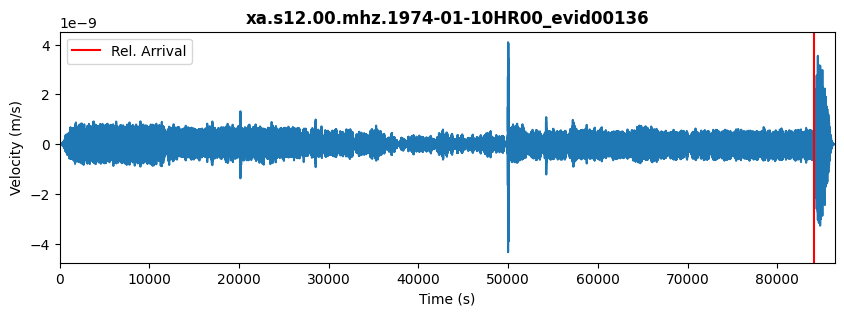

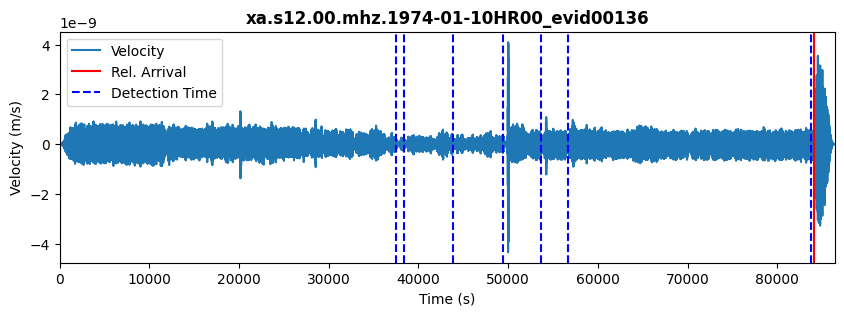

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1974-01-10 23:21:00
DataFrame de Scores:
  id                   time_abs score
0  4 1974-01-10 13:52:53.361075     6
1  2 1974-01-10 10:48:58.795038     4
2  7 1974-01-10 23:26:00.078057     4
3  6 1974-01-10 15:54:36.757302     4
4  5 1974-01-10 15:03:43.625226     2
5  0 1974-01-10 00:10:00.078057     2
6  3 1974-01-10 12:20:01.436547     1
7  1 1974-01-10 10:35:07.247868     1
Nombre del archivo: xa.s12.00.mhz.1974-02-07HR00_evid00137
Tiempo de llegada relativo: 22860.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1974-02-07T00:00:00.354000       0.000000  -3.989563e-14
1     1974-02-07T00:00:00.504943       0.150943  -4.991813e-14
2     1974-02-07T00:00:00.655887       0.301887  -5.441284e-14
3     1974-02-07T00:00:00.806830       0.452830  -5.246174e-14
4     1974-02-07T00:00:00.957774       0.603774  -4.598499e-14
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1974-02-07

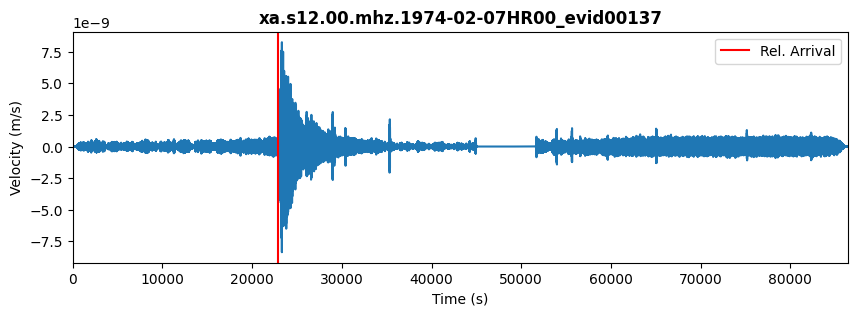

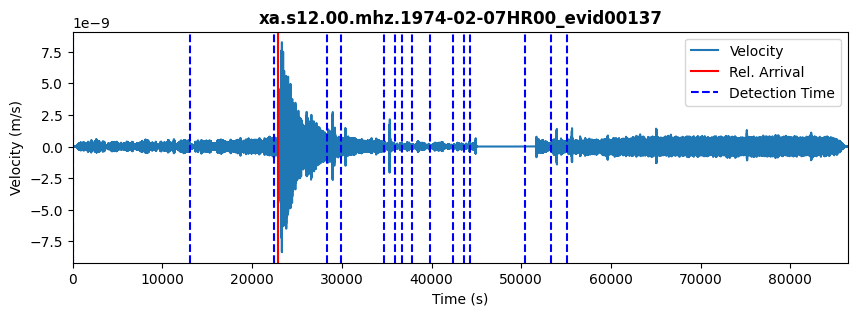

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1974-02-07 06:21:00
DataFrame de Scores:
    id                   time_abs score
0   15 1974-02-07 15:27:47.976642     5
1    2 1974-02-07 06:23:30.316264     4
2    4 1974-02-07 08:27:36.957774     4
3    3 1974-02-07 08:02:50.769094     3
4   12 1974-02-07 12:28:38.844566     2
5    5 1974-02-07 09:48:20.882302     2
6   14 1974-02-07 14:59:18.240792     2
7    6 1974-02-07 10:09:09.184189     1
8    1 1974-02-07 03:48:06.391736     1
9   11 1974-02-07 12:17:30.920038     0
10   7 1974-02-07 10:22:21.184189     0
11   9 1974-02-07 11:13:08.127585     0
12  13 1974-02-07 14:10:56.504943     0
13   0 1974-02-07 00:10:00.203057     0
14  10 1974-02-07 11:55:34.995509     0
15   8 1974-02-07 10:41:07.523811     0
Nombre del archivo: xa.s12.00.mhz.1974-02-12HR00_evid00138
Tiempo de llegada relativo: 81000.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1974-02-12T00:00:00.400000       0.000000  -5.684346e-15
1     19

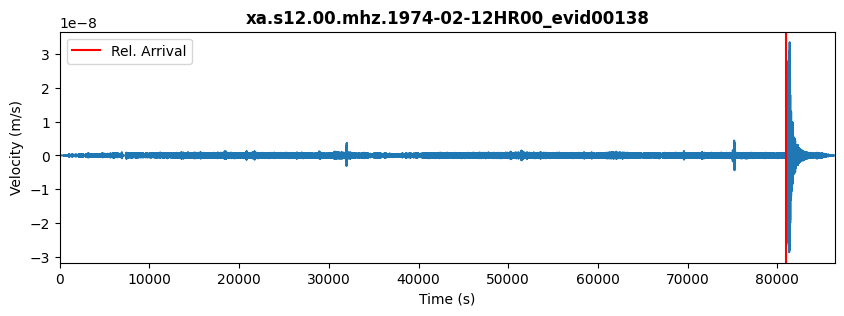

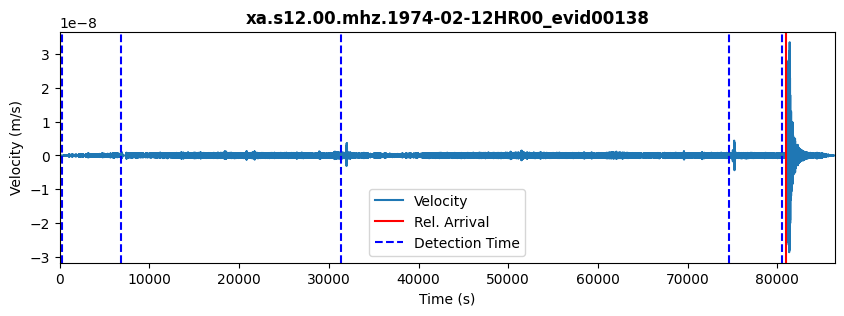

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1974-02-12 22:30:00
DataFrame de Scores:
  id                   time_abs score
0  5 1974-02-12 22:31:46.815094     6
1  2 1974-02-12 02:04:33.456604     5
2  4 1974-02-12 20:53:06.664151     4
3  3 1974-02-12 08:52:40.098113     4
4  1 1974-02-12 00:14:51.418868     3
5  0 1974-02-12 00:10:00.249057     2
Nombre del archivo: xa.s12.00.mhz.1974-03-25HR00_evid00140
Tiempo de llegada relativo: 61080.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1974-03-25T00:00:00.598000       0.000000  -2.444383e-14
1     1974-03-25T00:00:00.748943       0.150943  -3.059568e-14
2     1974-03-25T00:00:00.899887       0.301887  -3.335562e-14
3     1974-03-25T00:00:01.050830       0.452830  -3.216176e-14
4     1974-03-25T00:00:01.201774       0.603774  -2.819395e-14
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1974-03-25T00:00:00.598000       0.000000  -2.444383e-14
1     1974-03-25T00:00:00.748

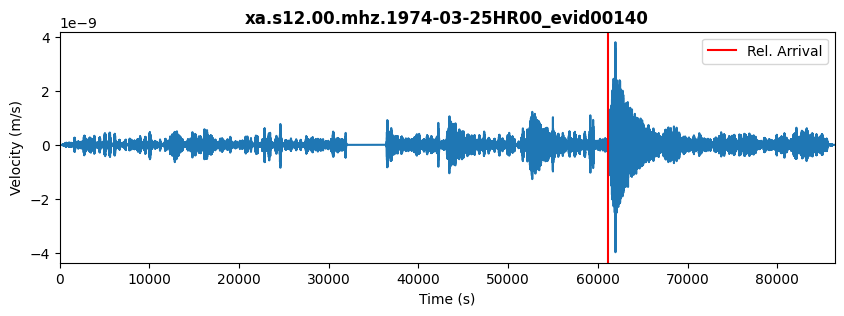

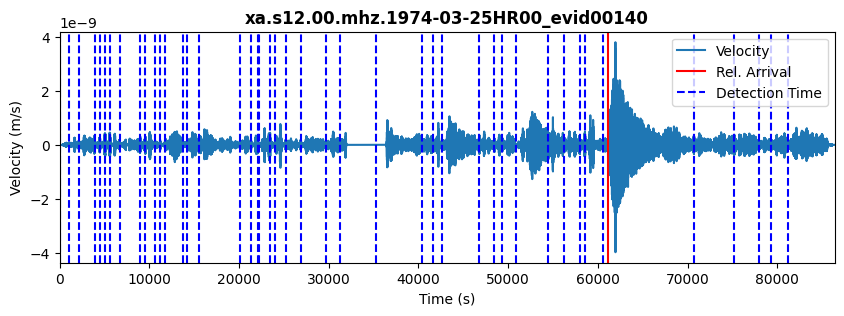

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1974-03-25 16:58:00
DataFrame de Scores:
    id                   time_abs score
0   34 1974-03-25 15:16:32.748943     4
1   38 1974-03-25 16:59:56.371585     3
2    5 1974-03-25 01:34:39.541396     3
3   29 1974-03-25 12:00:07.239509     3
4   37 1974-03-25 16:25:53.503660     3
5   33 1974-03-25 14:18:38.182906     2
6   35 1974-03-25 15:46:59.013094     2
7   21 1974-03-25 06:49:45.956491     1
8   36 1974-03-25 16:16:16.899887     1
9   32 1974-03-25 13:52:36.824415     1
10  25 1974-03-25 08:51:24.371585     1
11  23 1974-03-25 07:37:55.314981     0
12  24 1974-03-25 08:24:51.918755     0
13  30 1974-03-25 13:09:22.711208     0
14  19 1974-03-25 06:20:32.748943     0
15  27 1974-03-25 11:23:40.522528     0
16   8 1974-03-25 02:39:45.050830     0
17  18 1974-03-25 06:18:08.145170     0
18  16 1974-03-25 05:45:32.371585     0
19  42 1974-03-25 22:12:17.503660     0
20  28 1974-03-25 11:43:16.371585     0
21  12 1974-03-25 03:26:31.239509     0
22  39 

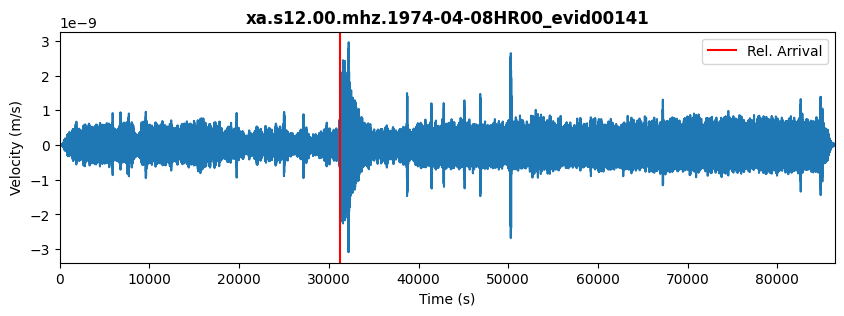

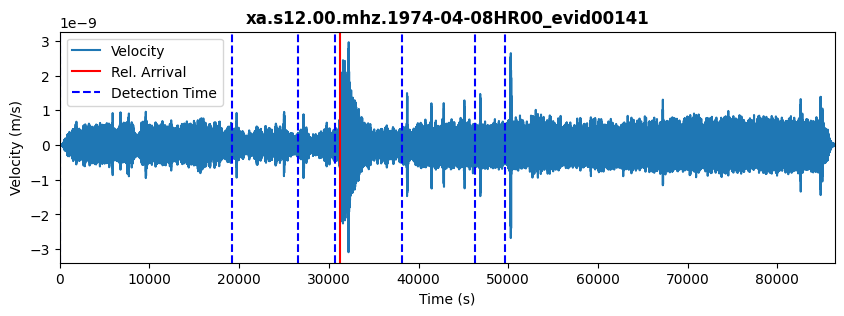

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1974-04-08 08:40:00
DataFrame de Scores:
  id                   time_abs score
0  5 1974-04-08 13:01:34.571736     6
1  3 1974-04-08 08:41:33.967962     5
2  2 1974-04-08 07:33:14.043434     4
3  6 1974-04-08 13:57:57.364189     3
4  4 1974-04-08 10:45:19.628340     3
5  1 1974-04-08 05:29:12.081170     2
6  0 1974-04-08 00:10:00.383057     1
Nombre del archivo: xa.s12.00.mhz.1974-04-19HR00_evid00142
Tiempo de llegada relativo: 66840.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1974-04-19T00:00:00.568000       0.000000  -6.921709e-15
1     1974-04-19T00:00:00.718943       0.150943  -8.676364e-15
2     1974-04-19T00:00:00.869887       0.301887  -9.458578e-15
3     1974-04-19T00:00:01.020830       0.452830  -9.108637e-15
4     1974-04-19T00:00:01.171774       0.603774  -7.974373e-15
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1974-04-19T00:00:00.568000       0.000000  -6.92

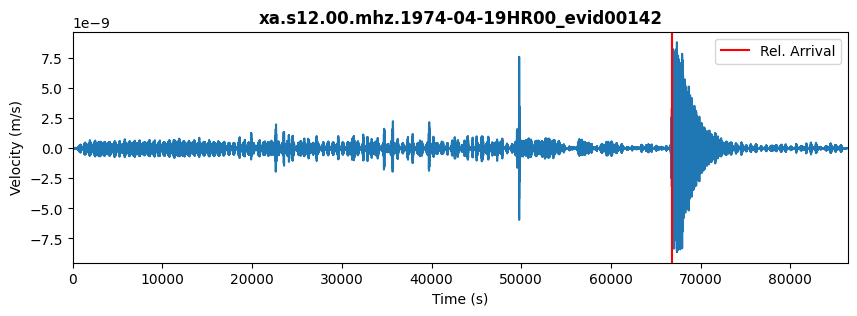

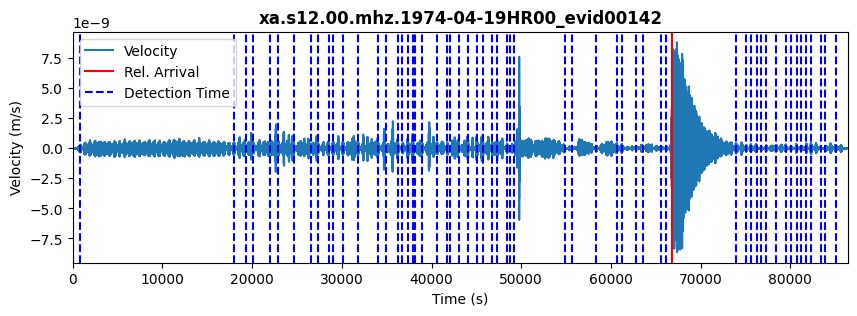

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1974-04-19 18:34:00
DataFrame de Scores:
    id                   time_abs score
0   42 1974-04-19 18:31:25.398189     6
1   18 1974-04-19 10:32:26.379321     4
2   33 1974-04-19 13:49:15.737811     3
3   25 1974-04-19 12:08:03.435925     2
4    5 1974-04-19 06:17:06.832151     2
5    0 1974-04-19 00:10:00.417057     1
6   24 1974-04-19 11:50:34.530264     1
7   28 1974-04-19 12:52:15.360453     1
8   40 1974-04-19 17:49:49.851019     1
9   27 1974-04-19 12:40:22.152906     1
10  30 1974-04-19 13:19:06.077434     1
11  21 1974-04-19 10:59:20.266113     1
12  11 1974-04-19 08:13:10.756679     0
13  38 1974-04-19 17:11:08.341585     0
14  48 1974-04-19 21:38:53.096302     0
15   7 1974-04-19 07:00:26.983094     0
16  31 1974-04-19 13:36:54.001962     0
17  55 1974-04-19 23:01:43.662340     0
18  37 1974-04-19 17:01:08.643472     0
19  35 1974-04-19 15:37:51.511396     0
20  12 1974-04-19 08:31:49.096302     0
21   4 1974-04-19 05:45:30.077434     0
22  16 

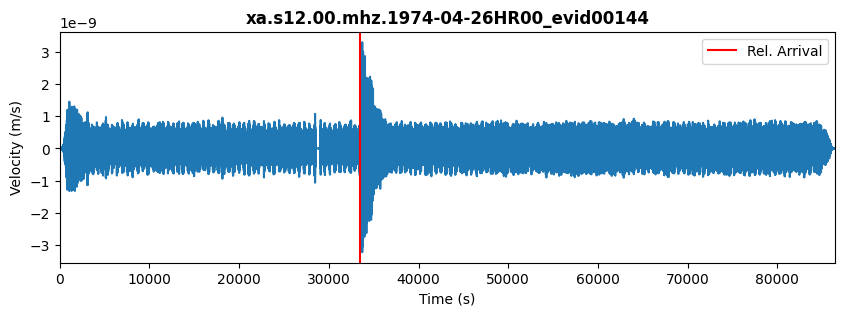

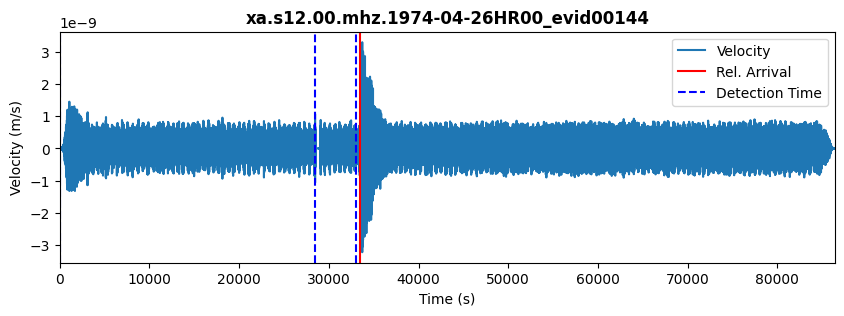

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1974-04-26 09:18:00
DataFrame de Scores:
  id                   time_abs score
0  1 1974-04-26 08:04:37.632019     8
1  2 1974-04-26 09:21:10.084849     7
2  0 1974-04-26 00:10:00.198057     5
Nombre del archivo: xa.s12.00.mhz.1974-04-27HR00_evid00145
Tiempo de llegada relativo: 51480.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1974-04-27T00:00:00.646000       0.000000   1.087483e-15
1     1974-04-27T00:00:00.796943       0.150943   9.658970e-16
2     1974-04-27T00:00:00.947887       0.301887   2.481271e-15
3     1974-04-27T00:00:01.098830       0.452830   4.330846e-15
4     1974-04-27T00:00:01.249774       0.603774   4.765501e-15
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1974-04-27T00:00:00.646000       0.000000   1.087483e-15
1     1974-04-27T00:00:00.796943       0.150943   9.658970e-16
2     1974-04-27T00:00:00.947887       0.301887   2.481271e-15
3     1974-04-27T

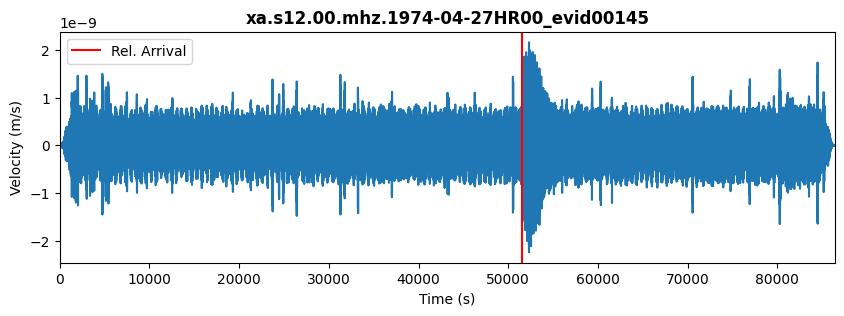

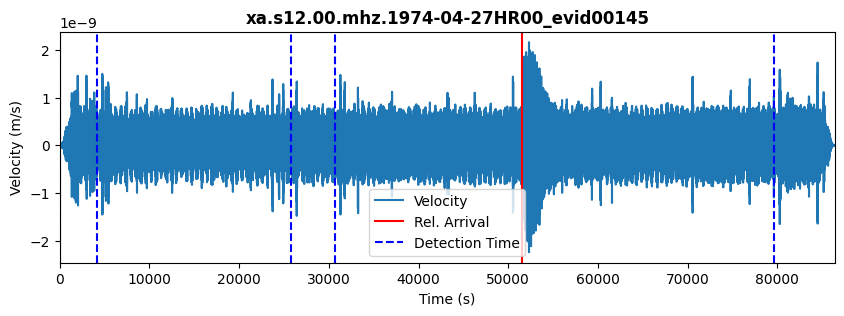

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1974-04-27 14:18:00
DataFrame de Scores:
  id                   time_abs score
0  0 1974-04-27 00:10:00.495057     6
1  2 1974-04-27 07:20:27.212038     5
2  4 1974-04-27 22:17:48.721472     5
3  1 1974-04-27 01:18:58.306377     4
4  3 1974-04-27 08:41:52.344113     4
Nombre del archivo: xa.s12.00.mhz.1974-06-25HR00_evid00149
Tiempo de llegada relativo: 1380.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1974-06-25T00:00:00.524000       0.000000   6.339572e-16
1     1974-06-25T00:00:00.674943       0.150943   2.270817e-16
2     1974-06-25T00:00:00.825887       0.301887  -1.441165e-15
3     1974-06-25T00:00:00.976830       0.452830  -2.619193e-15
4     1974-06-25T00:00:01.127774       0.603774  -2.066129e-15
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1974-06-25T00:00:00.524000       0.000000   6.339572e-16
1     1974-06-25T00:00:00.674943       0.150943   2.270817e-16
2    

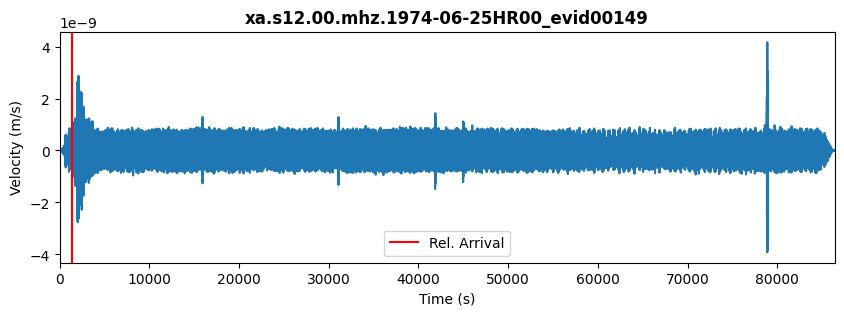

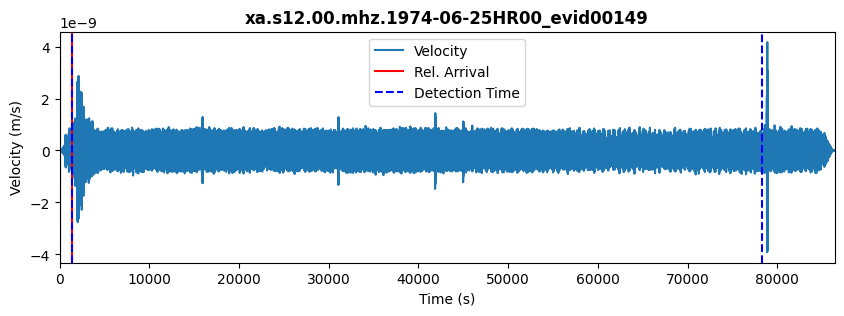

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1974-06-25 00:23:00
DataFrame de Scores:
  id                   time_abs score
0  0 1974-06-25 00:10:00.373057     8
1  2 1974-06-25 21:54:40.524000     7
2  1 1974-06-25 00:33:04.071170     5
Nombre del archivo: xa.s12.00.mhz.1974-07-06HR00_evid00150
Tiempo de llegada relativo: 10620.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1974-07-06T00:00:00.193000       0.000000  -5.822985e-16
1     1974-07-06T00:00:00.343943       0.150943  -6.922769e-16
2     1974-07-06T00:00:00.494887       0.301887  -7.255003e-16
3     1974-07-06T00:00:00.645830       0.452830  -6.945061e-16
4     1974-07-06T00:00:00.796774       0.603774  -6.315960e-16
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1974-07-06T00:00:00.193000       0.000000  -5.822985e-16
1     1974-07-06T00:00:00.343943       0.150943  -6.922769e-16
2     1974-07-06T00:00:00.494887       0.301887  -7.255003e-16
3     1974-07-06T

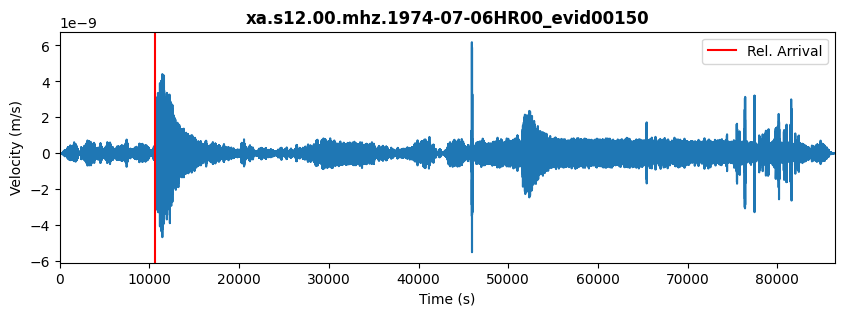

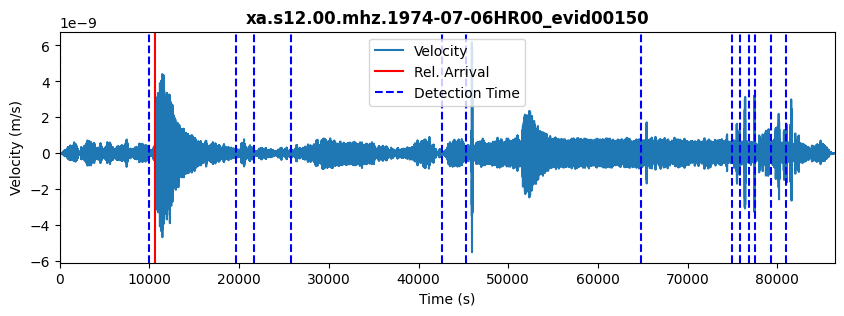

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1974-07-06 02:57:00
DataFrame de Scores:
    id                   time_abs score
0    7 1974-07-06 18:10:39.589226     4
1    6 1974-07-06 12:45:02.985453     4
2    8 1974-07-06 20:58:21.023189     3
3   10 1974-07-06 21:30:28.419415     3
4   13 1974-07-06 22:40:02.004321     3
5    5 1974-07-06 12:00:12.419415     3
6   11 1974-07-06 21:41:23.664698     2
7    1 1974-07-06 02:55:37.853377     1
8    3 1974-07-06 06:10:52.117528     1
9    4 1974-07-06 07:20:04.117528     0
10   9 1974-07-06 21:13:01.626962     0
11   2 1974-07-06 05:37:50.985453     0
12   0 1974-07-06 00:10:00.042057     0
13  12 1974-07-06 22:10:49.551491     0
Nombre del archivo: xa.s12.00.mhz.1974-07-06HR00_evid00151
Tiempo de llegada relativo: 51240.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1974-07-06T00:00:00.193000       0.000000  -5.822985e-16
1     1974-07-06T00:00:00.343943       0.150943  -6.922769e-16
2     1974-07-06T00:00:00

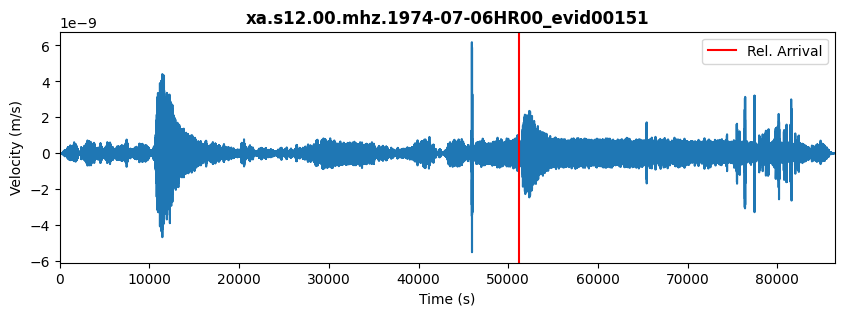

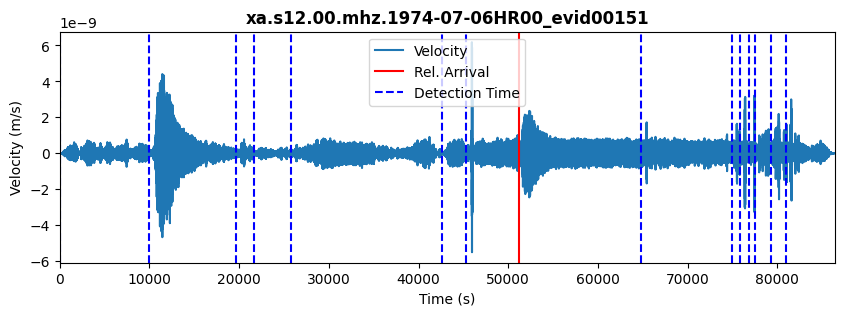

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1974-07-06 14:14:00
DataFrame de Scores:
    id                   time_abs score
0    7 1974-07-06 18:10:39.589226     4
1    6 1974-07-06 12:45:02.985453     4
2    8 1974-07-06 20:58:21.023189     3
3   10 1974-07-06 21:30:28.419415     3
4   13 1974-07-06 22:40:02.004321     3
5    5 1974-07-06 12:00:12.419415     3
6   11 1974-07-06 21:41:23.664698     2
7    1 1974-07-06 02:55:37.853377     1
8    3 1974-07-06 06:10:52.117528     1
9    4 1974-07-06 07:20:04.117528     0
10   9 1974-07-06 21:13:01.626962     0
11   2 1974-07-06 05:37:50.985453     0
12   0 1974-07-06 00:10:00.042057     0
13  12 1974-07-06 22:10:49.551491     0
Nombre del archivo: xa.s12.00.mhz.1974-07-11HR00_evid00152
Tiempo de llegada relativo: 3120.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1974-07-11T00:00:00.359000       0.000000  -8.508249e-15
1     1974-07-11T00:00:00.509943       0.150943  -1.068047e-14
2     1974-07-11T00:00:00.

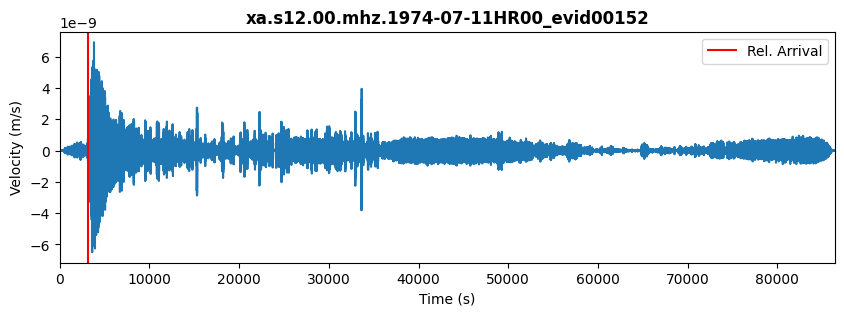

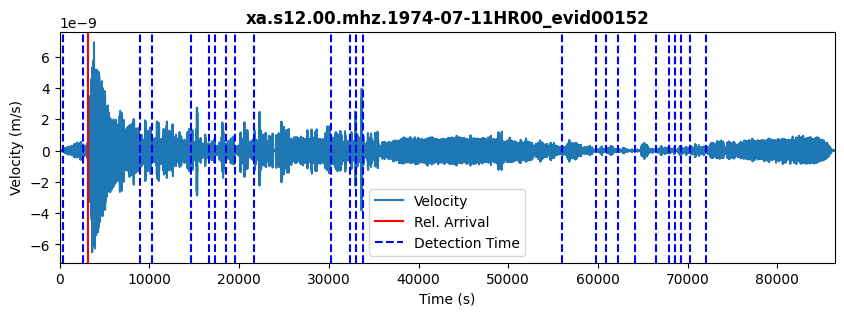

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1974-07-11 00:52:00
DataFrame de Scores:
    id                   time_abs score
0   12 1974-07-11 09:09:09.189189     4
1    2 1974-07-11 00:53:04.057113     4
2   11 1974-07-11 08:34:29.340132     3
3   15 1974-07-11 15:44:05.943906     2
4    6 1974-07-11 04:47:52.962774     2
5    4 1974-07-11 03:01:05.415604     2
6   14 1974-07-11 09:33:57.792962     1
7    1 1974-07-11 00:15:30.774094     1
8    5 1974-07-11 04:14:42.623151     1
9   10 1974-07-11 06:11:22.019377     1
10   9 1974-07-11 05:35:23.528811     1
11   7 1974-07-11 04:57:52.660887     1
12  13 1974-07-11 09:20:23.000509     1
13  17 1974-07-11 17:04:29.943906     0
14  22 1974-07-11 19:12:20.283528     0
15   0 1974-07-11 00:10:00.208057     0
16  21 1974-07-11 19:02:35.075981     0
17  18 1974-07-11 17:27:22.170321     0
18  20 1974-07-11 18:37:00.887302     0
19   8 1974-07-11 05:18:59.528811     0
20  19 1974-07-11 17:59:35.151453     0
21  25 1974-07-11 20:10:04.585415     0
22  24 

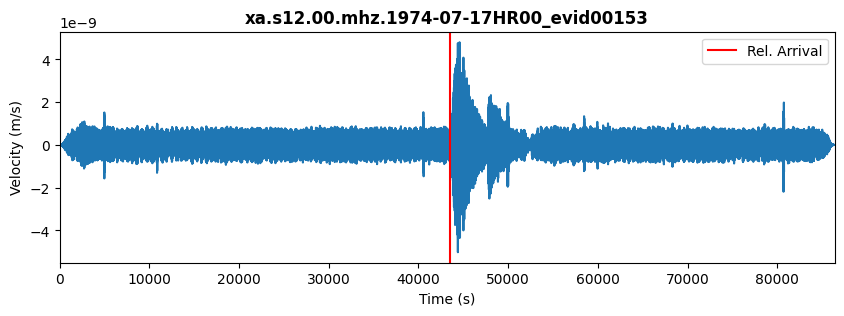

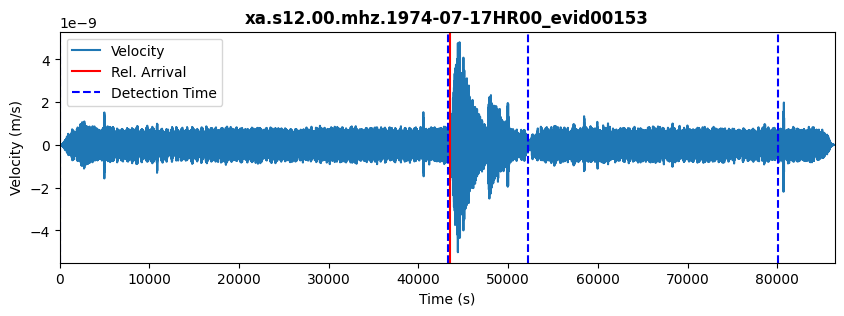

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1974-07-17 12:05:00
DataFrame de Scores:
  id                   time_abs score
0  1 1974-07-17 12:11:30.037321     8
1  2 1974-07-17 14:39:26.414679     6
2  3 1974-07-17 22:25:02.414679     6
3  0 1974-07-17 00:10:00.075057     4
Nombre del archivo: xa.s12.00.mhz.1974-10-14HR00_evid00156
Tiempo de llegada relativo: 63780.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1974-10-14T00:00:00.996000       0.000000  -2.486178e-16
1     1974-10-14T00:00:01.146943       0.150943  -3.200714e-16
2     1974-10-14T00:00:01.297887       0.301887  -3.483120e-16
3     1974-10-14T00:00:01.448830       0.452830  -3.293471e-16
4     1974-10-14T00:00:01.599774       0.603774  -2.854016e-16
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1974-10-14T00:00:00.996000       0.000000  -2.486178e-16
1     1974-10-14T00:00:01.146943       0.150943  -3.200714e-16
2     1974-10-14T00:00:01.297887       0.3

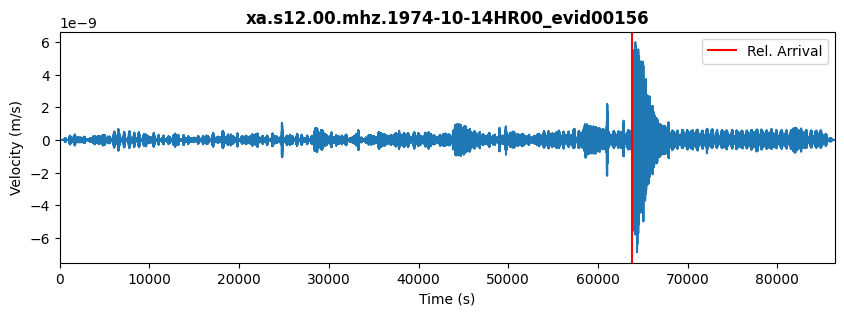

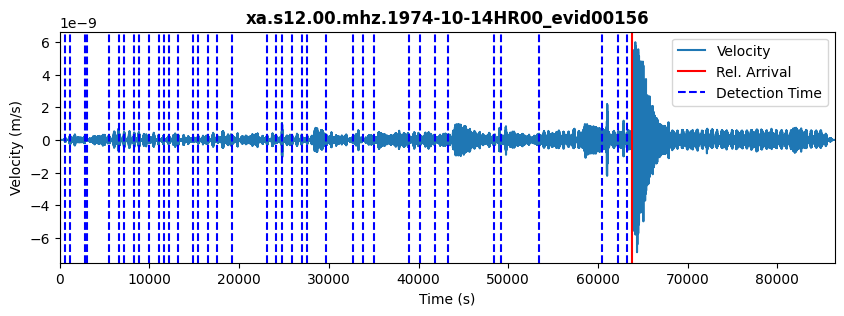

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1974-10-14 17:43:00
DataFrame de Scores:
    id                   time_abs score
0   39 1974-10-14 17:44:53.675245     5
1   21 1974-10-14 06:52:40.996000     4
2   38 1974-10-14 17:28:05.977132     4
3   27 1974-10-14 09:15:01.675245     3
4   20 1974-10-14 06:35:09.977132     2
5   37 1974-10-14 16:56:50.203547     2
6    4 1974-10-14 01:00:34.354491     1
7   28 1974-10-14 09:34:04.316755     1
8    8 1974-10-14 02:28:06.128075     1
9   34 1974-10-14 13:36:33.448830     1
10  24 1974-10-14 07:40:14.279019     0
11   5 1974-10-14 01:40:42.354491     0
12  29 1974-10-14 09:53:02.429962     0
13  26 1974-10-14 08:25:25.373358     0
14  25 1974-10-14 07:49:38.203547     0
15  16 1974-10-14 04:27:42.580906     0
16  30 1974-10-14 10:58:12.467698     0
17  19 1974-10-14 05:30:39.033736     0
18  36 1974-10-14 15:00:20.618642     0
19  32 1974-10-14 11:47:13.297887     0
20   2 1974-10-14 00:28:57.297887     0
21  31 1974-10-14 11:19:48.014868     0
22  35 

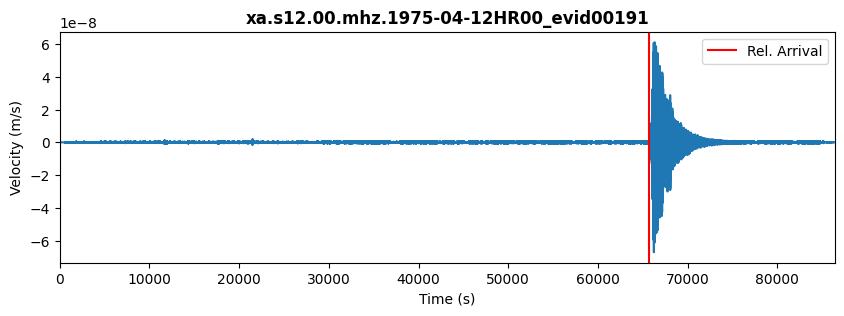

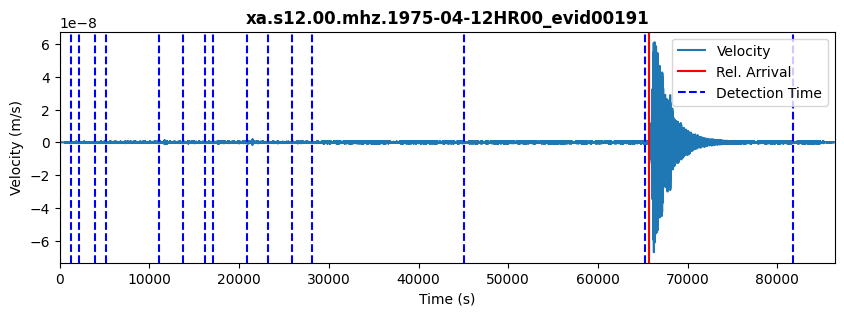

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1975-04-12 18:15:00
DataFrame de Scores:
    id                   time_abs score
0   14 1975-04-12 18:17:44.941717     7
1   10 1975-04-12 06:37:00.715302     4
2    9 1975-04-12 05:57:46.753038     4
3    7 1975-04-12 04:38:56.639830     3
4    5 1975-04-12 03:14:36.262472     2
5   13 1975-04-12 12:40:56.187000     2
6    6 1975-04-12 03:58:56.187000     1
7    8 1975-04-12 04:54:03.356811     1
8    4 1975-04-12 01:35:14.753038     0
9    0 1975-04-12 00:10:00.036057     0
10  12 1975-04-12 07:59:20.639830     0
11  11 1975-04-12 07:22:21.771906     0
12  15 1975-04-12 22:51:40.262472     0
13   1 1975-04-12 00:30:46.224736     0
14   2 1975-04-12 00:45:55.658698     0
15   3 1975-04-12 01:16:18.149264     0
Nombre del archivo: xa.s12.00.mhz.1975-05-04HR00_evid00192
Tiempo de llegada relativo: 36300.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1975-05-04T00:00:00.457000       0.000000   8.378883e-17
1     19

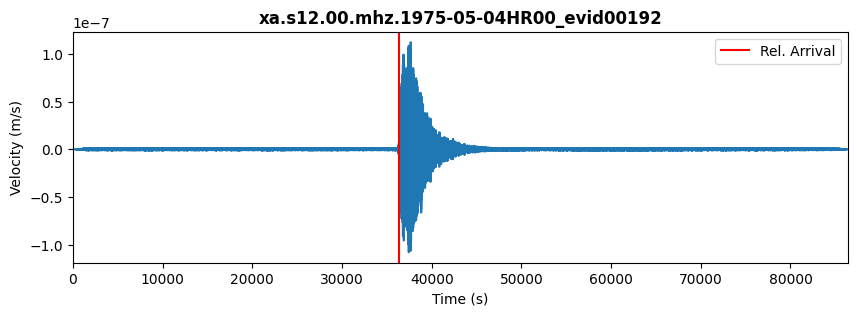

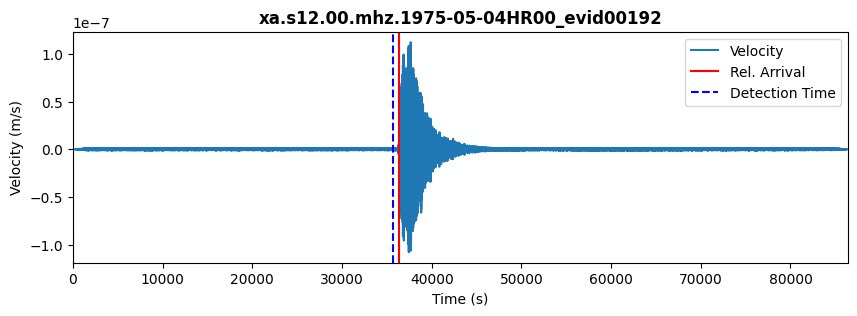

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1975-05-04 10:05:00
DataFrame de Scores:
  id                   time_abs score
0  0 1975-05-04 00:10:00.306057     8
1  1 1975-05-04 10:05:38.268321     8
Nombre del archivo: xa.s12.00.mhz.1975-06-24HR00_evid00196
Tiempo de llegada relativo: 57780.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1975-06-24T00:00:00.239000       0.000000   1.179911e-14
1     1975-06-24T00:00:00.389943       0.150943   1.488725e-14
2     1975-06-24T00:00:00.540887       0.301887   1.579572e-14
3     1975-06-24T00:00:00.691830       0.452830   1.424529e-14
4     1975-06-24T00:00:00.842774       0.603774   1.102928e-14
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1975-06-24T00:00:00.239000       0.000000   1.179911e-14
1     1975-06-24T00:00:00.389943       0.150943   1.488725e-14
2     1975-06-24T00:00:00.540887       0.301887   1.579572e-14
3     1975-06-24T00:00:00.691830       0.452830   1.424

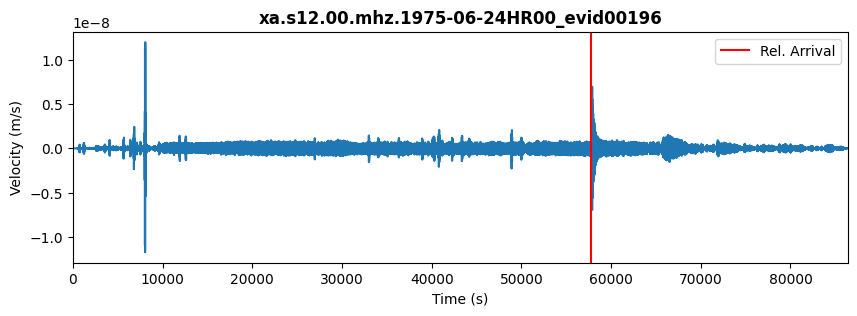

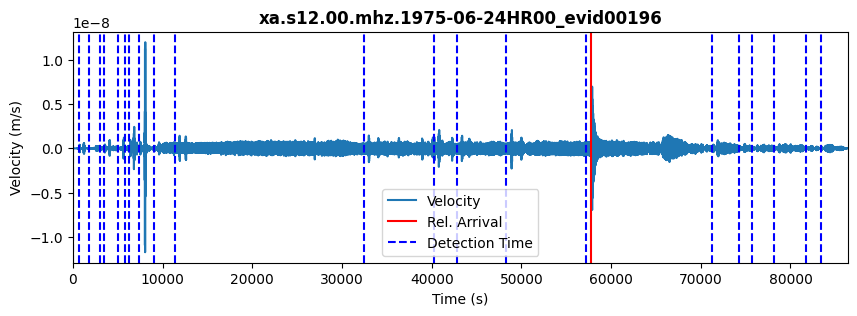

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


Inicio de sismo desde catálogo: 1975-06-24 16:03:00
DataFrame de Scores:
    id                   time_abs score
0    8 1975-06-24 02:13:32.314472     4
1    7 1975-06-24 01:53:19.635226     4
2    1 1975-06-24 00:20:47.484283     3
3   15 1975-06-24 16:04:02.654094     3
4    5 1975-06-24 01:33:40.918245     2
5   12 1975-06-24 11:20:50.503151     2
6   11 1975-06-24 09:10:25.748434     2
7   16 1975-06-24 19:57:55.559755     2
8   14 1975-06-24 13:35:05.597491     1
9   19 1975-06-24 21:52:27.710698     1
10  10 1975-06-24 03:18:50.352208     0
11   4 1975-06-24 01:08:19.710698     0
12  13 1975-06-24 12:03:06.201264     0
13   0 1975-06-24 00:10:00.088057     0
14   2 1975-06-24 00:39:23.106925     0
15  20 1975-06-24 22:51:20.239000     0
16   6 1975-06-24 01:46:32.993717     0
17  17 1975-06-24 20:48:13.823906     0
18  18 1975-06-24 21:11:53.446547     0
19  21 1975-06-24 23:20:02.201264     0
20   9 1975-06-24 02:40:01.748434     0
21   3 1975-06-24 00:59:26.125792     0
Nombre 

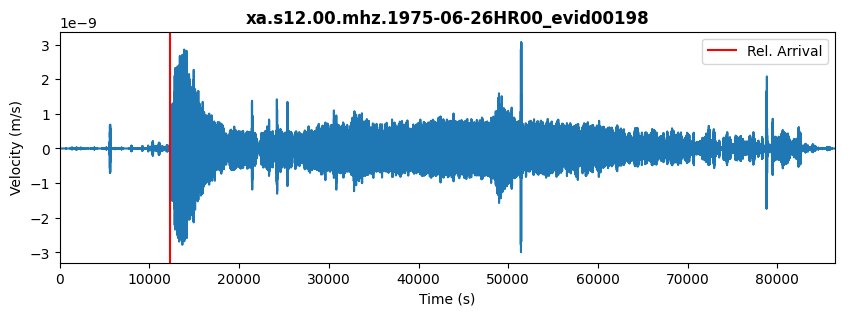

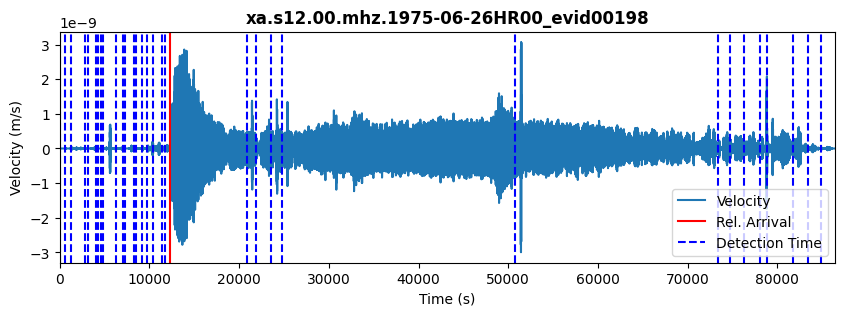

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])


Inicio de sismo desde catálogo: 1975-06-26 03:24:00
DataFrame de Scores:
    id                   time_abs score
0   23 1975-06-26 14:16:44.617472     6
1   19 1975-06-26 05:57:54.353321     4
2   18 1975-06-26 03:25:53.900491     4
3   27 1975-06-26 21:52:54.277849     3
4   22 1975-06-26 07:03:30.504264     2
5   21 1975-06-26 06:43:22.655208     2
6   28 1975-06-26 22:04:14.881623     1
7   29 1975-06-26 22:53:36.089170     1
8   20 1975-06-26 06:15:34.126906     1
9   31 1975-06-26 23:45:32.164642     0
10  14 1975-06-26 02:44:06.579736     0
11   8 1975-06-26 01:31:41.674075     0
12  26 1975-06-26 21:22:35.560868     0
13  24 1975-06-26 20:34:12.315585     0
14  25 1975-06-26 20:56:04.164642     0
15  10 1975-06-26 02:08:08.391057     0
16  17 1975-06-26 03:21:12.692943     0
17   6 1975-06-26 01:21:57.674075     0
18   4 1975-06-26 01:02:37.523132     0
19  16 1975-06-26 03:04:08.692943     0
20   7 1975-06-26 01:26:38.277849     0
21  12 1975-06-26 02:29:14.202377     0
22  13 

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


In [22]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
for i in range(len(cat)):
    columna=i
    # Llamar a la función y almacenar el resultado
    clean_data_cat, original_data_cat, test_filename, arrival_time_rel = read_and_clean_data(cat, columna)
    print(f"Nombre del archivo: {test_filename}")
    print(f"Tiempo de llegada relativo: {arrival_time_rel}")
    print(f"Datos originales:\n{original_data_cat.head()}")
    print(f"Datos limpios:\n{clean_data_cat.head()}")
    csv_times = np.array(original_data_cat['time_rel(sec)'].tolist())
    csv_data = np.array(original_data_cat['velocity(m/s)'].tolist())
    plot_velocity_trace(csv_data=csv_data, csv_times=csv_times, arrival_time_rel=arrival_time_rel, test_filename=test_filename)

    data_directory = './data/lunar/training/data/S12_GradeA/'
    mseed_file = f'{data_directory}{test_filename}.mseed'
    st = read(mseed_file)
    st
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data
    df = tr.stats.sampling_rate
    # How long should the short-term and long-term window be, in seconds
    sta_len = 120
    lta_len = 600
    thr_on = 3
    thr_off = 1
    detection_times = trigger_detection(tr_data=tr_data, tr_times=tr_times, df=df, sta_len=sta_len, lta_len=lta_len, thr_off=thr_off, thr_on=thr_on)
    csv_times = np.array(original_data_cat['time_rel(sec)'].tolist())
    csv_data = np.array(original_data_cat['velocity(m/s)'].tolist())
    plot_velocity_trace_detection(csv_data=csv_data, csv_times=csv_times, detection_times=detection_times, arrival_time_rel=arrival_time_rel, test_filename=test_filename)
    clean_variation_df_sorted_mean, clean_variation_df_sorted_power, variation_df_sorted_mean, variation_df_sorted_power = calculate_and_sort_variations(original_data_cat, clean_data_cat, detection_times)
    scores_df = assign_scores(
        variation_df_sorted_mean,
        variation_df_sorted_power,
        clean_variation_df_sorted_mean,
        clean_variation_df_sorted_power
    )
    absolute_arrival= relative_to_absolute(relative_time=arrival_time_rel, test_filename=test_filename)
    # Mostrar los resultados
    print(f"Inicio de sismo desde catálogo: {absolute_arrival}")
    print("DataFrame de Scores:")
    print(scores_df)
    print("=" * 77)


Nombre del archivo: xa.s12.00.mhz.1970-01-19HR00_evid00002
Tiempo de llegada relativo: 73500.0
Datos originales:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-01-19T00:00:00.665000       0.000000  -6.153279e-14
1     1970-01-19T00:00:00.815943       0.150943  -7.701288e-14
2     1970-01-19T00:00:00.966887       0.301887  -8.396187e-14
3     1970-01-19T00:00:01.117830       0.452830  -8.096155e-14
4     1970-01-19T00:00:01.268774       0.603774  -7.097599e-14
Datos limpios:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-01-19T00:00:00.665000       0.000000  -6.153279e-14
1     1970-01-19T00:00:00.815943       0.150943  -7.701288e-14
2     1970-01-19T00:00:00.966887       0.301887  -8.396187e-14
3     1970-01-19T00:00:01.117830       0.452830  -8.096155e-14
4     1970-01-19T00:00:01.268774       0.603774  -7.097599e-14


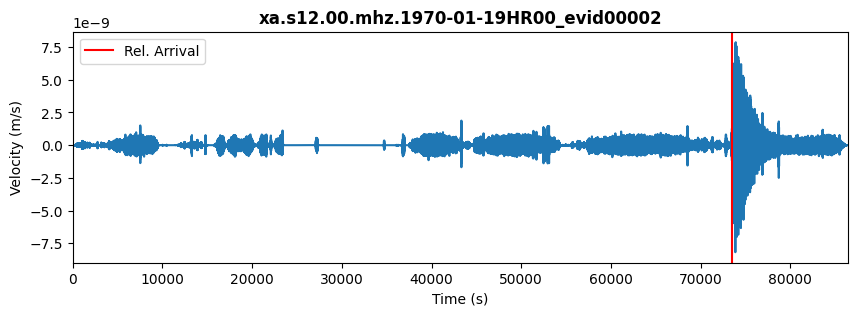

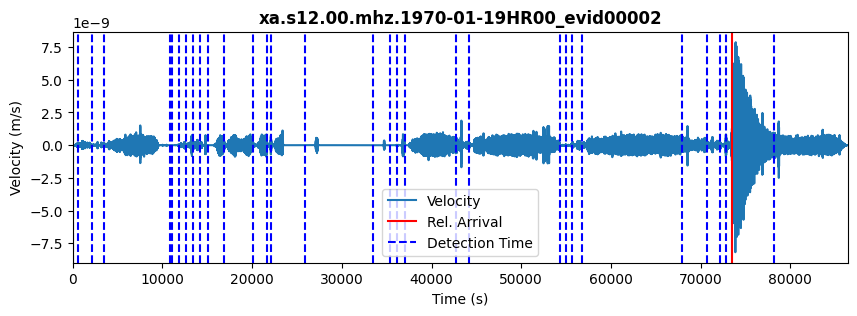

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_66881/3102104035.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


KeyError: "None of [Index(['time_rel(sec)'], dtype='object')] are in the [columns]"

In [30]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)

for i in range(len(cat)):
    columna = i
    # Llamar a la función y almacenar el resultado
    clean_data_cat, original_data_cat, test_filename, arrival_time_rel = read_and_clean_data(cat, columna)
    print(f"Nombre del archivo: {test_filename}")
    print(f"Tiempo de llegada relativo: {arrival_time_rel}")
    print(f"Datos originales:\n{original_data_cat.head()}")
    print(f"Datos limpios:\n{clean_data_cat.head()}")
    
    # Obtener datos de tiempo y velocidad
    csv_times = np.array(original_data_cat['time_rel(sec)'].tolist())
    csv_data = np.array(original_data_cat['velocity(m/s)'].tolist())
    
    # Graficar la traza de velocidad
    plot_velocity_trace(csv_data=csv_data, csv_times=csv_times, arrival_time_rel=arrival_time_rel, test_filename=test_filename)

    # Leer el archivo mseed
    data_directory = './data/lunar/training/data/S12_GradeA/'
    mseed_file = f'{data_directory}{test_filename}.mseed'
    st = read(mseed_file)
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data
    df = tr.stats.sampling_rate

    # Configurar los parámetros de detección
    sta_len = 120
    lta_len = 600
    thr_on = 3
    thr_off = 1
    detection_times = trigger_detection(tr_data=tr_data, tr_times=tr_times, df=df, sta_len=sta_len, lta_len=lta_len, thr_off=thr_off, thr_on=thr_on)

    # Graficar la traza de velocidad con detección
    plot_velocity_trace_detection(csv_data=csv_data, csv_times=csv_times, detection_times=detection_times, arrival_time_rel=arrival_time_rel, test_filename=test_filename)

    # Calcular variaciones y puntajes
    clean_variation_df_sorted_mean, clean_variation_df_sorted_power, variation_df_sorted_mean, variation_df_sorted_power = calculate_and_sort_variations(original_data_cat, clean_data_cat, detection_times)
    scores_df = assign_scores(
        variation_df_sorted_mean,
        variation_df_sorted_power,
        clean_variation_df_sorted_mean,
        clean_variation_df_sorted_power
    )
    absolute_highscores
    # Convertir scores_df a un arreglo de numpy
    X = scores_df[['time_rel(sec)']].to_numpy()  # Asegúrate de que 'time_rel(sec)' sea el nombre correcto de la columna
    y = arrival_time_rel  # El valor de arrival_time_rel como target

    # Mostrar los resultados
    absolute_arrival = relative_to_absolute(relative_time=arrival_time_rel, test_filename=test_filename)
    print(f"Inicio de sismo desde catálogo: {absolute_arrival}")
    print("DataFrame de Scores:")
    print(scores_df)
    print("=" * 77)

    # Definir y compilar la red neuronal
    model = keras.Sequential([
        layers.Input(shape=(X.shape[1],)),  # Entrada según la cantidad de características
        layers.Dense(64, activation='relu'),  # Capa oculta con 64 neuronas
        layers.Dense(32, activation='relu'),  # Capa oculta con 32 neuronas
        layers.Dense(1)  # Capa de salida para predicción continua
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Entrenar el modelo
    model.fit(X, np.array([y]), epochs=100, verbose=1)  # Ajustar el número de épocas según sea necesario

    # Realizar predicciones (opcional)
    predictions = model.predict(X)
    print(f"Predicciones: {predictions}")
